In [1]:
!pip install seaborn --upgrade --quiet
!pip install pandas --upgrade --quiet
!pip install missingno --quiet
!pip install pywaffle --quiet
!pip install pyvis --quiet

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
import time
import math
import os

import missingno as msno
from pywaffle import Waffle

import networkx as nx

import pyvis
from pyvis.network import Network
net = Network(notebook=True, cdn_resources='in_line')
net.show('Test.html')

import requests

Test.html


Paraméterek és alap beállítások

In [3]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['figure.dpi'] = 200 #high resolution

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)


In [4]:
sns.set(
        style="ticks",                 
        rc={"figure.figsize": (6, 9),    
            "figure.facecolor": "#FEFDED",  
            "axes.facecolor": "ivory"})
pd.option_context('mode.use_inf_as_na', True)

A kezdeti gondolatok és kérdések gyűjteménye:
http://simp.ly/p/ZyzbJn

A későbbi adatvizualizációhoz készítek egy template-et

In [5]:
raw_light_palette = [
    (174, 243, 231), 
    (158, 235, 235), 
    (142, 227, 239),
    (99, 170, 191),
    (55, 113, 142),
    (46, 96, 127), 
    (37, 78, 112), 
    (116, 69, 98),
    (195, 60, 84) 
]
light_palette = np.array(raw_light_palette)/255

In [6]:
raw_light_palette_hex = [
    '#AEF3E7',
    '#9EEBEB',
    '#8EE3EF',
    '#63AABF',
    '#37718E',
    '#2E607F',
    '#254E70',
    '#744562',
    '#C33C54'
]

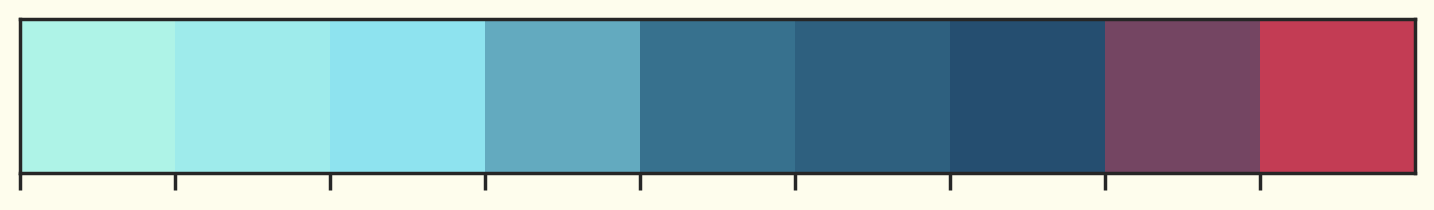

In [7]:
sns.palplot(light_palette)

In [8]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", raw_light_palette_hex)

Függvények

In [9]:
# az outlierek megjenelenítéséhez használt függvény
def num_outliers(df, cols, features_dict):
    plt.figure(figsize=(18, 10))
     
    for i, feature in enumerate(cols, 1):
        plt.subplot(1, 2, i)
        sns.violinplot(y=df[feature], color=light_palette[3])
        sns.stripplot(data = df,          
                          y = feature,
                          color = light_palette[7],
                          linewidth = 2,
                          alpha = 0.1)
        plt.title(features_dict[feature], fontsize=16)
        plt.ylabel(features_dict[feature], fontsize=14)
        plt.xlabel('')  # Removing the x-axis label as it's not needed
     
    plt.tight_layout()
    plt.show();

Weather API beállítások

In [10]:
from config import API_KEY

In [11]:
url = 'http://api.weatherapi.com/v1/history.json'

# teszt
api_key = API_KEY
location = 'Budapest'
date = '2024-04-01'
request_url = f'{url}?key={api_key}&q={location}&dt={date}'

test_url = 'http://api.weatherapi.com/v1'
requests.get(request_url)

<Response [200]>

Teszt rendben

## 1.0 Adatok betöltése

In [384]:
df = pd.read_csv('./Sources/FileResults/Competitions.csv', sep=',')
df.head()

city        race_name        date      when  Division  \
0  Heroltice  Hanácké škvarek  2023-04-22  10:11:57         1   
1  Heroltice  Hanácké škvarek  2023-04-22  10:11:57         1   
2  Heroltice  Hanácké škvarek  2023-04-22  10:11:57         1   
3  Heroltice  Hanácké škvarek  2023-04-22  10:11:57         1   
4  Heroltice  Hanácké škvarek  2023-04-22  10:11:57         1   

                    who  total_time W/L/T  Hurdles    name  start  time  \
0  Wildrunners Dreamers       17.01     L     25.0   Sunny  -0.24  4.21   
1  Wildrunners Dreamers       17.01     L     25.0   Dixie   0.30  4.24   
2  Wildrunners Dreamers       17.01     L     25.0    Alex   0.16  4.22   
3  Wildrunners Dreamers       17.01     L     25.0  Hector   0.00  4.13   
4  Wildrunners Maximini       19.43     L     25.0  Brooke  -0.11  4.08   

   error  anomaly  w_pair  ordinal_no                                  dogs  \
0   True    False   False           1  ['Sunny', 'Dixie', 'Alex', 'Hector']   
1  False    False   False           2  ['Sunny', 'Dixie', 'Alex', 'Hector']   
2  False    False   False           3  ['Sunny', 'Dixie', 'Alex', 'Hector']   
3  False    False   False           4  ['Sunny', 'Dixie', 'Alex', 'Hector']   
4   True    False   False           1  ['Brooke', 'Rocky', 'Bella', 'Bree']   

       szin  
0  FF0000FF  
1  FF0000FF  
2  FF0000FF  
3  FF0000FF  
4  FFFF0000

In [13]:
dogs = pd.read_csv('/Users/radnar/Documents/Development/Projects/Data36_Flyball/Sources/FileResults/Wild_Runners_Dogs.csv', sep=';')
dogs.head()

felvezeto     nev          fajta    nem       ivar szuletesi_datum  \
0  TM800418  Dexter  Kooikerhondje    Kan  ivartalan      2010-02-14   
1  NP950613  Jasper  Border Collie    Kan  ivartalan      2011-03-28   
2  UF830429   Angie  Border Collie  Szuka  ivartalan      2014-02-06   
3  ZE801127    Alex  Border Collie    Kan  ivartalan      2014-04-22   
4  DP910919  Ashley  Border Collie  Szuka  ivartalan      2015-01-26   

        chip_szam  ulna_hossz  ugrasi_magassag  
0  93900005238999       14.05             25.0  
1  93900007189034       16.56             30.0  
2  93900003827629       15.22             27.5  
3  93900003598960       17.95             32.5  
4  93900009738344       18.30             32.5

In [14]:
# A pálya színét tároltam egy változóba, miver erre közvetlen nincsen szükségem, így átalakítom

color_dict = dict(
{
    'FF0000FF' : 0,
    'FFFF0000' : 1,
    '0000FFFF' : 0,
    '0000FF00' : 1
})

In [385]:
df['szin'] = df['szin'].map(color_dict)

In [366]:
df['szin'].value_counts()

szin
0    16920
1    16872
Name: count, dtype: int64

### 1.01 Teljes adathalmaz áttekintése

Első körben csak ismerkedem az adathalmazzal, mondhatni vizsgálgatom és ízlelgetem, próbálok egyfajta érzést felépíteni magamban és hagyni azt, hogy az áttekintés során az érzéseim jelzéseit befogadjam. Ez nem megy mindig elsőre, vagy hogy többször is neki kell ülnöm, teszem ezt addig, amíg rá nem tudok hangolódni a történetre, amit el akar nekem mesélni :)

In [269]:
# Adathalmaz soria és változói
print(df.shape)

(33792, 20)


In [270]:
rows, columns = df.shape
print(f"Az adathalmazban {rows} különböző eredmény került rögzítésre {columns} tulajdonságon keresztül.")

Az adathalmazban 33792 különböző eredmény került rögzítésre 20 tulajdonságon keresztül.


In [285]:
data_types = df.dtypes
type_counts = data_types.value_counts()
print(type_counts)

object     12
bool        5
float64     3
Name: count, dtype: int64


In [273]:
print(data_types)

city            object
race_name       object
date            object
when            object
Division         int64
who             object
total_time     float64
W/L/T           object
Hurdles        float64
name            object
start          float64
time           float64
error             bool
anomaly           bool
w_pair            bool
ordinal_no       int64
dogs            object
szin             int64
start_error       bool
time_error        bool
dtype: object


Van pár kategória típusú változóm, illetve köztük pár, amely a változók ismeretében majd típusát tekintve átalakításra kell kerüljön (pl. date)

In [274]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

missing_info = pd.DataFrame({'Missing Values': missing_data,
                              'Percentage': missing_percentage})

In [277]:
missing_info = missing_info.sort_values(by='Percentage', ascending=False)

# Változók, ahol null értékek találhatóak és azok százalékos megoszlása
print(missing_info[missing_info['Missing Values'] > 0])

         Missing Values  Percentage
start              2561    7.578717
time                844    2.497633
name                424    1.254735
Hurdles             152    0.449811


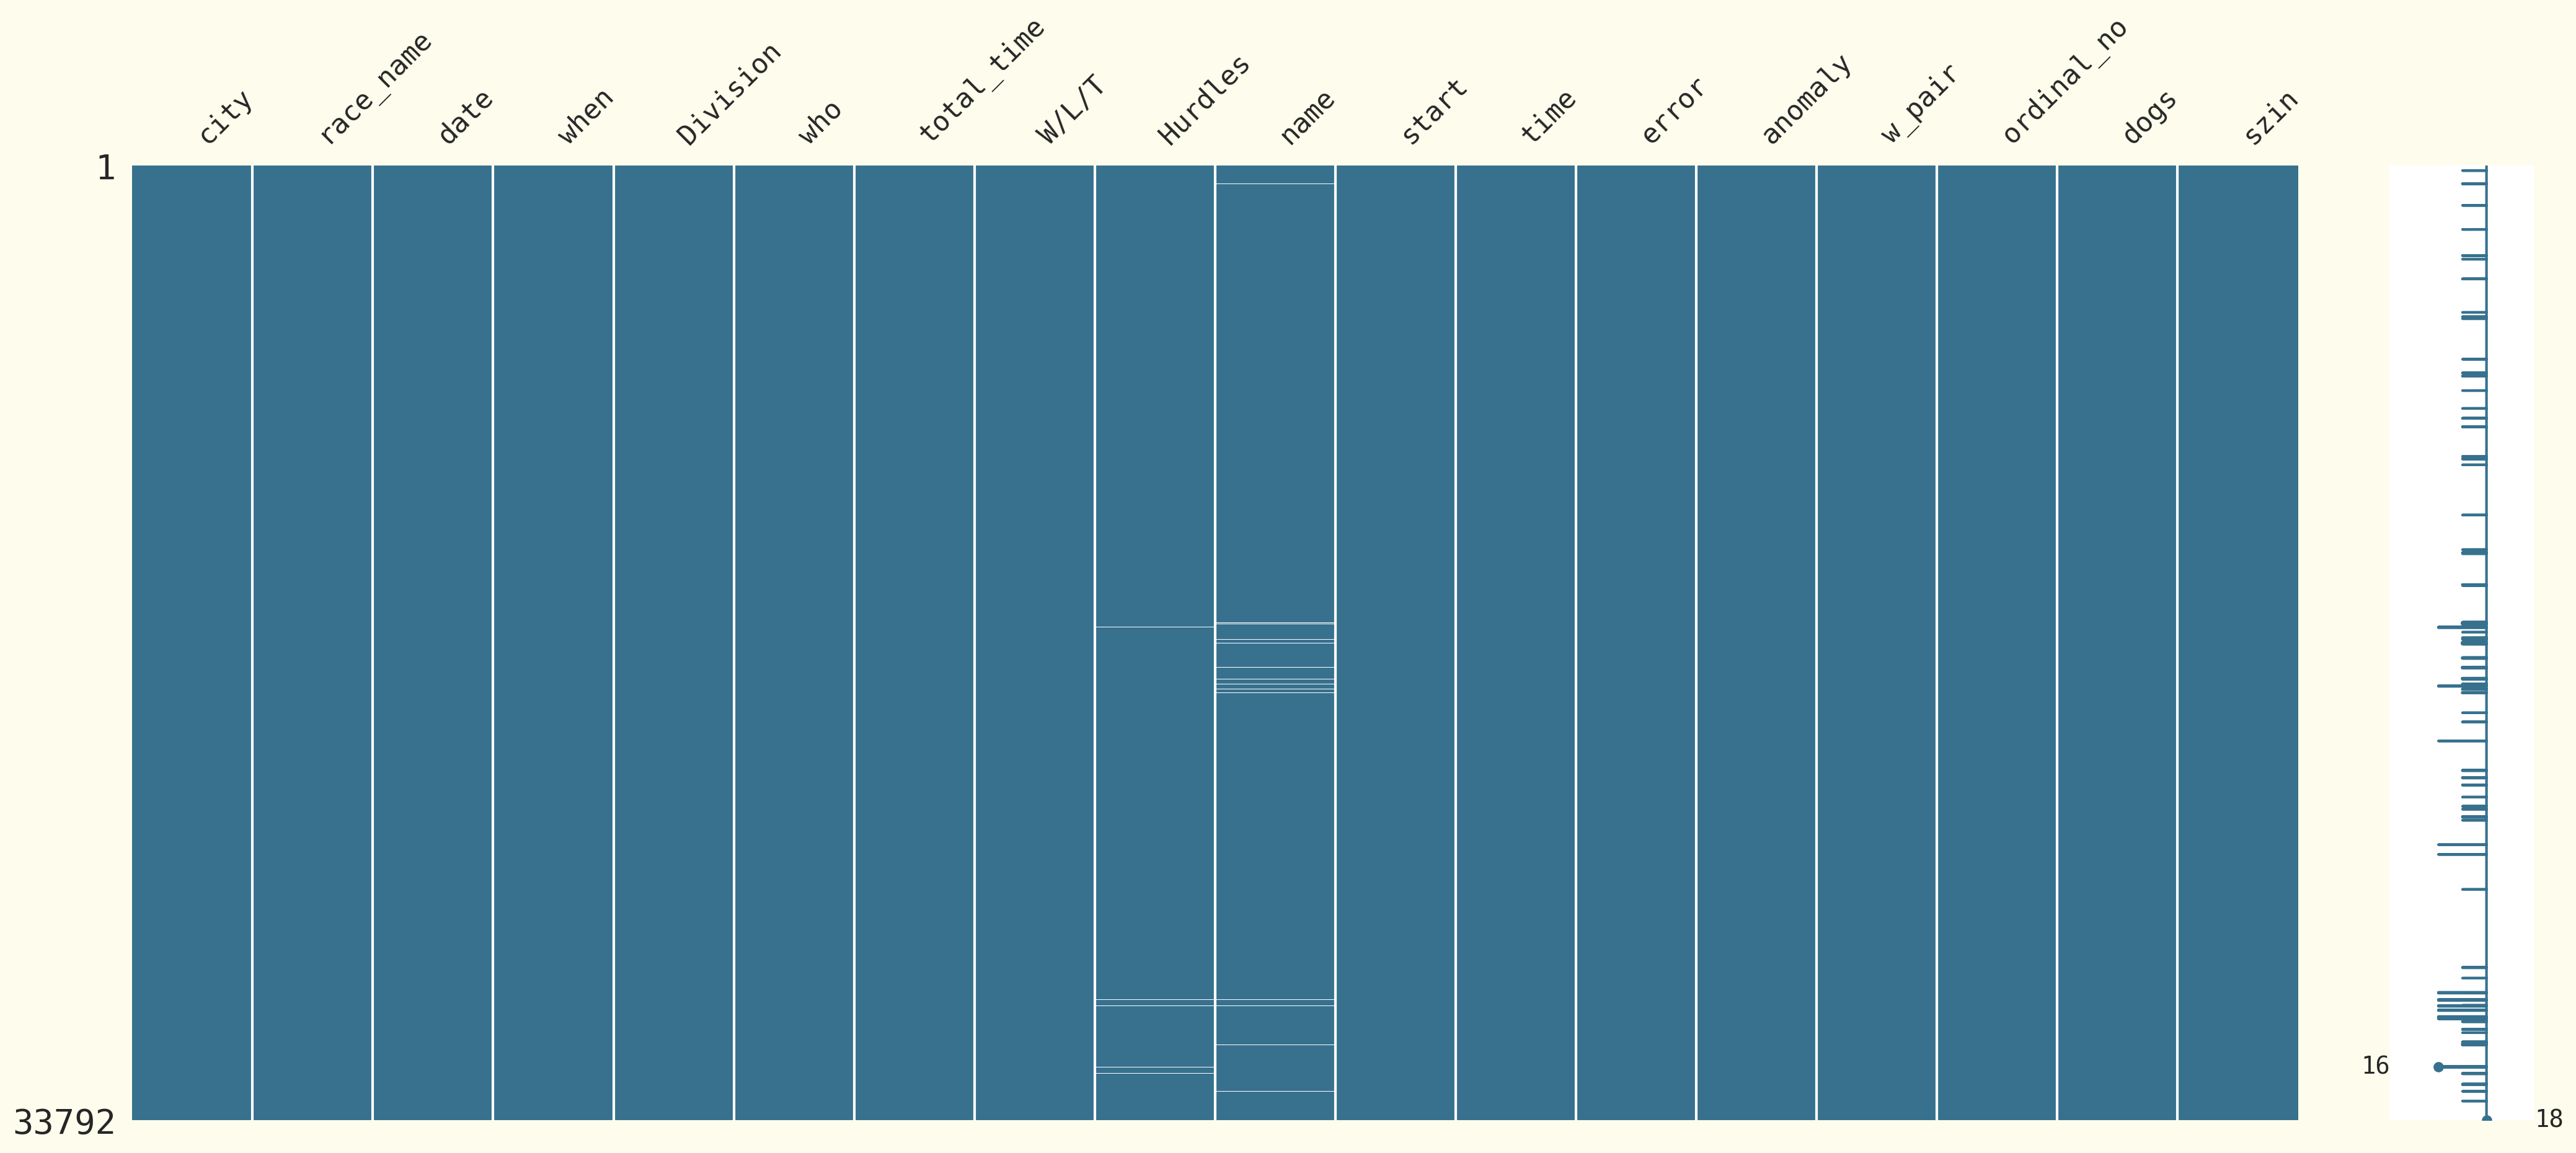

In [367]:
# Nézzük vizuálisan a null értékek helyzetét
msno.matrix(df, color=light_palette[4])
plt.show()

In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33792 entries, 0 to 33791
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        33792 non-null  object 
 1   race_name   33792 non-null  object 
 2   date        33792 non-null  object 
 3   when        33792 non-null  object 
 4   Division    33792 non-null  int64  
 5   who         33792 non-null  object 
 6   total_time  33792 non-null  float64
 7   W/L/T       33792 non-null  object 
 8   Hurdles     33640 non-null  float64
 9   name        33368 non-null  object 
 10  start       33792 non-null  float64
 11  time        33792 non-null  float64
 12  error       33792 non-null  bool   
 13  anomaly     33792 non-null  bool   
 14  w_pair      33792 non-null  bool   
 15  ordinal_no  33792 non-null  int64  
 16  dogs        33792 non-null  object 
 17  szin        33792 non-null  int64  
dtypes: bool(3), float64(4), int64(3), object(8)
memory usage: 4.0+ MB


### 1.02 Változók típusainak azonosítása

In [263]:
df.describe().T.style.bar(subset=['mean'], color='#37718E')\
                            .background_gradient(subset=['std'], cmap=cmap)\
                            .background_gradient(subset=['50%'], cmap=cmap)

In [386]:
## Start és Time esetén hiba oszlopok felvétele, majd 999 értékek Nan-re alakítása

df['start_error'] = df['start'].apply(lambda x : True if x < 0 or x == 999 else False)
df['time_error'] = df['time'].apply(lambda x : True if x == 999 else False)

In [387]:
df= df.replace(999, np.nan)

#### 1.02.0 Változók típusainak azonosítása

In [371]:
numerical_features = df.describe().columns.tolist()
numerical_features

['Division', 'total_time', 'Hurdles', 'start', 'time', 'ordinal_no', 'szin']

In [372]:
threshold = 10
categorical_features = df.columns[df.nunique() <= threshold].tolist()
categorical_features

['city',
 'W/L/T',
 'Hurdles',
 'error',
 'anomaly',
 'w_pair',
 'ordinal_no',
 'szin',
 'start_error',
 'time_error']

In [283]:
# Using value_counts() on each column or feature
# for column in df.columns: print(df[column].value_counts())

# Ezt most kiszedtem, hogy a hosszú eredmény ne törje meg az elemzést, de előtte azt futtatam az áttekintés miatt

A fentiek alapján van pár numerikus változó, amely tulajdonképpen category típusú, ezért ezeket átalakítom

In [388]:
df['Division'] = df['Division'].astype('object')
df['Hurdles'] = df['Hurdles'].astype('object')
df['ordinal_no'] = df['ordinal_no'].astype('object')
df['szin'] = df['szin'].astype('object')

In [389]:
data_types = df.dtypes
type_counts = data_types.value_counts()
print(type_counts)

object     12
bool        5
float64     3
Name: count, dtype: int64


Ezen a ponton a hiányzó értékeket is kezelem. 

start és time:
Átlaggal feltöltöm majd később, ha egy modelt használnék (a hibás értékek jelzésére felvettem egy oszlopot), de egyelőre üresen hagyom
name:
Ahol ez üres, azt a sort törlöm, mivel a kutyák számomra az egyik kulcs, így ennek hiányában a csapat eredményét sem érzem érdemben elemezhetőnek.
Hurdles:
Lehet pár elemzés, amikor ez információt adhat, de mivel kicsi a számossága, így szerintem kutya futása során használtak alapján mint átlag ezt feltöltöm

         Missing Values  Percentage
start              2561    7.578717
time                844    2.497633
name                424    1.254735
Hurdles             152    0.449811

In [375]:
## Ahol van futási eredmény, de nincsen név, azt feltölteném pl. NoName értékkel legalább, mert csapat elemzése szempontjából értékes lehet
df[(df[['start', 'time']].isnull().sum(axis=1) == 0) & (df['name'].isnull())]

city                    race_name        date      when  \
16338         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:00:24   
16339         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:00:24   
16345         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:01:41   
16346         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:01:41   
16347         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:01:41   
16353         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:02:59   
16354         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:02:59   
16355         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:02:59   
16918         Louňovice       Máchale, spadlo ti to!  2023-07-15  13:02:15   
17446         Louňovice       Máchale, spadlo ti to!  2023-07-15  08:09:46   
18370         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:04:02   
18417         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:20:12   
18418         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:20:12   
18419         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:20:12   
18425         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:21:27   
18426         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:21:27   
18427         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:21:27   
18433         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:23:55   
18434         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:23:55   
20368            Blšany  Mistrovství České republiky  2023-09-03  11:30:05   
20369            Blšany  Mistrovství České republiky  2023-09-03  11:30:05   
20370            Blšany  Mistrovství České republiky  2023-09-03  11:30:05   
20371            Blšany  Mistrovství České republiky  2023-09-03  11:30:05   
21403          Litomyšl              Křupky na břehu  2023-09-16  13:41:54   
21411          Litomyšl              Křupky na břehu  2023-09-16  13:43:14   
21419          Litomyšl              Křupky na břehu  2023-09-16  13:44:16   
21671          Litomyšl              Křupky na břehu  2023-09-16  15:08:54   
21679          Litomyšl              Křupky na břehu  2023-09-16  15:10:34   
21922          Litomyšl              Křupky na břehu  2023-09-16  16:49:00   
21930          Litomyšl              Křupky na břehu  2023-09-16  16:50:12   
23043          Litomyšl              Křupky na břehu  2023-09-16  14:49:29   
23051          Litomyšl              Křupky na břehu  2023-09-16  14:50:36   
23059          Litomyšl              Křupky na břehu  2023-09-16  14:51:46   
23067          Litomyšl              Křupky na břehu  2023-09-16  14:53:05   
24040           Vodňany     Budějckej xtreme 1. ring  2023-10-14  12:52:18   
24041           Vodňany     Budějckej xtreme 1. ring  2023-10-14  12:52:18   
24042           Vodňany     Budějckej xtreme 1. ring  2023-10-14  12:52:18   
24043           Vodňany     Budějckej xtreme 1. ring  2023-10-14  12:52:18   
24384           Vodňany     Budějckej xtreme 1. ring  2023-10-14  15:06:42   
24385           Vodňany     Budějckej xtreme 1. ring  2023-10-14  15:06:42   
24386           Vodňany     Budějckej xtreme 1. ring  2023-10-14  15:06:42   
24387           Vodňany     Budějckej xtreme 1. ring  2023-10-14  15:06:42   
29268  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:00:18   
29269  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:00:18   
29270  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:00:18   
29271  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:00:18   
29276  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:02:19   
29277  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:02:19   
29278  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:02:19   
29279  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:02:19   
29284  Tápiószentmárton                 E

In [390]:
df.loc[(df[['start', 'time']].notnull().all(axis=1)) & (df['name'].isnull()), 'name'] = 'noname'

In [377]:
df[(df[['start', 'time']].isnull().sum(axis=1) == 0) & (df['name'].isnull())]

Empty DataFrame
Columns: [city, race_name, date, when, Division, who, total_time, W/L/T, Hurdles, name, start, time, error, anomaly, w_pair, ordinal_no, dogs, szin, start_error, time_error]
Index: []

Azokban az esetekben, amikor nincsen nevem sem a hiányzó Hurdles érték mellett, ott nem tudok érdemben név alapján feltöltni, így őket egyelőre meghagyom üresnek

In [378]:
df.loc[(df['Hurdles'].isnull()) & (df['name'] == 'noname')]

city                    race_name        date      when  \
16338         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:00:24   
16339         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:00:24   
16345         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:01:41   
16346         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:01:41   
16347         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:01:41   
16353         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:02:59   
16354         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:02:59   
16355         Louňovice       Máchale, spadlo ti to!  2023-07-15  10:02:59   
18417         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:20:12   
18418         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:20:12   
18419         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:20:12   
18425         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:21:27   
18426         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:21:27   
18427         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:21:27   
18433         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:23:55   
18434         Louňovice       Máchale, spadlo ti to!  2023-07-15  14:23:55   
20368            Blšany  Mistrovství České republiky  2023-09-03  11:30:05   
20369            Blšany  Mistrovství České republiky  2023-09-03  11:30:05   
20370            Blšany  Mistrovství České republiky  2023-09-03  11:30:05   
20371            Blšany  Mistrovství České republiky  2023-09-03  11:30:05   
24040           Vodňany     Budějckej xtreme 1. ring  2023-10-14  12:52:18   
24041           Vodňany     Budějckej xtreme 1. ring  2023-10-14  12:52:18   
24042           Vodňany     Budějckej xtreme 1. ring  2023-10-14  12:52:18   
24043           Vodňany     Budějckej xtreme 1. ring  2023-10-14  12:52:18   
24384           Vodňany     Budějckej xtreme 1. ring  2023-10-14  15:06:42   
24385           Vodňany     Budějckej xtreme 1. ring  2023-10-14  15:06:42   
24386           Vodňany     Budějckej xtreme 1. ring  2023-10-14  15:06:42   
24387           Vodňany     Budějckej xtreme 1. ring  2023-10-14  15:06:42   
29268  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:00:18   
29269  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:00:18   
29270  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:00:18   
29271  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:00:18   
29276  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:02:19   
29277  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:02:19   
29278  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:02:19   
29279  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:02:19   
29284  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:03:46   
29285  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:03:46   
29286  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:03:46   
29287  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:03:46   
29292  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:05:31   
29293  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:05:31   
29294  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:05:31   
29295  Tápiószentmárton                 EFC - Ring 1  2023-07-29  13:05:31   
29524  Tápiószentmárton                 EFC - Ring 1  2023-07-29  14:22:03   
29525  Tápiószentmárton                 EFC - Ring 1  2023-07-29  14:22:03   
29526  Tápiószentmárton                 EFC - Ring 1  2023-07-29  14:22:03   
29527  Tápiószentmárton                 EFC - Ring 1  2023-07-29  14:22:03   
29532  Tápiószentmárton                 EFC - Ring 1  2023-07-29  14:23:33   
29533  Tápiószentmárton                 EFC - Ring 1  2023-07-29  14:23:33   
29534  Tápiószentmárton                 E

In [379]:
df.loc[(df['Hurdles'].isnull()) & (df['name'] != 'noname')]

city               race_name        date      when  \
16336         Louňovice  Máchale, spadlo ti to!  2023-07-15  10:00:24   
16337         Louňovice  Máchale, spadlo ti to!  2023-07-15  10:00:24   
16344         Louňovice  Máchale, spadlo ti to!  2023-07-15  10:01:41   
16352         Louňovice  Máchale, spadlo ti to!  2023-07-15  10:02:59   
18416         Louňovice  Máchale, spadlo ti to!  2023-07-15  14:20:12   
18424         Louňovice  Máchale, spadlo ti to!  2023-07-15  14:21:27   
18432         Louňovice  Máchale, spadlo ti to!  2023-07-15  14:23:55   
18435         Louňovice  Máchale, spadlo ti to!  2023-07-15  14:23:55   
30141  Tápiószentmárton            EFC - Ring 1  2023-07-29  18:02:35   
31889  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:24:28   
31890  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:24:28   
31891  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:24:28   
31897  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:26:13   
31898  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:26:13   
31899  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:26:13   
31905  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:27:40   
31906  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:27:40   
31907  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:27:40   
31913  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:29:11   
31914  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:29:11   
31915  Tápiószentmárton            EFC - Ring 1  2023-07-30  13:29:11   
32132  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:05:25   
32133  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:05:25   
32134  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:05:25   
32135  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:05:25   
32140  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:06:39   
32141  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:06:39   
32142  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:06:39   
32143  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:06:39   
32148  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:07:52   
32149  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:07:52   
32150  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:07:52   
32151  Tápiószentmárton            EFC - Ring 1  2023-07-30  15:07:52   

      Division                           who  total_time W/L/T Hurdles  \
16336        2                      Fofr Dog       18.24     L     NaN   
16337        2                      Fofr Dog       18.24     L     NaN   
16344        2                      Fofr Dog       17.97     L     NaN   
16352        2                      Fofr Dog       17.87     W     NaN   
18416        2                Frenky'S Funny       18.61     L     NaN   
18424        2                Frenky'S Funny       17.96     L     NaN   
18432        2                Frenky'S Funny       63.69     L     NaN   
18435        2                Frenky'S Funny       63.69     L     NaN   
30141       11             The Green Chasers       19.49     L     NaN   
31889        1  Fractal International Affair       15.17     L     NaN   
31890        1  Fractal International Affair       15.17     L     NaN   
31891        1  Fractal International Affair       15.17     L     NaN   
31897        1  Fractal International Affair       26.21     W     NaN   
31898        1  Fractal International Affair       26.21     W     NaN   
31899        1  Fractal International Affair       26.21     W     NaN   
31905        1  Fractal International Affair       15.36     L     NaN   
31906        1  Fractal International Affair       15.36     L     NaN   
31907        1  Fractal International Affair       15.36     L     NaN   
31913        1  Fractal International Affair       15.28     L     NaN   
31914        1  Fractal International Affair       15.28

#### 1.02.1 Numerikus változók

In [266]:
df.describe().T.style.bar(subset=['mean'], color='#37718E')\
                            .background_gradient(subset=['std'], cmap=cmap)\
                            .background_gradient(subset=['50%'], cmap=cmap)

['Division', 'total_time', 'Hurdles', 'start', 'time', 'ordinal_no', 'szin']

#### 1.02.2 Objektum típusú adatok áttekintése

In [325]:
obj_columns = df.select_dtypes(include=['object']).columns.tolist()

In [328]:
obj_columns

['city',
 'race_name',
 'date',
 'when',
 'Division',
 'who',
 'W/L/T',
 'Hurdles',
 'name',
 'ordinal_no',
 'dogs',
 'szin']

In [ ]:
['city',
 'race_name',
 'date',
 'Division',
 'who',
 'W/L/T',
 'Hurdles',
 'name',
 'ordinal_no',
 'dogs',
 'szin']

Át kellene alakítani a neveket minden szótag első betűje nagybetűre

In [380]:
df[df['name'] == '0']

city               race_name        date      when  \
16336         Louňovice  Máchale, spadlo ti to!  2023-07-15  10:00:24   
16344         Louňovice  Máchale, spadlo ti to!  2023-07-15  10:01:41   
16352         Louňovice  Máchale, spadlo ti to!  2023-07-15  10:02:59   
18416         Louňovice  Máchale, spadlo ti to!  2023-07-15  14:20:12   
18424         Louňovice  Máchale, spadlo ti to!  2023-07-15  14:21:27   
18432         Louňovice  Máchale, spadlo ti to!  2023-07-15  14:23:55   
32748  Tápiószentmárton            EFC - Ring 2  2023-07-30  09:24:10   
32756  Tápiószentmárton            EFC - Ring 2  2023-07-30  09:25:08   
32764  Tápiószentmárton            EFC - Ring 2  2023-07-30  09:45:44   
32988  Tápiószentmárton            EFC - Ring 2  2023-07-30  11:37:15   
32996  Tápiószentmárton            EFC - Ring 2  2023-07-30  11:38:00   
33004  Tápiószentmárton            EFC - Ring 2  2023-07-30  11:39:30   

      Division             who  total_time W/L/T Hurdles name  start  time  \
16336        2        Fofr Dog       18.24     L     NaN    0   0.13  4.19   
16344        2        Fofr Dog       17.97     L     NaN    0   0.17  4.26   
16352        2        Fofr Dog       17.87     W     NaN    0   0.07  4.25   
18416        2  Frenky'S Funny       18.61     L     NaN    0   0.17  4.32   
18424        2  Frenky'S Funny       17.96     L     NaN    0   0.22  4.31   
18432        2  Frenky'S Funny       63.69     L     NaN    0   0.05  4.39   
32748        5      Dragonfire       16.97     L    27.5    0  -0.02  4.06   
32756        5      Dragonfire       17.16     W    27.5    0   0.16  4.05   
32764        5      Dragonfire       29.05     L    27.5    0  -0.10  3.98   
32988        5      Dragonfire       18.12     L    27.5    0   1.34  4.31   
32996        5      Dragonfire       17.45     L    27.5    0   0.29  4.06   
33004        5      Dragonfire       51.00     L    27.5    0   0.03  4.07   

       error  anomaly  w_pair ordinal_no                             dogs  \
16336  False     True   False          1               [0, nan, nan, nan]   
16344  False     True   False          1               [0, nan, nan, nan]   
16352  False     True   False          1               [0, nan, nan, nan]   
18416  False     True   False          1               [0, nan, nan, nan]   
18424  False     True   False          1               [0, nan, nan, nan]   
18432  False     True   False          1               [0, nan, nan, nan]   
32748   True    False   False          1  [0, 'Reglisse', 'Odin', 'Xena']   
32756  False    False   False          1  [0, 'Reglisse', 'Odin', 'Xena']   
32764   True    False   False          1  [0, 'Reglisse', 'Odin', 'Xena']   
32988  False    False   False          1     [0, 'Odin', 'Xena', 'Storm']   
32996  False    False   False          1     [0, 'Odin', 'Xena', 'Storm']   
33004  False    False   False          1     [0, 'Odin', 'Xena', 'Storm']   

      szin  start_error  time_error  
16336    0        False       False  
16344    0        False       False  
16352    0        False       False  
18416    0        False       False  
18424    0        False       False  
18432    0        False       False  
32748    1         True       False  
32756    1        False       False  
32764    1         True       False  
32988    0        False       False  
32996    0        False       False  
33004    0        False       False

Van 0 név, amely mivel több csapatban is szerepel, nekem inkább hibának tűnik, mint valós névnek, így őt átalakítom

In [391]:
df.loc[df['name'] == '0', 'name'] = 'noname'

In [348]:
df['name'] = df['name'].apply(lambda x : x.title() if isinstance(x, str) else x)

In [392]:
df['name'] = df['name'].apply(lambda x: x.title() if isinstance(x, str) and not (x[0].isdigit() and x[0] == '-') else x)

In [393]:
for col in obj_columns:
    print(df[col].value_counts().sort_values())

city
Heroltice            936
Prostějov           1532
Pláně               2248
Litomyšl            2376
Louňovice           2664
Nové                3292
Tápiószentmárton    4648
Blšany              4948
Žamberk             5276
Vodňany             5872
Name: count, dtype: int64
race_name
Hanácké škvarek                 936
BCCCZ mistrovství              1532
Mistrovství České republiky    2068
EFC - Ring 2                   2136
MED's Trophy                   2248
Křupky na břehu                2376
Eager´s Cup 1. ring            2508
EFC - Ring 1                   2512
Máchale, spadlo ti to!         2664
Eager´s Cup 2. ring            2768
Flyvaryors turnaj              2880
Budějckej xtreme 1. ring       2884
Budějckej xtreme 2. ring       2988
Crazy Cup                      3292
Name: count, dtype: int64
date
2023-04-22     936
2023-06-24    1532
2023-07-29    1844
2023-09-03    2068
2023-06-10    2248
2023-09-16    2376
2023-07-15    2664
2023-07-30    2804
2023-05-20    2880
202

## 1.1 Felfedező elemzés a teljes adathalmazon

Átmenetileg felveszek egy plusz mezőt, amellyel csak az a célom, hogy elkülönítsem a WildRunners eredményeket a többiekétől, így pár összehasonlító elemzést tudok végezni... Ennek adattisztítás után lenne értelme, azaz negatív time és egyebek kiszűrése után

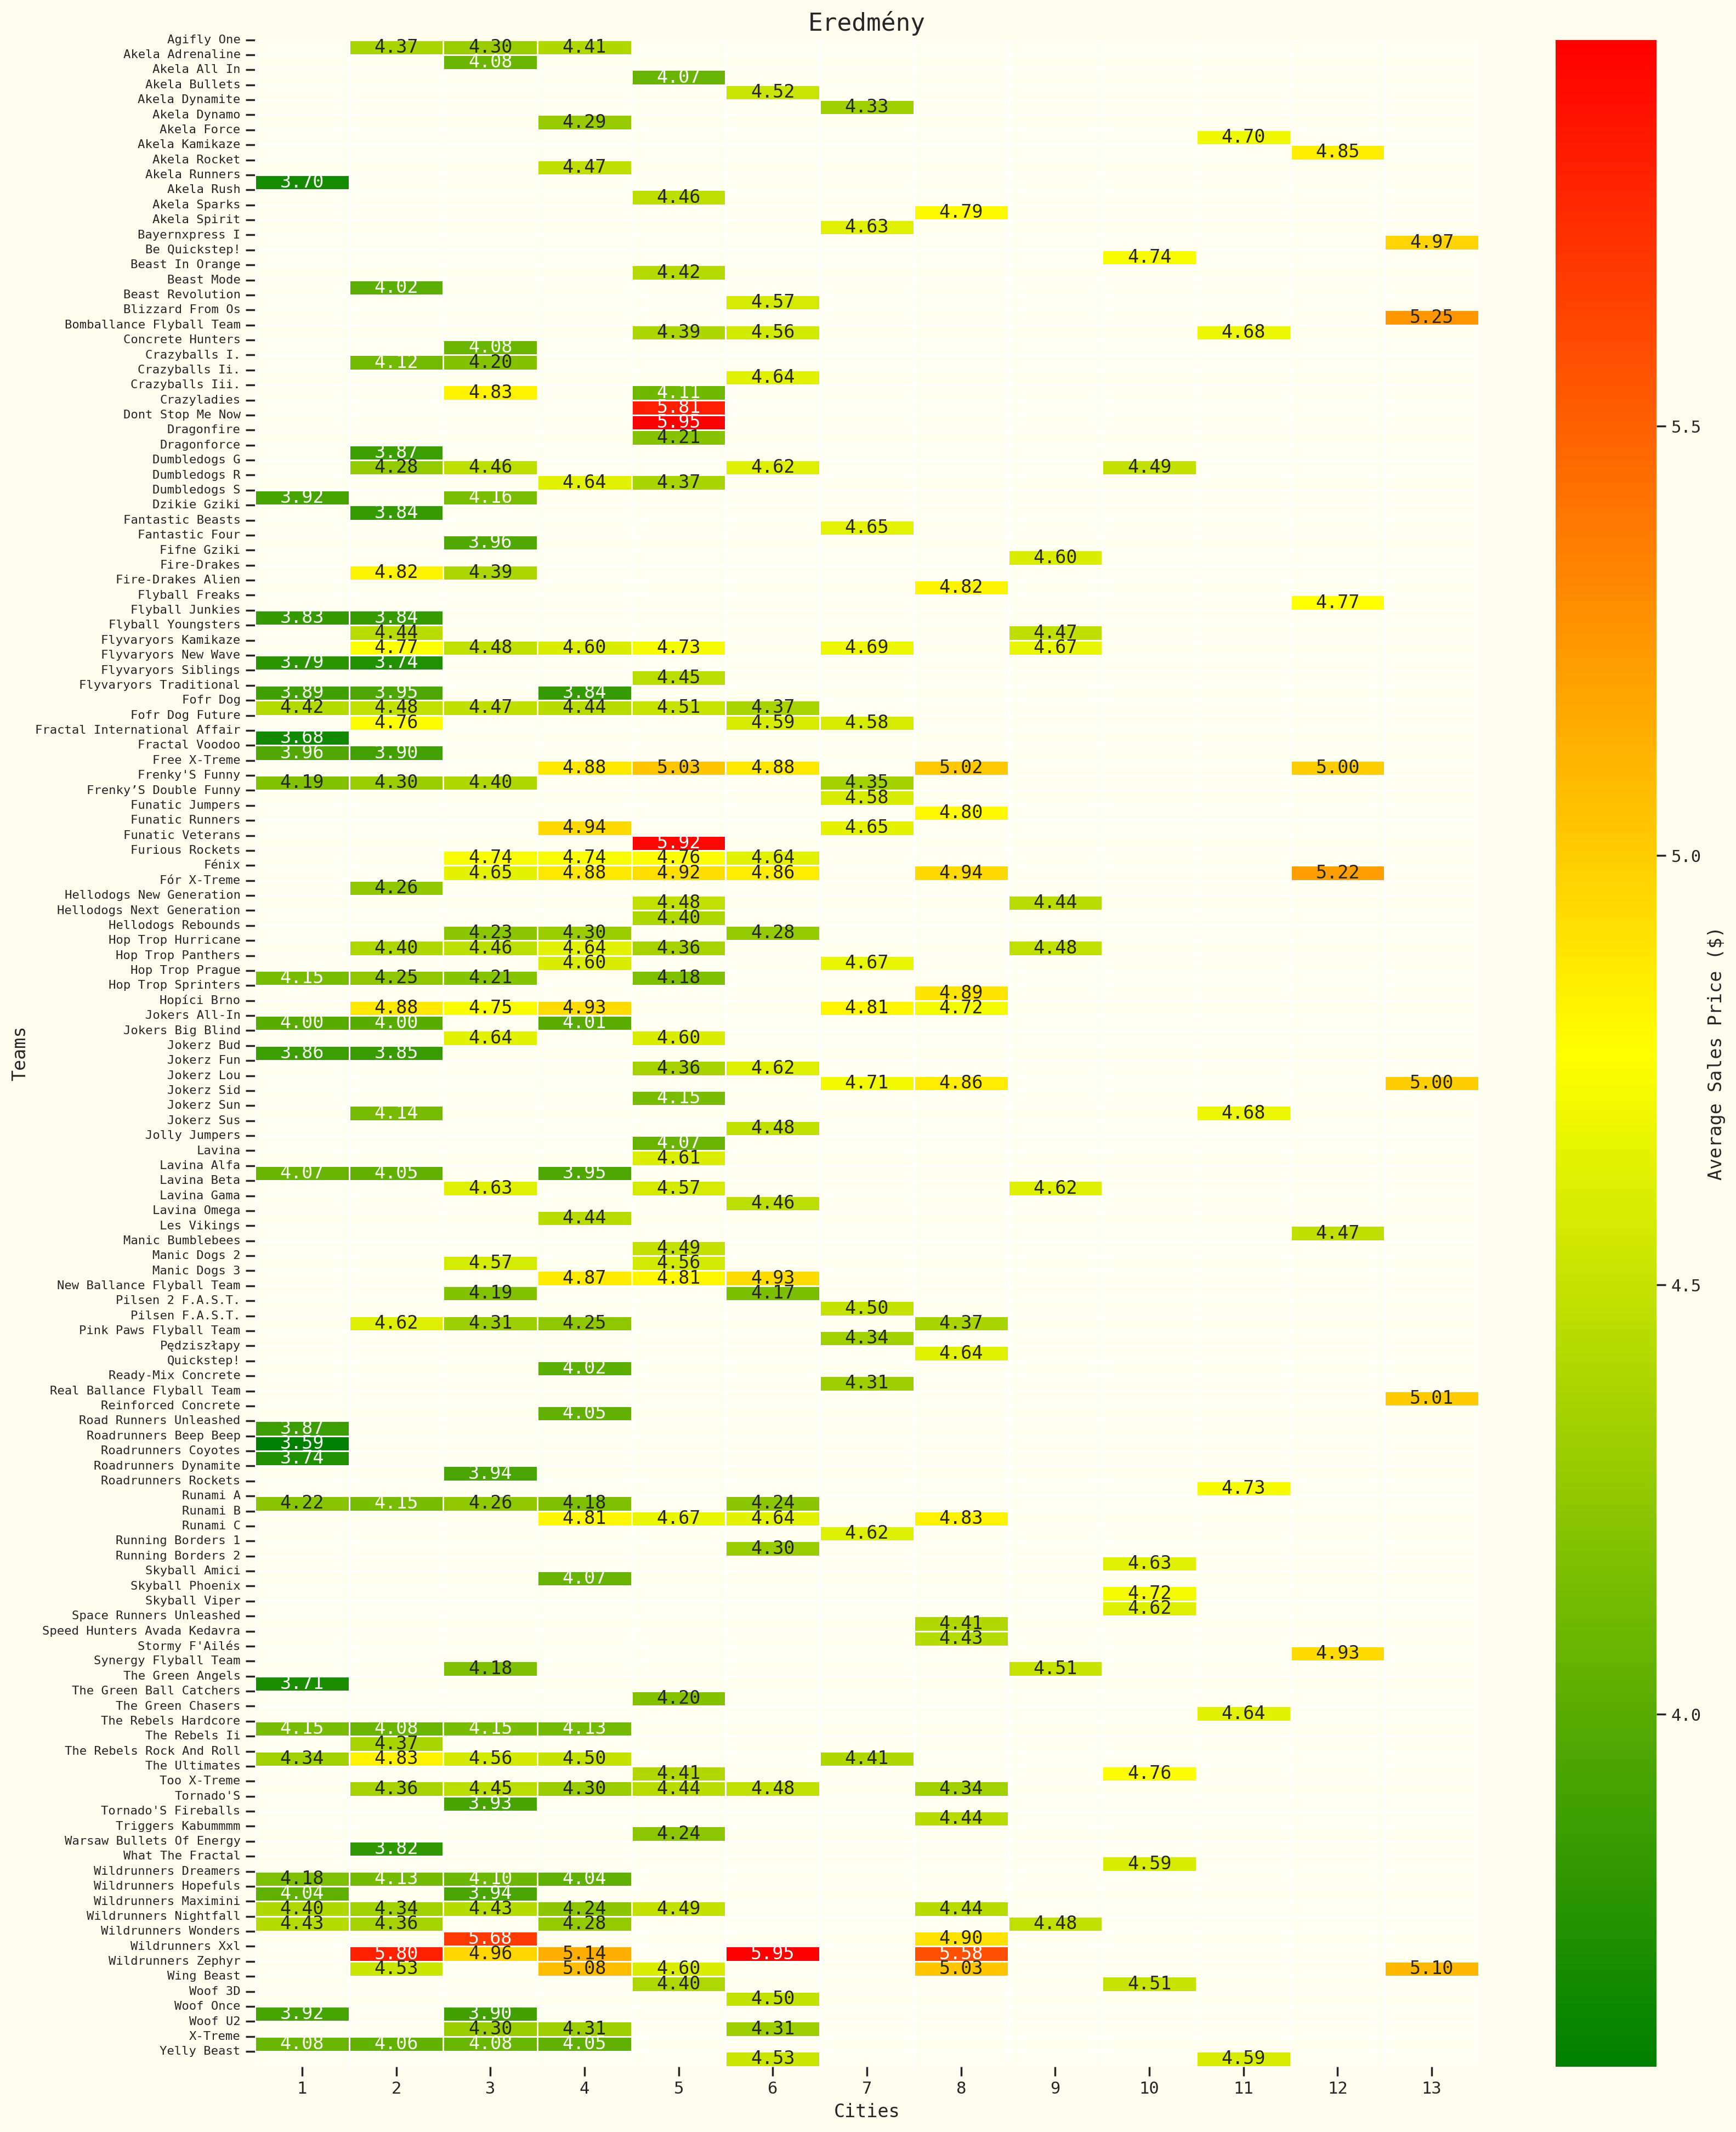

In [450]:
# Create pivot table to analyze average sale price by neighborhood and number of bedrooms
pivot_table = df.pivot_table(values='time',
                                         index='who',
                                         columns='Division',
                                         aggfunc='mean').round(2)
# Fill missing values (combination not exist) with 0 to avoid seeing NaN
pivot_table = pivot_table.fillna(0)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"]) # Mask for "zero" values to be colored with a different shade
mask = pivot_table == 0
# Set the size of the plot
plt.figure(figsize=(18, 24))
# Create a heatmap with the mask
sns.heatmap(pivot_table,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    linewidths=.9,
    mask=mask,
    cbar_kws={'label': 'Average Sales Price ($)'})
# Adding title and labels for clarity
plt.title('Eredmény', fontsize=16)
plt.xlabel('Cities', fontsize=12)
plt.ylabel('Teams', fontsize=12)
plt.yticks(ticks=range(len(pivot_table.index)), labels=pivot_table.index, fontsize=8)
# Display the heatmap
plt.show()

In [404]:
df.query("who.str.contains('Wildrunners', case=False)")

city        race_name        date      when Division  \
0             Heroltice  Hanácké škvarek  2023-04-22  10:11:57        1   
1             Heroltice  Hanácké škvarek  2023-04-22  10:11:57        1   
2             Heroltice  Hanácké škvarek  2023-04-22  10:11:57        1   
3             Heroltice  Hanácké škvarek  2023-04-22  10:11:57        1   
4             Heroltice  Hanácké škvarek  2023-04-22  10:11:57        1   
...                 ...              ...         ...       ...      ...   
32843  Tápiószentmárton     EFC - Ring 2  2023-07-30  10:23:49        8   
32848  Tápiószentmárton     EFC - Ring 2  2023-07-30  10:24:43        8   
32849  Tápiószentmárton     EFC - Ring 2  2023-07-30  10:24:43        8   
32850  Tápiószentmárton     EFC - Ring 2  2023-07-30  10:24:43        8   
32851  Tápiószentmárton     EFC - Ring 2  2023-07-30  10:24:43        8   

                        who  total_time W/L/T Hurdles     name  start  time  \
0      Wildrunners Dreamers       17.01     L    25.0    Sunny  -0.24  4.21   
1      Wildrunners Dreamers       17.01     L    25.0    Dixie   0.30  4.24   
2      Wildrunners Dreamers       17.01     L    25.0     Alex   0.16  4.22   
3      Wildrunners Dreamers       17.01     L    25.0   Hector   0.00  4.13   
4      Wildrunners Maximini       19.43     L    25.0   Brooke  -0.11  4.08   
...                     ...         ...   ...     ...      ...    ...   ...   
32843  Wildrunners Maximini       22.25     W    27.5   Bailey   3.18  4.49   
32848  Wildrunners Maximini       22.34     L    27.5  Cookies   0.10  3.85   
32849  Wildrunners Maximini       22.34     L    27.5    Mason   1.59  4.82   
32850  Wildrunners Maximini       22.34     L    27.5    Fleur   0.32  4.44   
32851  Wildrunners Maximini       22.34     L    27.5   Bailey   2.69  4.54   

       error  anomaly  w_pair ordinal_no  \
0       True    False   False          1   
1      False    False   False          2   
2      False    False   False          3   
3      False    False   False          4   
4       True    False   False          1   
...      ...      ...     ...        ...   
32843  False    False   False          4   
32848  False    False   False          1   
32849  False    False   False          2   
32850  False    False   False          3   
32851  False    False   False          4   

                                          dogs szin  start_error  time_error  
0         ['Sunny', 'Dixie', 'Alex', 'Hector']    0         True       False  
1         ['Sunny', 'Dixie', 'Alex', 'Hector']    0        False       False  
2         ['Sunny', 'Dixie', 'Alex', 'Hector']    0        False       False  
3         ['Sunny', 'Dixie', 'Alex', 'Hector']    0        False       False  
4         ['Brooke', 'Rocky', 'Bella', 'Bree']    1         True       False  
...                                        ...  ...          ...         ...  
32843  ['Cookies', 'Mason', 'Fleur', 'Bailey']    1        False       False  
32848  ['Cookies', 'Mason', 'Fleur', 'Bailey']    1        False       False  
32849  ['Cookies', 'Mason', 'Fleur', 'Bailey']    1        False       False  
32850  ['Cookies', 'Mason', 'Fleur', 'Bailey']    1        False       False  
32851  ['Cookies', 'Mason', 'Fleur', 'Bailey']    1        False       False  

[4456 rows x 20 columns]

In [417]:
df['Wildrunners'] = df['who'].str.contains('Wildrunners', case=False).astype(int)

## 1.2 Szűrés csak a WildRunners csapat adataira

In [17]:
WR = df[df['who'].str.contains('Wildrunners', case = False)].reset_index(drop=True)

In [18]:
WR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456 entries, 0 to 4455
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        4456 non-null   object 
 1   race_name   4456 non-null   object 
 2   date        4456 non-null   object 
 3   when        4456 non-null   object 
 4   Division    4456 non-null   int64  
 5   who         4456 non-null   object 
 6   total_time  4456 non-null   float64
 7   W/L/T       4456 non-null   object 
 8   Hurdles     4456 non-null   float64
 9   name        4440 non-null   object 
 10  start       4456 non-null   float64
 11  time        4456 non-null   float64
 12  error       4456 non-null   bool   
 13  anomaly     4456 non-null   bool   
 14  w_pair      4456 non-null   bool   
 15  ordinal_no  4456 non-null   int64  
 16  dogs        4456 non-null   object 
 17  szin        4456 non-null   int64  
dtypes: bool(3), float64(4), int64(3), object(8)
memory usage: 535.4+ KB


Véltozókkal kapcsolatos leírások:
http://simp.ly/p/xp7nr8

In [19]:
# Mielőtt adattiszításhoz átalakítanám a df-et, két oszlopt felveszek, amelyek a hibát jelölik
WR['start_error'] = WR['start'].apply(lambda x : True if x < 0 or x == 999 else False)
WR['time_error'] = WR['time'].apply(lambda x : True if x == 999 else False)

In [20]:
# Mivel a vizuális áttekintés során a 999 érték nem túl hasznos, így Nan értékké alakítom vissza
WR_cleaned = WR.replace(999, np.nan)

In [21]:
# Táblázatos formába alakítom át a statisztikát, kiemelve a szórást és az 50%-os értéket, ami számomra egy gyorsabb pillanatképet ad
WR_cleaned.describe().T.style.bar(subset=['mean'], color='#37718E')\
                            .background_gradient(subset=['std'], cmap=cmap)\
                            .background_gradient(subset=['50%'], cmap=cmap)

## 2.0 Adattisztítás 2.0

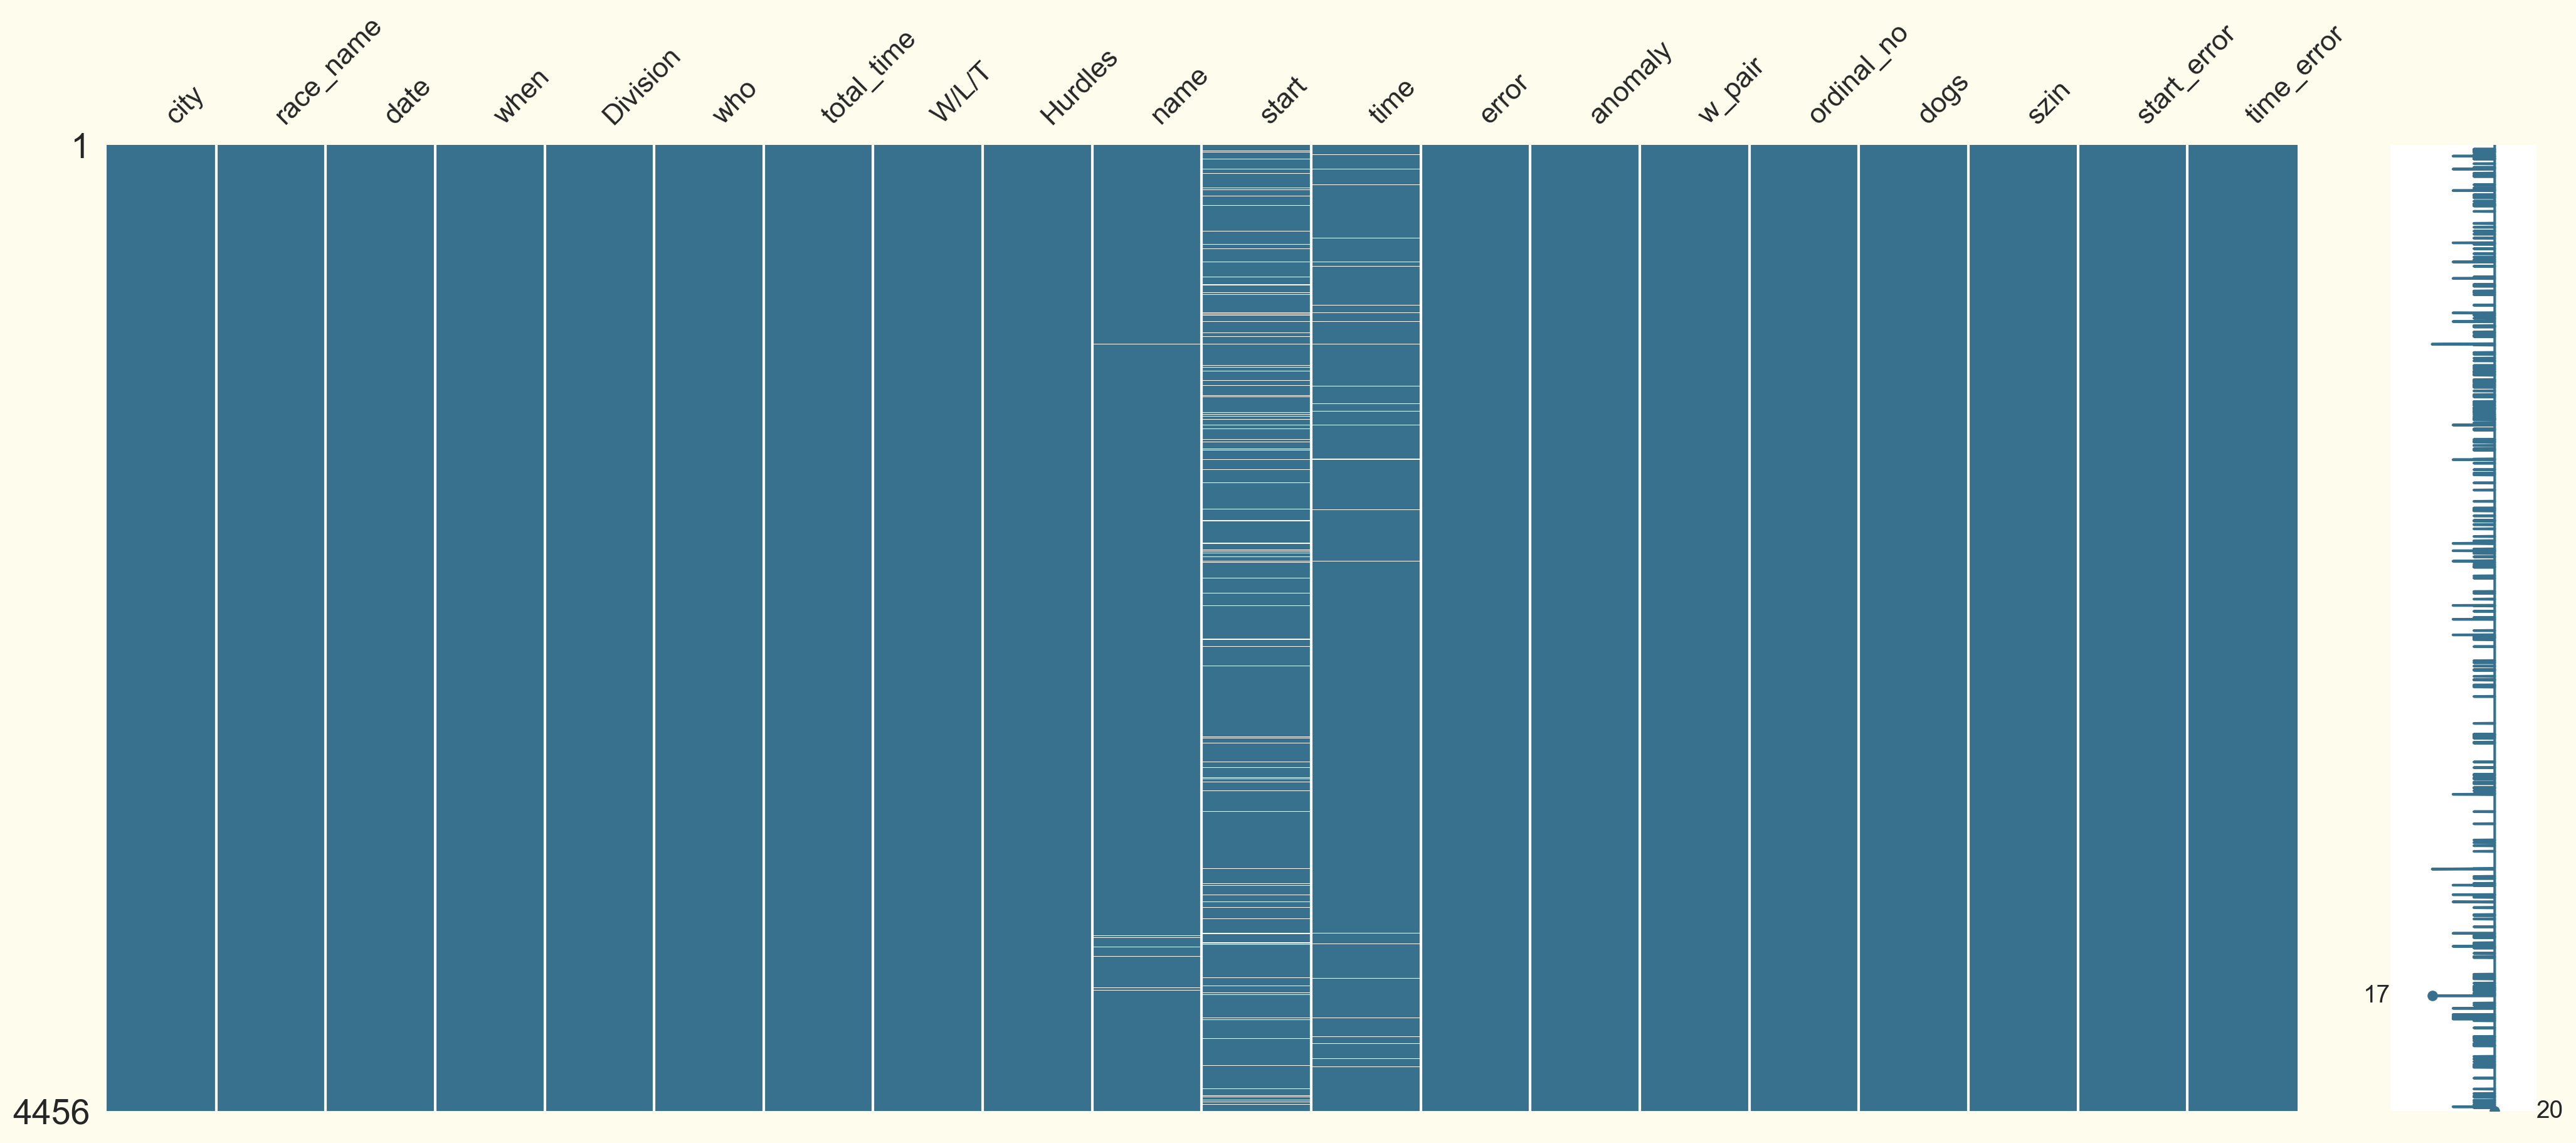

In [22]:
# Nézzük vizuálisan a null értékek helyzetét
msno.matrix(WR_cleaned, color=light_palette[4])
plt.show()

Az üres neveket el fogom dobni, de a start és time helyeken egyelőre megtartom a null értékeket, mivel a feltöltését ebben a pontban még nem érzem hasznosnak az elemzés szempontjából. Azt tudnám tenni, hogy feltöltöm ezeket az időket az adott kutya átlagával, mint talán legjobb megoldás, ám ezen még gondolkodom, és ha látom ennek előnyét, akkor visszatérek ide.

In [23]:
# Számosság tekintetében ugyan ez az információ
WR_cleaned.isnull().sum()

city             0
race_name        0
date             0
when             0
Division         0
who              0
total_time       0
W/L/T            0
Hurdles          0
name            16
start          296
time            80
error            0
anomaly          0
w_pair           0
ordinal_no       0
dogs             0
szin             0
start_error      0
time_error       0
dtype: int64

In [24]:
# Eldobok minden olyan sort, ahol null értékem van a name változóban, azaz nem tudom azonosítani a kutyát
WR_cleaned.dropna(subset=['name'], inplace = True)
WR_cleaned.reset_index(drop=True, inplace=True)

### 2.1 Az akadályok áttekintése

In [25]:
# A két doksi alapján ezek az elgadott méretek, nincs 32.5 és 35 ...
['15', '17.5', '20', '22.5', '25', '27,5', '30']

['15', '17.5', '20', '22.5', '25', '27,5', '30']

In [26]:
# 32.5-es érték nincsen, ezért ezeket meg kell vizsgálni a két df-ben, majd átalakítani megfelelően
WR_cleaned['Hurdles'].value_counts().sort_index()

Hurdles
15.0     464
20.0     151
22.5     200
25.0    1978
27.5    1519
30.0     116
32.5      12
Name: count, dtype: int64

In [27]:
dogs['ugrasi_magassag'].value_counts().sort_index()

ugrasi_magassag
15.0     2
20.0     2
22.5     2
25.0     7
27.5    14
30.0    10
32.5    14
Name: count, dtype: int64

Miután azt feltételezem, hogy ezek adatrögzítési hibák, és a valóságban nem ilyen magasságon futottak a kutyák, ezért alapfeltételezésem szerint átalakítom a legmagasabb jóváhagyott akadályokra ezeket, ám normál esetben ezt jó lenne átbeszélni

In [28]:
# Mivel a fentiek szerint nincsenek ilyen méretek, így 32.5-et 30-ra alakítom át
WR_cleaned['Hurdles'].replace(32.5, 30.0, inplace=True)

/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/1392585123.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  WR_cleaned['Hurdles'].replace(32.5, 30.0, inplace=True)


In [29]:
dogs['ugrasi_magassag'].replace(32.5, 30.0, inplace=True)

/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/1465109410.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dogs['ugrasi_magassag'].replace(32.5, 30.0, inplace=True)


### 2.2 Van-e duplikált sorom?

In [30]:
WR_cleaned[WR_cleaned.duplicated()]

Empty DataFrame
Columns: [city, race_name, date, when, Division, who, total_time, W/L/T, Hurdles, name, start, time, error, anomaly, w_pair, ordinal_no, dogs, szin, start_error, time_error]
Index: []

Elsőre úgy látom, hogy két azonos sorom nincsen, de egy kicsit alacsonyabb szinten is szeretem megvizsgálni a duplukációkat, így bizonyos változók együttállását is annak tekintem.

In [31]:
# Itt azt vizsgálom, hogy van-e olyan időpont és kutya, aki egy időben futott volna, mert azt is duplikációnak tekinteném
dupla_futas = WR_cleaned.groupby(['date', 'when', 'name'])['time'].count().reset_index().sort_values('time', ascending=False)

In [32]:
dupla_futas[dupla_futas['time'] > 1]

date      when   name  time
105  2023-04-22  10:13:25  Bella     2
106  2023-04-22  10:13:25   Bree     2
111  2023-04-22  10:13:25  Rocky     2

Érdekes módon van egy olyan eset, amikor a kutya kétszer is futott az adott pillanatban ám mégis más eredmény tartozik a futásához. Ezt mindenképp egyeztetni kellene normál esetben, hogy mi lehet ennek az oka..

In [33]:
WR_cleaned[(WR_cleaned['name'] == 'Bella') & (WR_cleaned['when'] == '10:13:25')].index

Index([14, 391], dtype='int64')

Egy példa a fenti anomáliára

Egy másik érdekes eset, hogy vannak olyan futások, amelyek ugyan más napokon történtek, ám mégis az adott kutya pontosan azonos időpontban versenyzett (megjegyzem, hogy mivel más sorszámmal indult, nem teljesen azonos a futási ideje illetve tartalmazza a fenti anomáliát is)

In [34]:
# Itt azt vizsgálom, hogy van-e olyan időpont és kutya, aki egy időben futott volna, mert azt is duplikációnak tekinteném
dupla_ido = WR_cleaned.groupby(['when', 'name'])['time'].count().reset_index().sort_values('time', ascending=False)

In [35]:
dupla_ido[dupla_ido['time'] > 1]

when    name  time
1681  11:31:27    Hank     2
1797  11:47:47    Bree     2
822   10:13:25    Bree     2
827   10:13:25   Rocky     2
821   10:13:25   Bella     2
3298  14:50:49   Bella     2
783   10:10:45   Dixie     2
742   10:08:22  Bonnie     2
1677  11:31:27    Abby     2
3304  14:50:49    Sara     2
1796  11:47:47   Bella     2

Egy példa a fenti anomáliára

In [36]:
WR_cleaned[(WR_cleaned['name'] == 'Hank') & (WR_cleaned['when'] == '11:31:27')]

city          race_name        date      when  Division  \
1595  Prostějov  BCCCZ mistrovství  2023-06-24  11:31:27         2   
2238       Nové          Crazy Cup  2023-07-01  11:31:27         5   

                     who  total_time W/L/T  Hurdles  name  start  time  error  \
1595  Wildrunners Zephyr       19.59     L     25.0  Hank   0.50  4.47  False   
2238  Wildrunners Zephyr       19.19     L     27.5  Hank   0.19  4.62  False   

      anomaly  w_pair  ordinal_no                               dogs  szin  \
1595    False   False           2  ['Brix', 'Hank', 'Bella', 'Abby']     0   
2238    False   False           1  ['Hank', 'Alex', 'Mason', 'Abby']     0   

      start_error  time_error  
1595        False       False  
2238        False       False

Van egy anomaly oszlopom, ezért az első esetet mindeképp jelölöm arra az esetre, ha később ezt ki szeretném szűrni

## 2.3 WR Numerikus változók vizsgálata - Outlier-ek

Az outlierek elemzése nagyon fontos része az adatok ellenőrzésének, hiszen ezek a nagy halmaztól erősen eltérő esetek adott esetben új információval rendelkezhetnek, de éppen úgy lehetséges az is, hogy adatgyűjtési hiba miatt kerültek az adatok közé.

In [37]:
WR_cleaned.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

A fentiek alapján a következő észrevételem van elsőre:

- total_time - látszik túl alacsony és kiugró érték, de egyelőre ez az oszlop nem kiemelt, hiszen újra kell majd generálni a total_time-ot
- start - vannak negatív indítások, őket hibaként kezelem, de meghagyom, illetve extrém magas értékek, itt lehet adatgyűjtési hiba van
- time - elsőre a 3.02 érdekes, hiszen világrekord lenne, felfelé 15.32 inkább valami futási hiba, nem tizedes probléma

In [38]:
WR_cleaned.columns

Index(['city', 'race_name', 'date', 'when', 'Division', 'who', 'total_time',
       'W/L/T', 'Hurdles', 'name', 'start', 'time', 'error', 'anomaly',
       'w_pair', 'ordinal_no', 'dogs', 'szin', 'start_error', 'time_error'],
      dtype='object')

In [39]:
# Szétválasztom numerikus változókra
# numerikus változók
num_columns = [column for column in WR_cleaned.columns if WR_cleaned[column].dtype in ['float64', 'int64']]

In [40]:
num_columns

['Division', 'total_time', 'Hurdles', 'start', 'time', 'ordinal_no', 'szin']

A total_time esetén azt tudjuk, hogy nem mindig egyezik az idők összegével, vannak "láthatatlan" futások, így nem tudok erre az oszlopra hagyatkozni az elemzés során.
A Division, ordinal_no és szin kategórikus változók, ezeket később átalakítom

In [41]:
# Elsősorban most az alábbi két változó kapcsán viszgálom az outlier értékeket
num_columns = ['start', 'time']

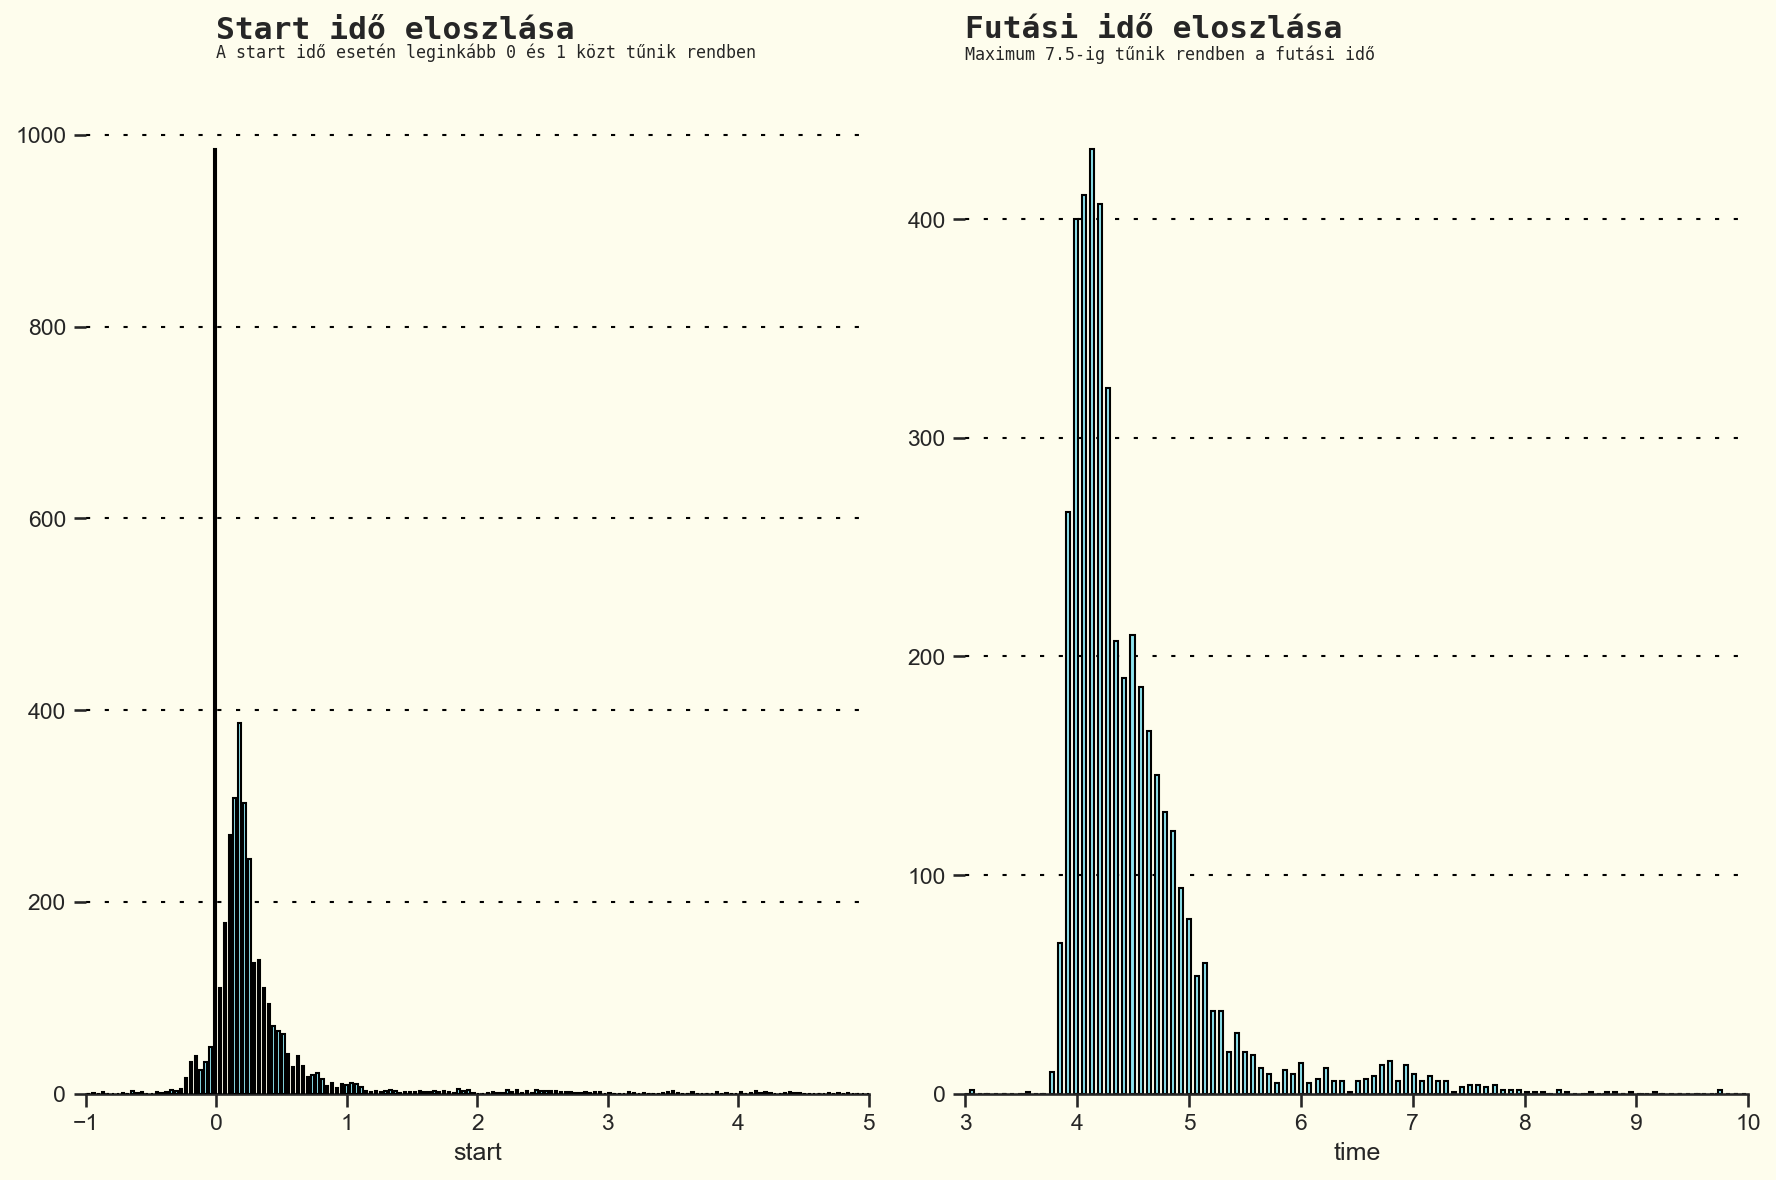

In [42]:
fig = plt.figure(figsize=(12,8), dpi=150)
gs = fig.add_gridspec(1,2)
ax = [None for _ in range(2)]
background_color = "#FEFDED"
fig.patch.set_facecolor(background_color) # figure background color

ax[0] = fig.add_subplot(gs[0,0])
ax[1] = fig.add_subplot(gs[0,1])
ax[0].set_facecolor(background_color) # axes background color
ax[1].set_facecolor(background_color)

ax[0].text(0,1100,'Start idő eloszlása',fontsize=15,fontweight='bold', fontfamily='monospace')
ax[0].text(0,1080,'A start idő esetén leginkább 0 és 1 közt tűnik rendben',fontsize=8,fontweight='light', fontfamily='monospace')

ax[1].text(3,483, 'Futási idő eloszlása',fontsize=15,fontweight='bold', fontfamily='monospace')
ax[1].text(3,473,'Maximum 7.5-ig tűnik rendben a futási idő',fontsize=8,fontweight='light', fontfamily='monospace')

sns.histplot(x=WR_cleaned['start'],ax=ax[0], color='#8EE3EF', alpha=1,zorder=3,linewidth=1,edgecolor='black', shrink=0.5)
sns.histplot(x=WR_cleaned['time'],ax=ax[1], color='#8EE3EF', alpha=1,zorder=2,linewidth=1,edgecolor='black',shrink=0.5)

for i in range(2):
    ax[i].set_ylabel('')
    ax[i].grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)

ax[0].set_xlim(-1,5)
ax[1].set_xlim(3,10)
        
plt.tight_layout()

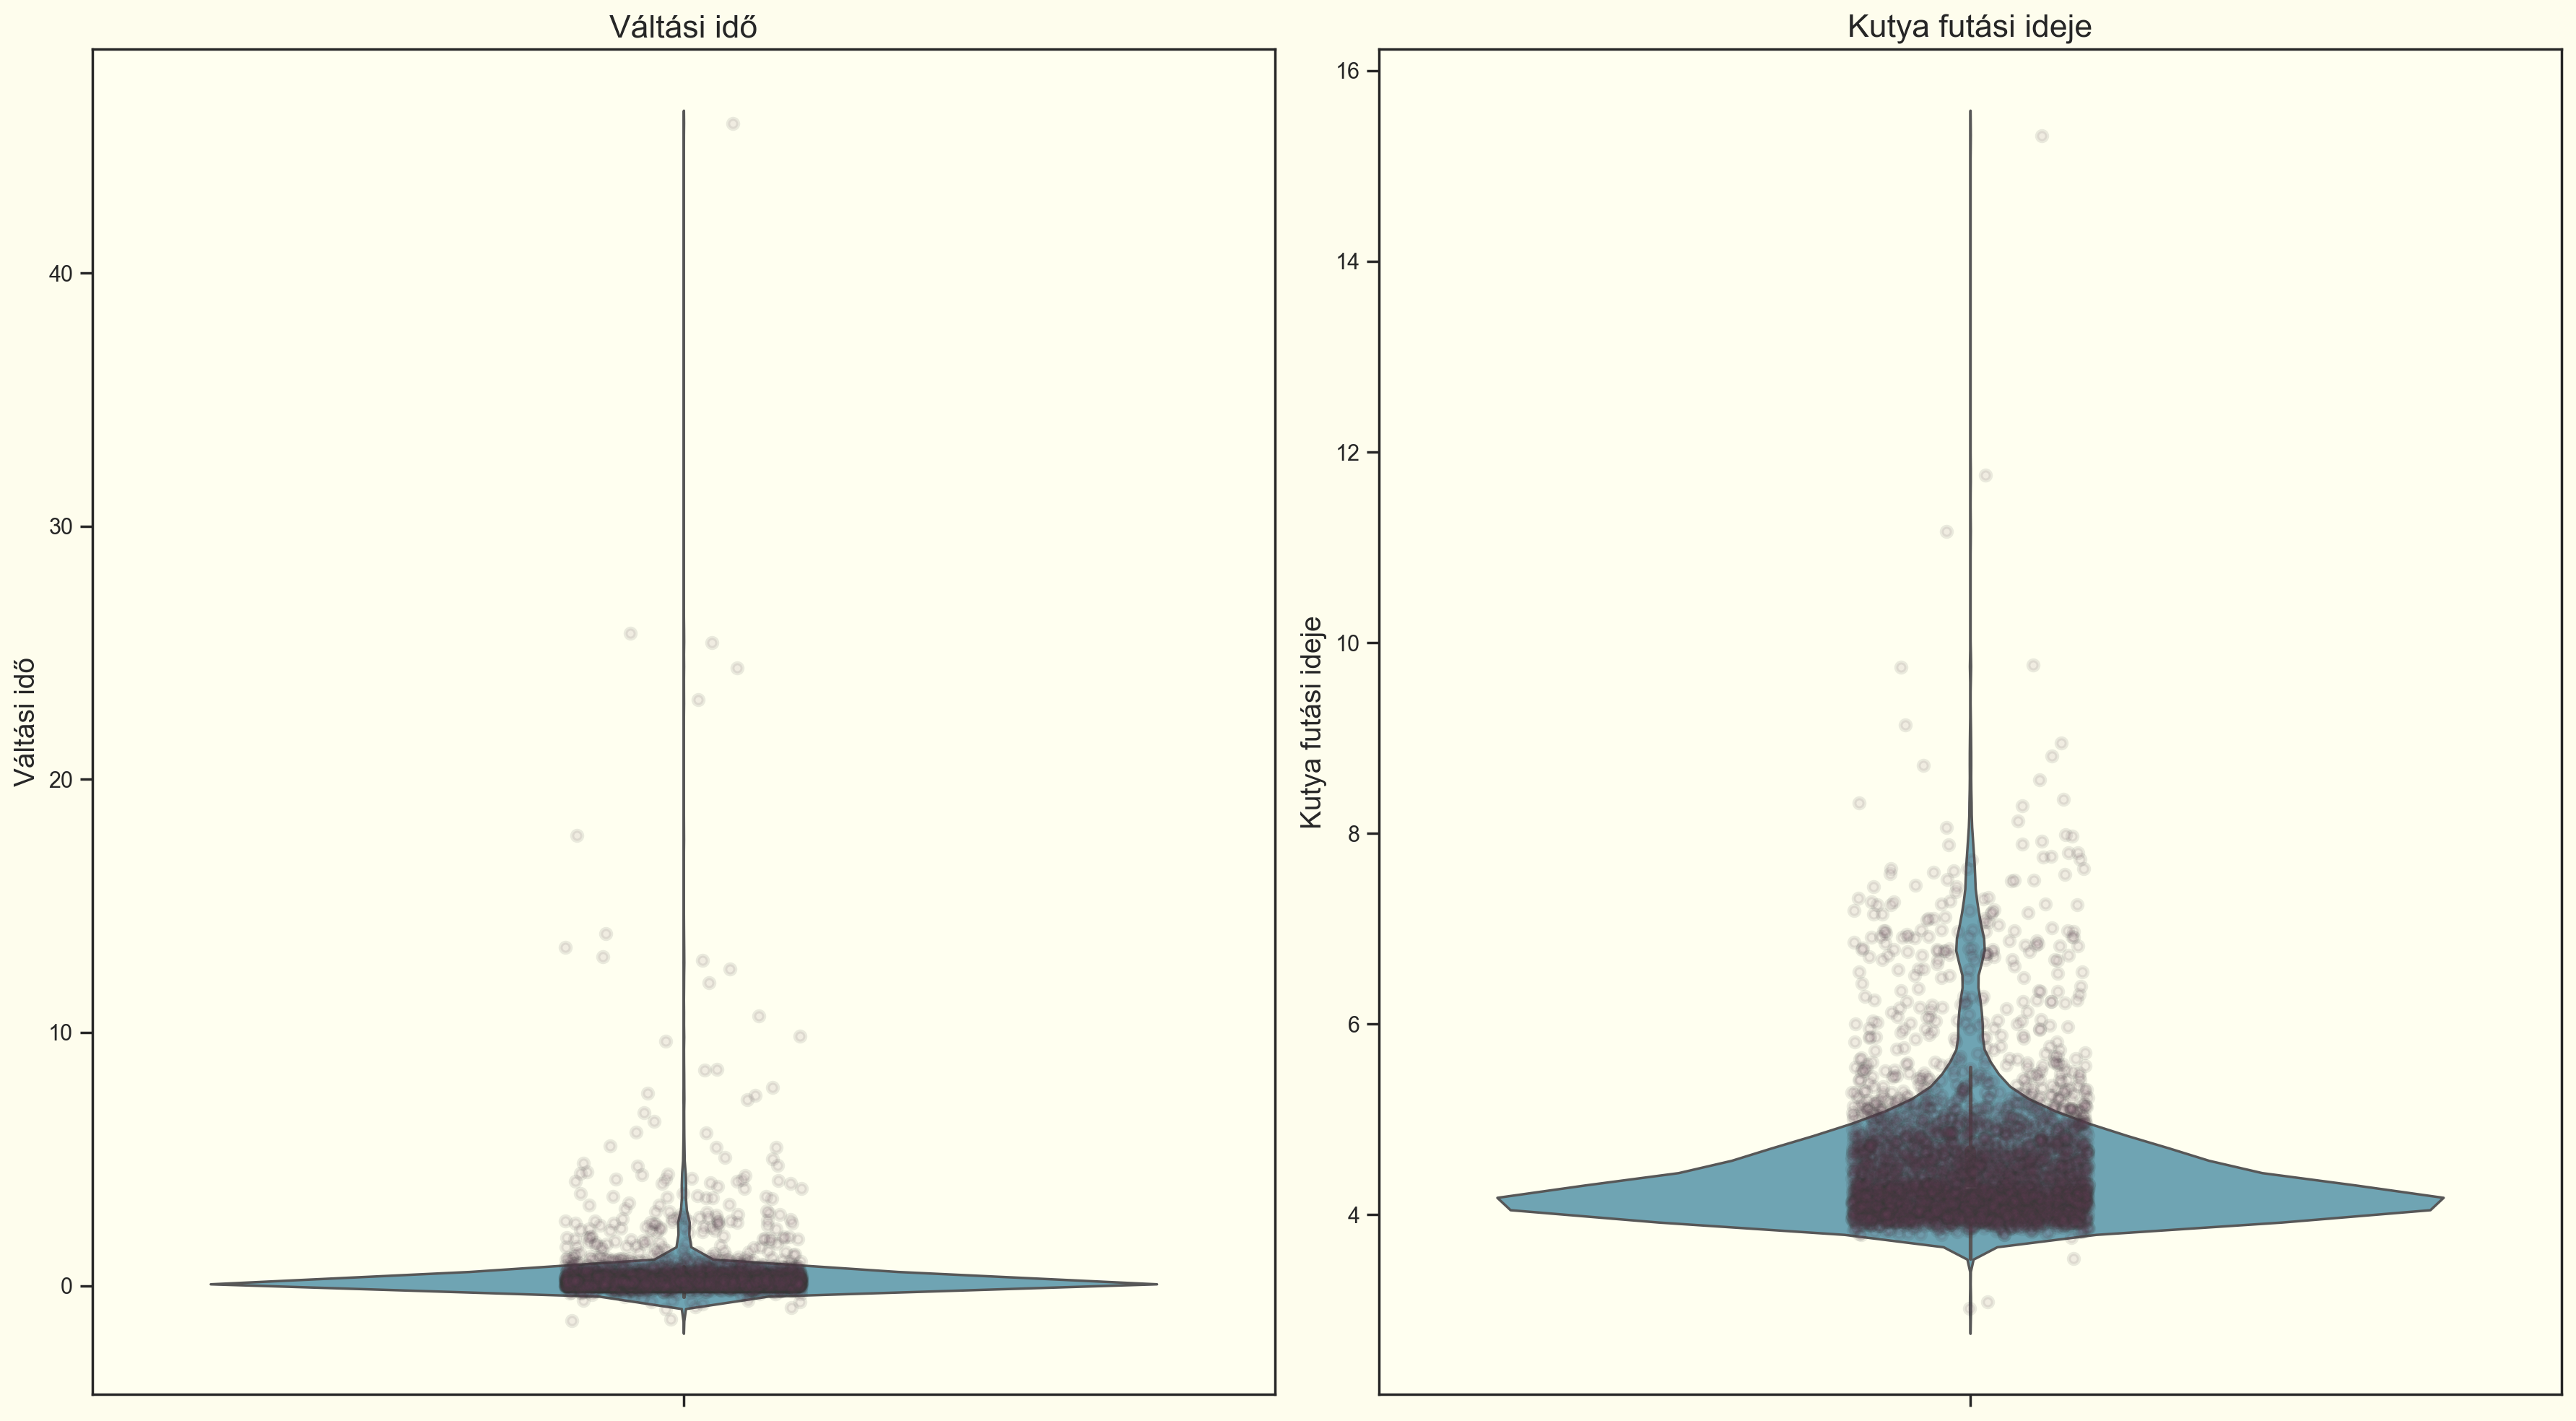

In [43]:
feature_names_full = {
    'start': 'Váltási idő',
    'time': 'Kutya futási ideje'
}
num_outliers(WR_cleaned, num_columns, feature_names_full)

Nézzük most azt, hogy mit mesél nekünk egyenként most a két változó, ötvözve azzal a fenti képet is

In [44]:
WR_cleaned['start'].describe()

count    4149.000000
mean        0.345617
std         1.362376
min        -1.370000
25%         0.000000
50%         0.150000
75%         0.300000
max        45.910000
Name: start, dtype: float64

In [45]:
WR_cleaned['start'].quantile([0.25, .5, .75, .9, .95, 0.96, .99])

0.25    0.0000
0.50    0.1500
0.75    0.3000
0.90    0.5800
0.95    0.9900
0.96    1.2408
0.99    4.1604
Name: start, dtype: float64

Ezekből számomra az látszik, a szabályok alapján is, hogy minden nulla alatti idő hibás, továbbá érzés alapján nekem 0 95-ös szintet meghúzva az 1mp-nél tovább tartó indulás is jelzés arra vonatkozólag, hogy valamilyen hiba lehet az indulással

In [46]:
WR_cleaned['start_outlier'] = WR_cleaned['start'].apply(
    [lambda x: 1 if (x < 0) | (x > WR_cleaned['start'].quantile(0.95)) else 0]
)

In [47]:
WR_cleaned['time'].describe()

count    4364.000000
mean        4.497958
std         0.704540
min         3.020000
25%         4.080000
50%         4.280000
75%         4.670000
max        15.320000
Name: time, dtype: float64

In [48]:
# time esetén vannak 
WR_cleaned['time'].quantile([0.05, 0.25, .5, .75, .9, .95, 0.96, .99])

0.05    3.9300
0.25    4.0800
0.50    4.2800
0.75    4.6700
0.90    5.1300
0.95    5.7700
0.96    6.1248
0.99    7.2974
Name: time, dtype: float64

A time azaz futási idő esetén a minimum idő nagyon alacsonynak tűnik annak tekintetében, hogy a világcsúcs közeli idők is 3.5 körül vannak

In [49]:
WR_cleaned['time'].sort_values().head(10)

1573    3.02
3835    3.09
4367    3.54
4044    3.76
4090    3.79
4092    3.79
4082    3.79
1355    3.79
3946    3.80
1306    3.80
Name: time, dtype: float64

A fentiek alapján az első kettő számomra inkább outlier, a harmadik pedig egyeztetés tárgya lenne

In [50]:
WR_cleaned['outlier'] = WR_cleaned['time'].apply(
    [lambda x: 1 if (x < 3.54) | (x > WR_cleaned['time'].quantile(0.99)) else 0]
)

## 2.4 WR kategorikus változók elemzése

In [51]:
WR_cleaned.columns

Index(['city', 'race_name', 'date', 'when', 'Division', 'who', 'total_time',
       'W/L/T', 'Hurdles', 'name', 'start', 'time', 'error', 'anomaly',
       'w_pair', 'ordinal_no', 'dogs', 'szin', 'start_error', 'time_error',
       'start_outlier', 'outlier'],
      dtype='object')

In [52]:
# A when azaz futási mezőt kiveszem, mivel dokumentálás miatt nagyon sok sort eredményezne
# Ennek duplilációs lehetőségét külön vizsgálom

# cat_columns = ['city', 'race_name', 'date', 'when', 'Division', 'who', 'W/L/T', 'Hurdles', 'name', 'szin']
cat_columns = ['city', 'race_name', 'date', 'Division', 'who', 'W/L/T', 'Hurdles', 'name', 'szin']

In [53]:
for feature in cat_columns:
    print(f'A {feature} változó értékeinek eloszlása: {WR_cleaned[feature].value_counts()}')
    print(f'------------------------')

A city változó értékeinek eloszlása: city
Blšany              759
Prostějov           728
Heroltice           640
Nové                596
Žamberk             546
Litomyšl            347
Louňovice           300
Vodňany             288
Tápiószentmárton    236
Name: count, dtype: int64
------------------------
A race_name változó értékeinek eloszlása: race_name
BCCCZ mistrovství              728
Hanácké škvarek                640
Crazy Cup                      596
Eager´s Cup 1. ring            466
Mistrovství České republiky    451
Křupky na břehu                347
Flyvaryors turnaj              308
Máchale, spadlo ti to!         300
Budějckej xtreme 2. ring       288
EFC - Ring 2                   120
EFC - Ring 1                   116
Eager´s Cup 2. ring             80
Name: count, dtype: int64
------------------------
A date változó értékeinek eloszlása: date
2023-06-24    728
2023-04-22    640
2023-07-01    596
2023-05-06    546
2023-09-03    451
2023-09-16    347
2023-05-20    308


A fentiekből kicsit mélyebben a kutyák érdekelnek, illetve pár változó, amely talán kicsit jobban leírja a képet

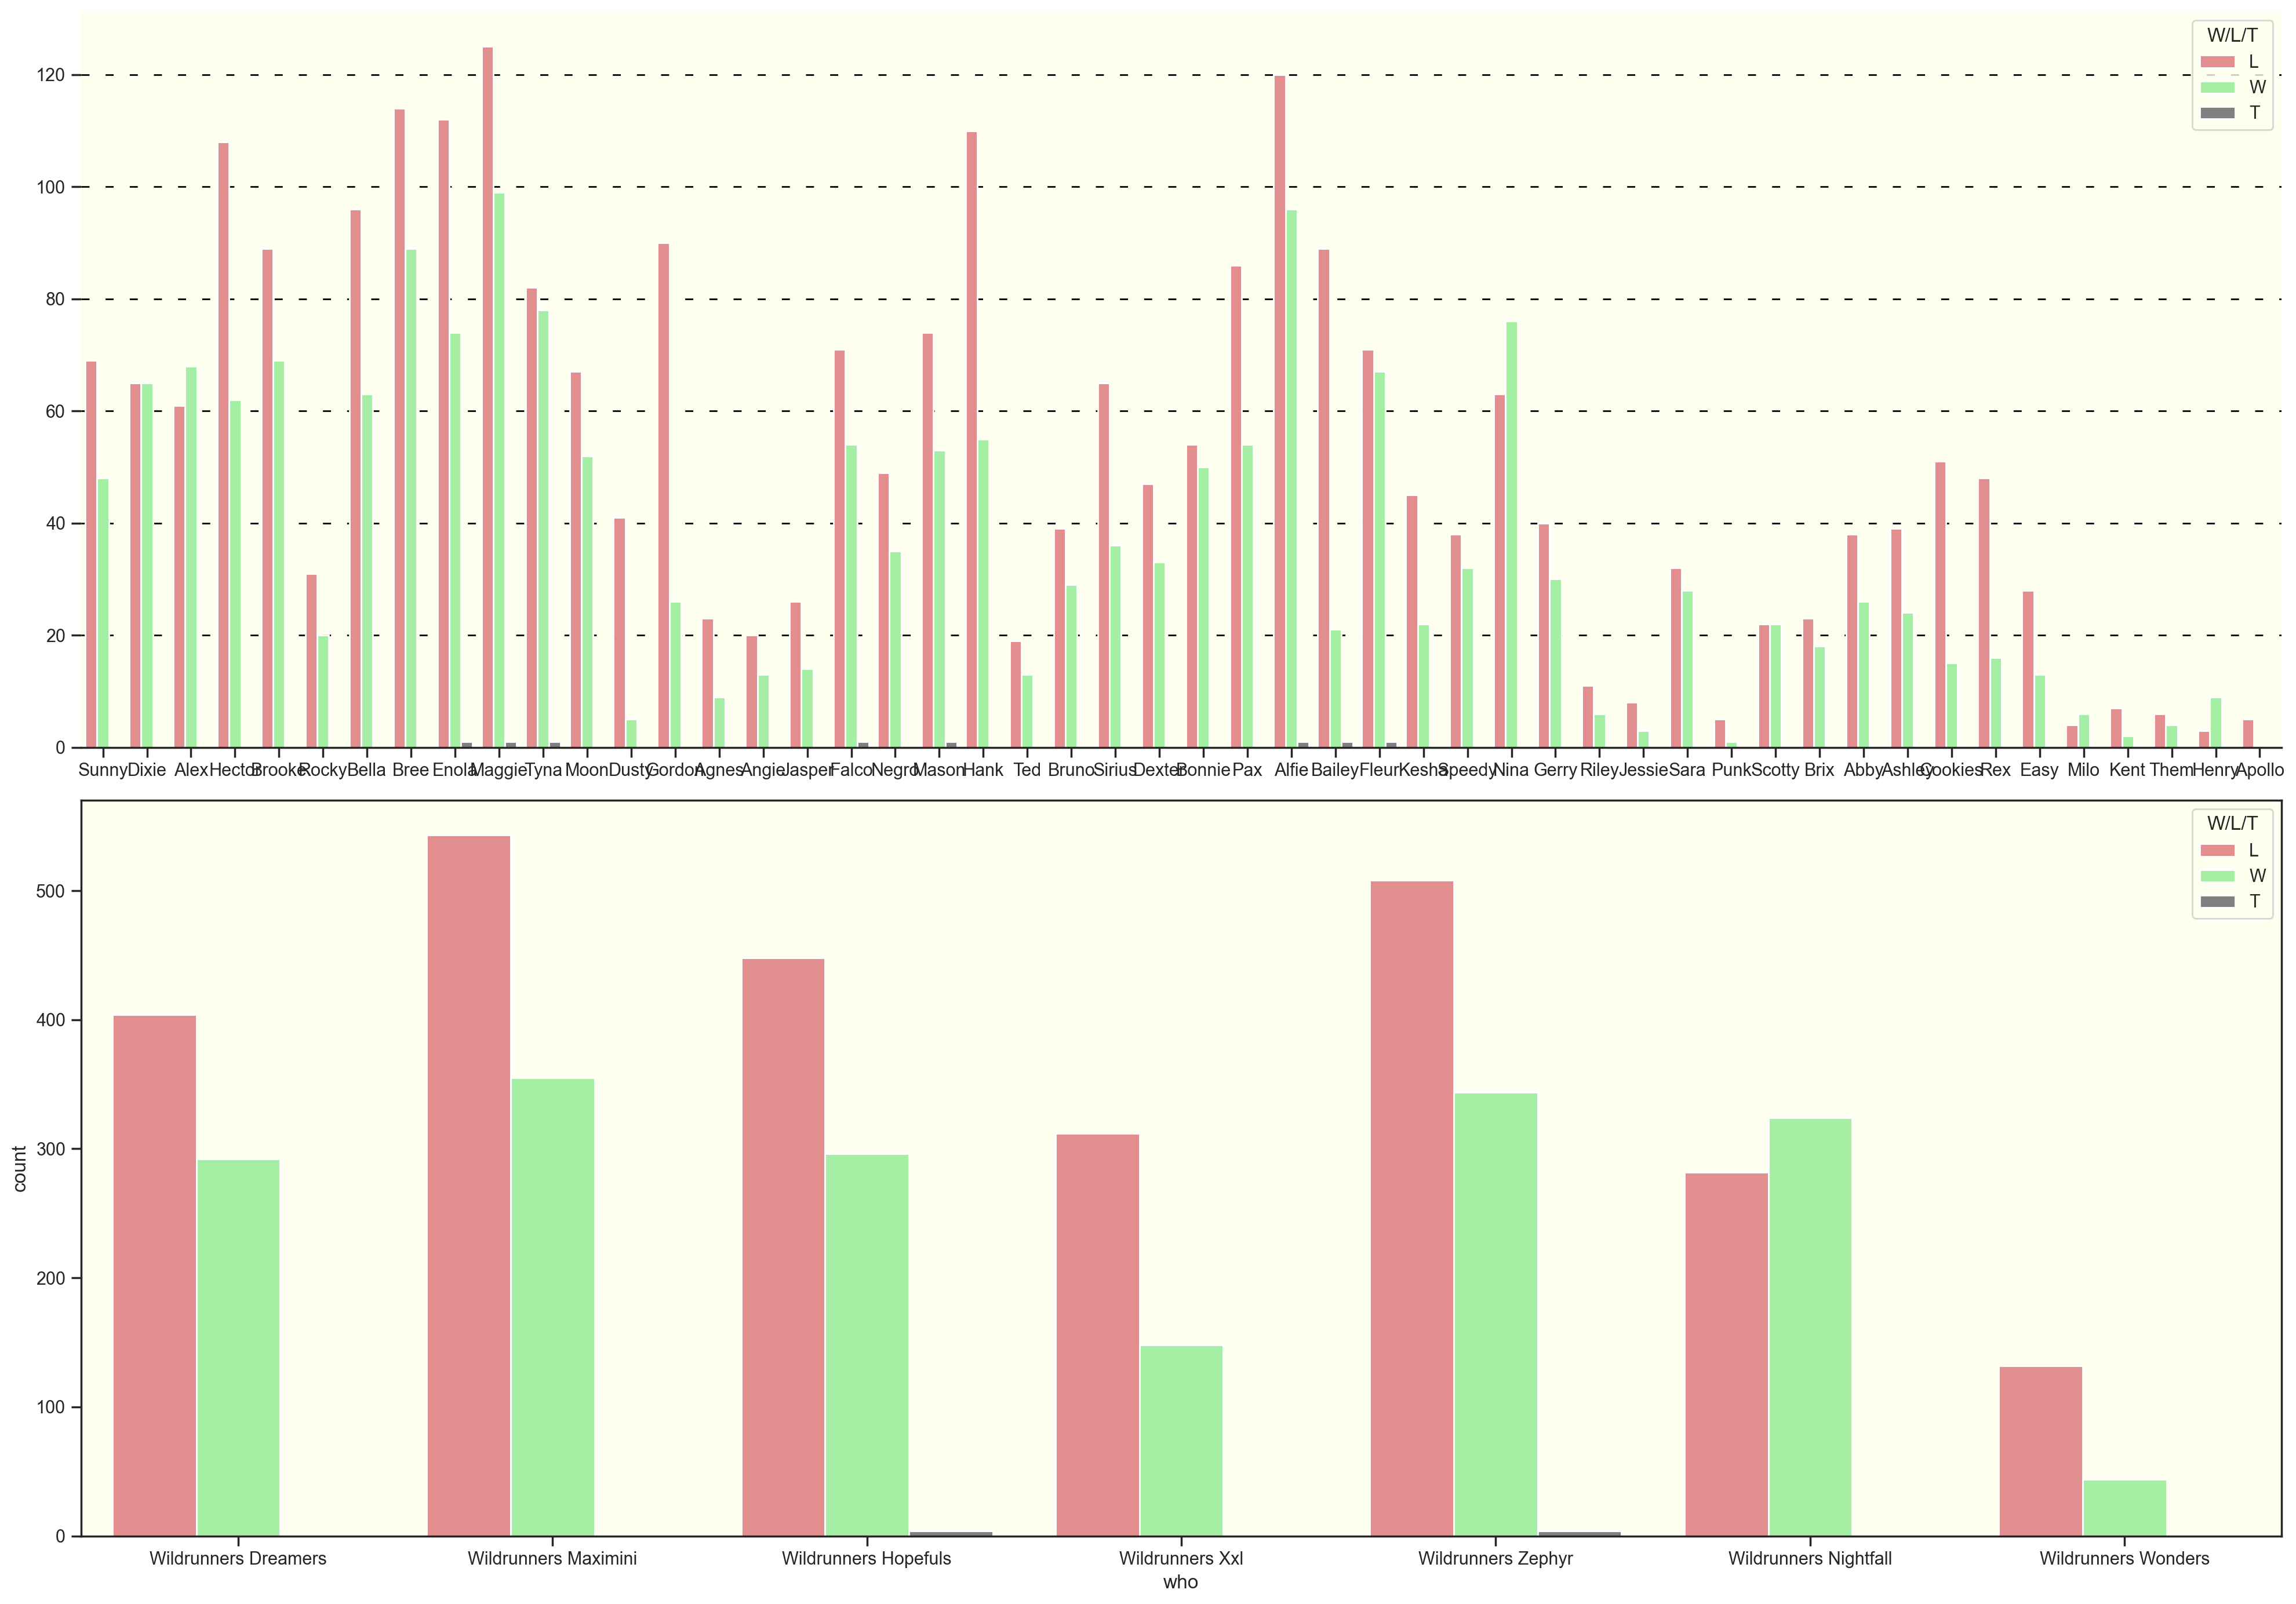

In [54]:
fig=plt.figure(figsize=(20,14),facecolor='white')

gs=fig.add_gridspec(2,1)

ax=[None for _ in range(2)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[1,0])

palette2=["lightcoral", "palegreen", "grey"]

sns.countplot(data=WR_cleaned,x='name',ax=ax[0],hue='W/L/T',zorder=2,palette=palette2)
sns.countplot(data=WR_cleaned,x='who',ax=ax[1],hue='W/L/T',zorder=2,palette=palette2)

for i in range(1):
    ax[i].grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(5,10))
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)
    #ax[0].set_xticklabels(WR_cleaned['name'], fontfamily='serif', rotation=90)
    #ax[1].set_xticklabels(WR_cleaned['who'], fontfamily='serif', rotation=90)
plt.tight_layout()

Kutyák esetén elsőre az látható, hpgy többségében kiegyensúlyozott az eredmény, van egy két kutya, amely esetén a nyert futamok adnak nagyobb számot és van olyan kutya is, amely meglepően sokszor volt vesztes futam részese.
Csapatoknál elsőre a Nightfall esetén van több győzelem, ám ez csak az első gyors áttekintés.

## 2.4 Dogs adathalmas - numerikus változók outlier detection

In [55]:
# Gyors áttekintés
dogs.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

In [56]:
# numerikus változók
num_columns_dogs = [column for column in dogs.columns if dogs[column].dtype in ['float64', 'int64']]

# objektum változók
cat_columns_dogs = [column for column in dogs.columns if dogs[column].dtype not in ['float64', 'int64']]

In [57]:
# a numerikus változók elemzése során kiveszem a chipek számát, amivel nem foglalkozom itt a numerikus válozóknál
num_columns_dogs = ['ulna_hossz', 'ugrasi_magassag']

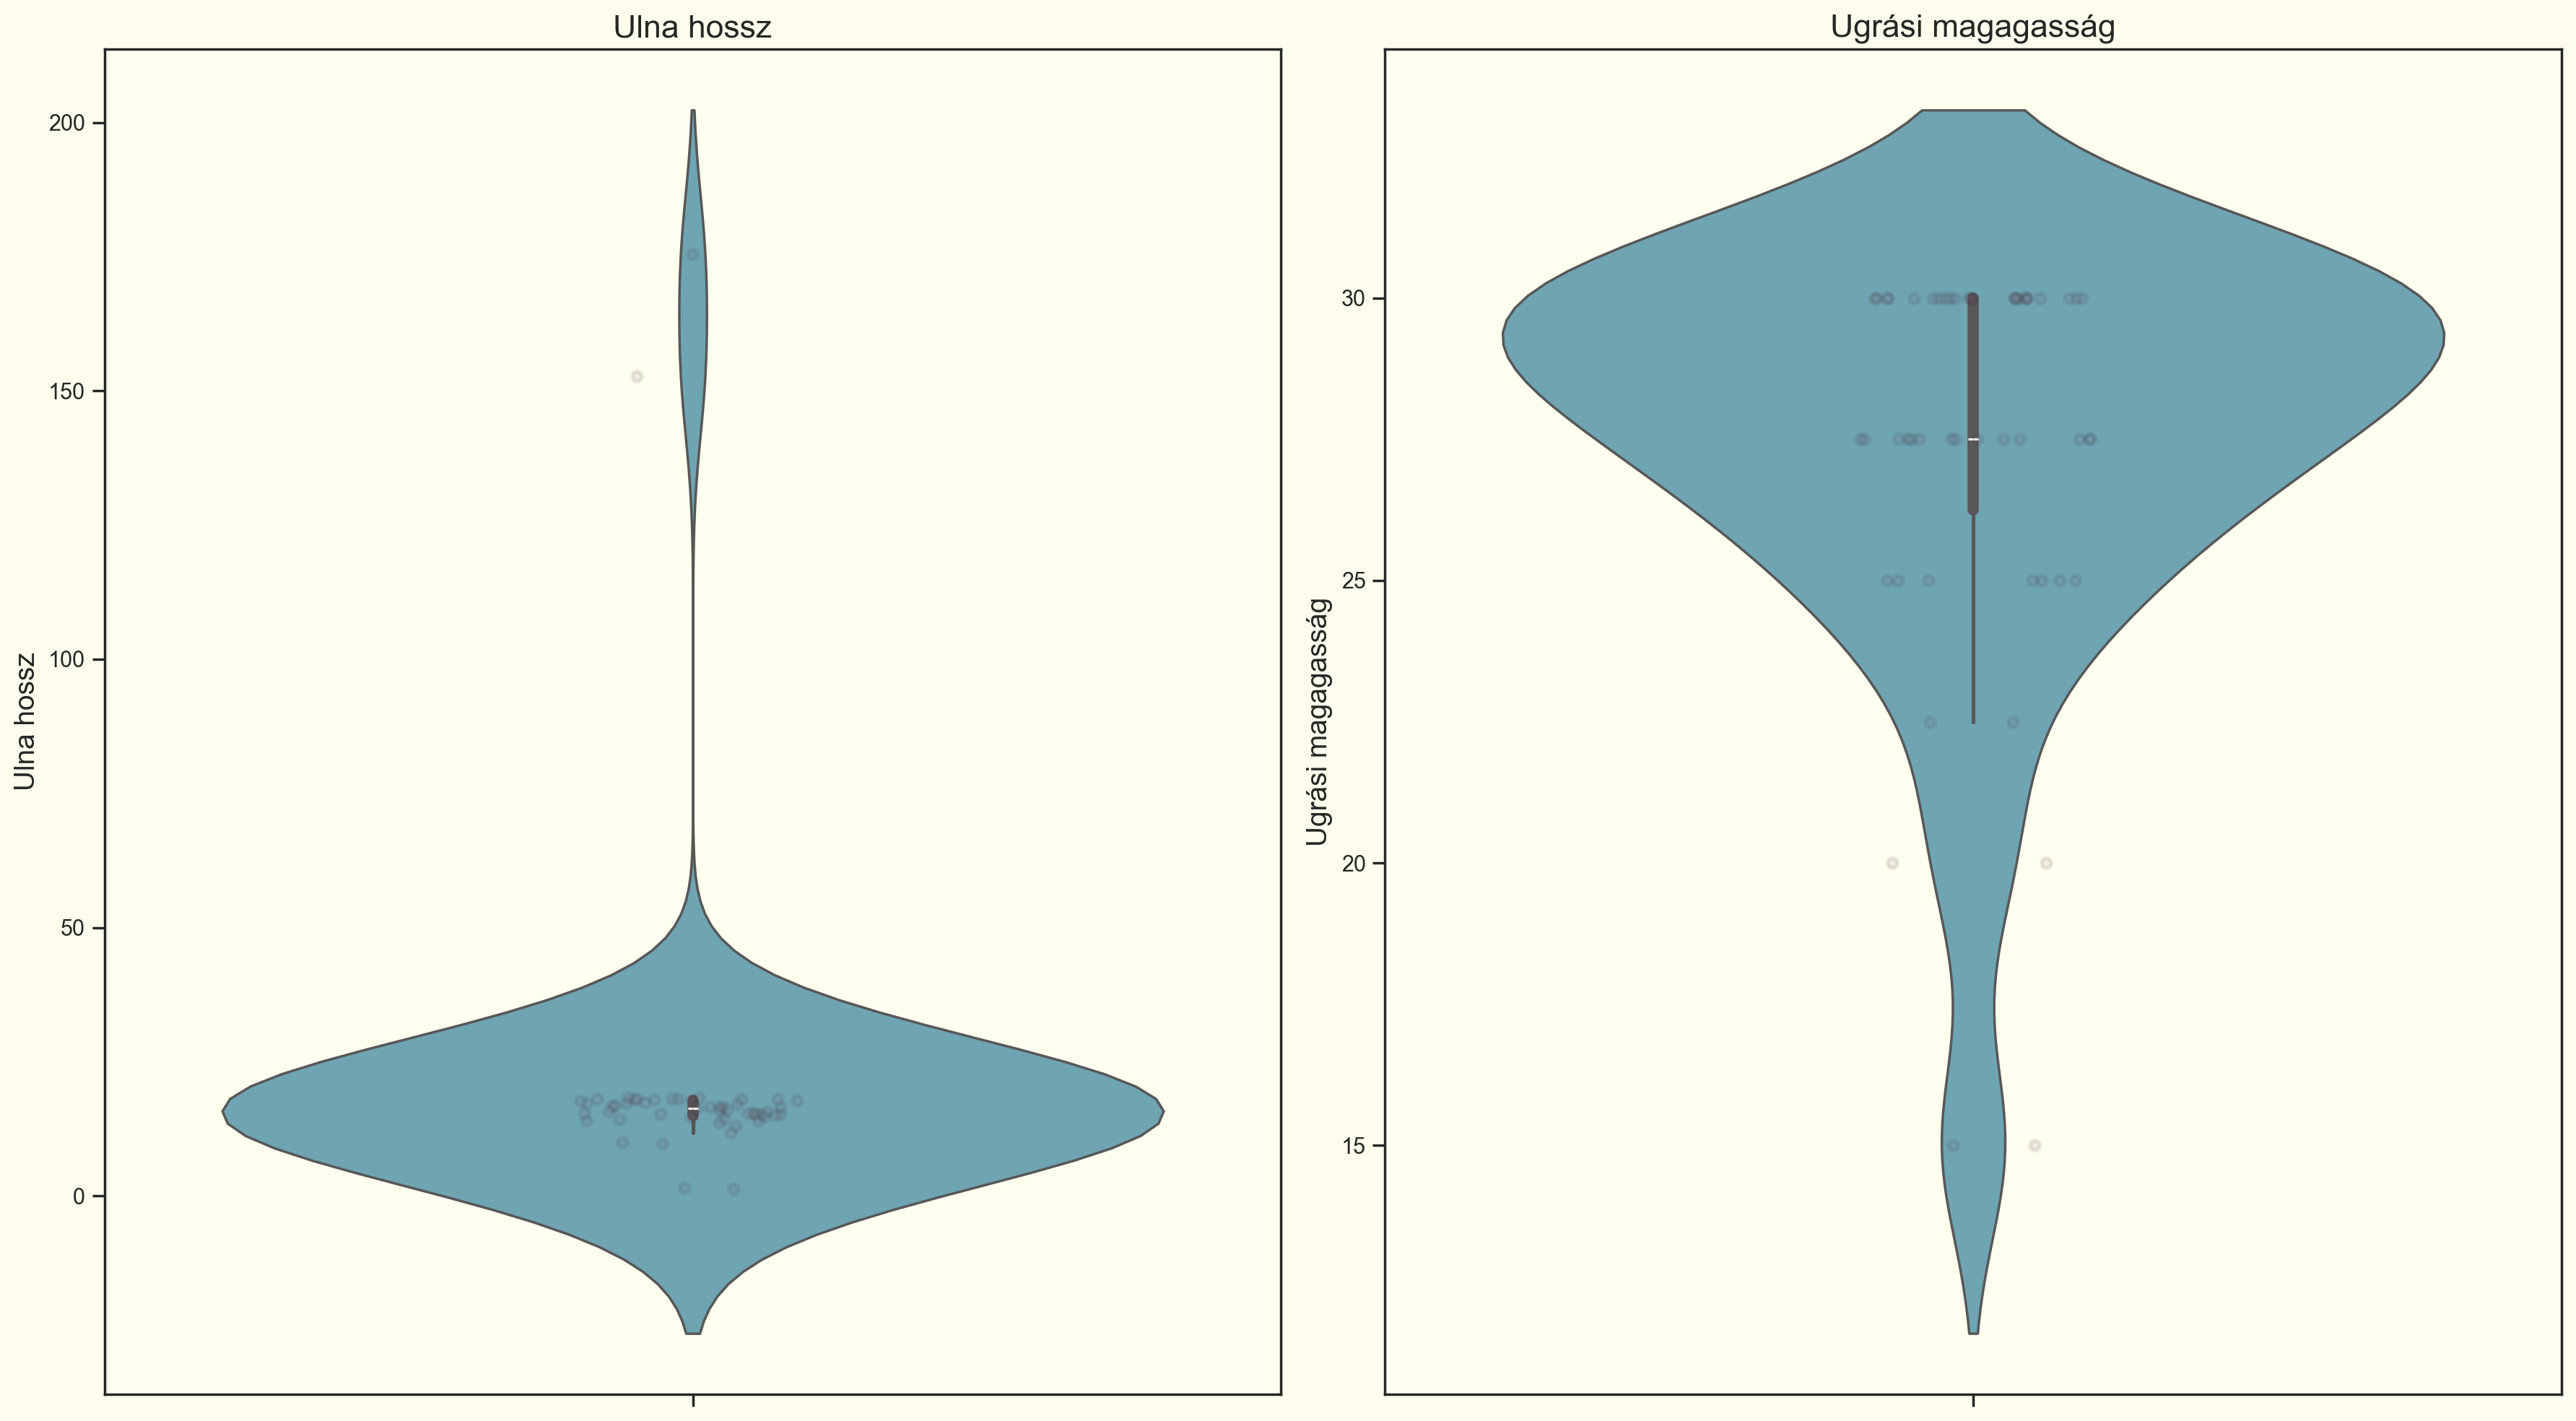

In [58]:
feature_names_full_dogs = {
    'ulna_hossz': 'Ulna hossz',
    'ugrasi_magassag': 'Ugrási magagasság'
}

num_outliers(dogs, num_columns_dogs, feature_names_full_dogs)

Az ulna hossz esetén egyértelmáen látszik az outlier, ami vélhetően egy tizedes probléma volt. Ezt javítom
Az ugrási magasság esetén is van pár eset, őket közelebbről is megnézem

In [59]:
dogs['ulna_hossz'].quantile([0, 0.25, 0.5, 0.75, 0.99])

0.00      1.209
0.25     14.960
0.50     16.280
0.75     17.775
0.99    164.150
Name: ulna_hossz, dtype: float64

In [60]:
dogs[(dogs['ulna_hossz']> 25) | (dogs['ulna_hossz'] < 15)]

felvezeto     nev                           fajta    nem       ivar  \
0   TM800418  Dexter                   Kooikerhondje    Kan  ivartalan   
5   OJ941014   Bella  American Staffordshire Terrier  Szuka  ivartalan   
6   HO800728  Gordon            Jack Russell Terrier    Kan  ivartalan   
10  DM850705  Speedy                             Mix    Kan  ivartalan   
15  OK870605   Gerry               Australian Kelpie    Kan  ivartalan   
16  UB870201   Henry          Parson Russell Terrier    Kan  ivartalan   
19  JV990222    Punk                 Small Schnauzer  Szuka  ivartalan   
21  UZ940717     Pax                         Sheltie    Kan  ivartalan   
23  SO990728   Dusty          Parson Russell Terrier  Szuka  ivartalan   
25  IN920805   Bruno                   Border Collie    Kan  ivartalan   
29  KL970722    Them                             Mix    Kan  ivartalan   
31  LZ800202   Dixie                   Border Collie    Kan  ivartalan   
36  EH800220    Easy              Patterdale Terrier    Kan  ivartalan   
37  DU050516   Falco                   Border Collie  Szuka  ivartalan   
40  TC041225   Kesha                   Border Collie    Kan     ivaros   

   szuletesi_datum       chip_szam  ulna_hossz  ugrasi_magassag  
0       2010-02-14  93900005238999      14.050             25.0  
5       2015-02-27  93900009320601      14.700             25.0  
6       2015-04-12  93900001569304       9.670             15.0  
10      2015-11-07  93900001547455       1.491             25.0  
15      2016-09-03  93900007728423      14.040             25.0  
16      2017-04-15  93900008474491       1.209             20.0  
19      2017-07-04  93900007218892      10.020             15.0  
21      2017-09-08  93900004293075      14.300             25.0  
23      2017-12-21  93900005627226      13.030             22.5  
25      2018-03-08  93900002928155     175.500             30.0  
29      2018-10-18  93900003871143      14.800             25.0  
31      2018-12-22  93900002523549      14.360             25.0  
36      2019-11-13  93900006680519      11.710             20.0  
37      2020-04-20  93900009884426     152.800             27.5  
40      2020-11-16  93900005669853      13.600             22.5

In [61]:
dogs['ulna_hossz'] = dogs['ulna_hossz'].apply(lambda x: x / 10 if x > 19 else x)
dogs['ulna_hossz'] = dogs['ulna_hossz'].apply(lambda x: x * 10 if x < 9 else x)

## 2.5 Dogs kategória változók elemzése

In [62]:
dogs_categorical_features = dogs.select_dtypes(include=['object', 'category']) \
                                  .columns.tolist()

In [63]:
dogs_categorical_features

['felvezeto', 'nev', 'fajta', 'nem', 'ivar', 'szuletesi_datum']

In [64]:
for feature in dogs_categorical_features:
    print(f'A {feature} változó értékeinek eloszlása: {dogs[feature].value_counts()}')
    print(f'------------------------')

A felvezeto változó értékeinek eloszlása: felvezeto
TM800418    1
GB900808    1
TU820403    1
KL970722    1
EH831207    1
LZ800202    1
OA821108    1
HM980701    1
EC940409    1
NZ800507    1
EH800220    1
DU050516    1
RF840515    1
IS961124    1
TC041225    1
LF971218    1
GE030417    1
DD800226    1
LM070408    1
RN891016    1
LP030829    1
VK910426    1
MJ930217    1
NJ890324    1
UO880828    1
IN920805    1
NP950613    1
TV860229    1
UF830429    1
ZE801127    1
DP910919    1
OJ941014    1
HO800728    1
UR870607    1
RK871018    1
PO831026    1
DM850705    1
LO900912    1
WS810829    1
UO920408    1
MB801205    1
OK870605    1
UB870201    1
KL920415    1
BV810323    1
JV990222    1
AT991109    1
UZ940717    1
MT970826    1
SO990728    1
UH881130    1
Name: count, dtype: int64
------------------------
A nev változó értékeinek eloszlása: nev
Dexter     1
Sunny      1
Maggie     1
Them       1
Rocky      1
Dixie      1
Brix       1
Milo       1
Tyna       1
Abby       1
Easy       1


Két kutya van, aki azonos napon született, őket azért kicsit közelebbről most megnézem

In [65]:
dogs[dogs['szuletesi_datum'] == '2018-12-22']

felvezeto    nev                        fajta  nem       ivar  \
30  EH831207  Rocky  Belgian Shepherd - Malinois  Kan  ivartalan   
31  LZ800202  Dixie                Border Collie  Kan  ivartalan   

   szuletesi_datum       chip_szam  ulna_hossz  ugrasi_magassag  
30      2018-12-22  93900003818036       18.29             30.0  
31      2018-12-22  93900002523549       14.36             25.0

In [66]:
dogs[dogs['szuletesi_datum'] == '2021-01-04']

felvezeto     nev          fajta    nem       ivar szuletesi_datum  \
42  GE030417    Moon  Border Collie  Szuka     ivaros      2021-01-04   
43  DD800226  Sirius  Border Collie    Kan  ivartalan      2021-01-04   

         chip_szam  ulna_hossz  ugrasi_magassag  
42  93900006876951       17.35             30.0  
43  93900005539134       17.74             30.0

Mivel nem látok semmi furcsát, így feltételezem, hogy ez rendben van

# 3.0 Néhány változó átalakítása

In [67]:
WR_cleaned['napszak'] = WR_cleaned['when'].apply(lambda x: 0 if datetime.strptime(x, '%H:%M:%S').hour < 12 else 1)

In [68]:
WR_cleaned['date'] = pd.to_datetime(WR_cleaned['date'])
WR_cleaned['year'] = WR_cleaned['date'].dt.year
WR_cleaned['month'] = WR_cleaned['date'].dt.month
WR_cleaned['day'] = WR_cleaned['date'].dt.day

In [69]:
WR_cleaned['hour'] = pd.to_datetime(WR_cleaned['when'], format='%H:%M:%S').dt.hour

Létrehozok egy wlt változót, amely számokkal tartalmazza inkább a string értékeket

In [70]:
wlt = {'L': 0, 'T': 1, 'W': 2}
WR_cleaned['wlt'] = WR_cleaned['W/L/T'].map(wlt)

Véglegesítem a verseny adatokat tartalmazó fájlt

In [71]:
wr_final = WR_cleaned.copy()

Néhány változót kiveszek a további elemzésekből, amelyek vagy átalakításra kerültek, vagy nem érzem már jelentőségüket

In [72]:
wr_final.drop(['W/L/T', 'error','anomaly','w_pair'], axis=1, inplace=True)

In [73]:
wr_final.head()

city        race_name       date      when  Division  \
0  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
1  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
2  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
3  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
4  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   

                    who  total_time  Hurdles    name  start  time  ordinal_no  \
0  Wildrunners Dreamers       17.01     25.0   Sunny  -0.24  4.21           1   
1  Wildrunners Dreamers       17.01     25.0   Dixie   0.30  4.24           2   
2  Wildrunners Dreamers       17.01     25.0    Alex   0.16  4.22           3   
3  Wildrunners Dreamers       17.01     25.0  Hector   0.00  4.13           4   
4  Wildrunners Maximini       19.43     25.0  Brooke  -0.11  4.08           1   

                                   dogs  szin  start_error  time_error  \
0  ['Sunny', 'Dixie', 'Alex', 'Hector']     0         True       False   
1  ['Sunny', 'Dixie', 'Alex', 'Hector']     0        False       False   
2  ['Sunny', 'Dixie', 'Alex', 'Hector']     0        False       False   
3  ['Sunny', 'Dixie', 'Alex', 'Hector']     0        False       False   
4  ['Brooke', 'Rocky', 'Bella', 'Bree']     1         True       False   

   start_outlier  outlier  napszak  year  month  day  hour  wlt  
0              1        0        0  2023      4   22    10    0  
1              0        0        0  2023      4   22    10    0  
2              0        0        0  2023      4   22    10    0  
3              0        0        0  2023      4   22    10    0  
4              1        0        0  2023      4   22    10    0

## 3.1 Dogs dataset véglegesítése

Születési dátum átalakítása dátummá

In [74]:
dogs['szuletesi_datum'] = pd.to_datetime(dogs['szuletesi_datum'])

In [75]:
dogs.head()

felvezeto     nev          fajta    nem       ivar szuletesi_datum  \
0  TM800418  Dexter  Kooikerhondje    Kan  ivartalan      2010-02-14   
1  NP950613  Jasper  Border Collie    Kan  ivartalan      2011-03-28   
2  UF830429   Angie  Border Collie  Szuka  ivartalan      2014-02-06   
3  ZE801127    Alex  Border Collie    Kan  ivartalan      2014-04-22   
4  DP910919  Ashley  Border Collie  Szuka  ivartalan      2015-01-26   

        chip_szam  ulna_hossz  ugrasi_magassag  
0  93900005238999       14.05             25.0  
1  93900007189034       16.56             30.0  
2  93900003827629       15.22             27.5  
3  93900003598960       17.95             30.0  
4  93900009738344       18.30             30.0

# 4.0 Adathalmazok összeolvasztása elemzéshez

A követketkezőkben már az elemzésre koncentrálva, összeolvasztom a korábbi adathalmazokat

In [76]:
df_merged = wr_final.merge(dogs, left_on='name', right_on='nev', how='left')

name és nev duplikált, így ezt eldobom

In [77]:
df_merged.drop(['nev'], axis=1, inplace=True)

Felveszek még egy válozót, amelyben tárolom az egyes kutyák életkorát a verseny pillanatában

In [78]:
df_merged['KorVersenykor'] = df_merged['year'] - pd.to_datetime(df_merged['szuletesi_datum']).dt.year

In [79]:
df_merged.head()

city        race_name       date      when  Division  \
0  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
1  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
2  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
3  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
4  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   

                    who  total_time  Hurdles    name  start  time  ordinal_no  \
0  Wildrunners Dreamers       17.01     25.0   Sunny  -0.24  4.21           1   
1  Wildrunners Dreamers       17.01     25.0   Dixie   0.30  4.24           2   
2  Wildrunners Dreamers       17.01     25.0    Alex   0.16  4.22           3   
3  Wildrunners Dreamers       17.01     25.0  Hector   0.00  4.13           4   
4  Wildrunners Maximini       19.43     25.0  Brooke  -0.11  4.08           1   

                                   dogs  szin  start_error  time_error  \
0  ['Sunny', 'Dixie', 'Alex', 'Hector']     0         True       False   
1  ['Sunny', 'Dixie', 'Alex', 'Hector']     0        False       False   
2  ['Sunny', 'Dixie', 'Alex', 'Hector']     0        False       False   
3  ['Sunny', 'Dixie', 'Alex', 'Hector']     0        False       False   
4  ['Brooke', 'Rocky', 'Bella', 'Bree']     1         True       False   

   start_outlier  outlier  napszak  year  month  day  hour  wlt felvezeto  \
0              1        0        0  2023      4   22    10    0  GB900808   
1              0        0        0  2023      4   22    10    0  LZ800202   
2              0        0        0  2023      4   22    10    0  ZE801127   
3              0        0        0  2023      4   22    10    0  UO880828   
4              1        0        0  2023      4   22    10    0  MJ930217   

                         fajta    nem       ivar szuletesi_datum  \
0  Belgian Shepherd - Malinois  Szuka  ivartalan      2020-09-10   
1                Border Collie    Kan  ivartalan      2018-12-22   
2                Border Collie    Kan  ivartalan      2014-04-22   
3                Border Collie    Kan     ivaros      2018-08-02   
4                Border Collie    Kan     ivaros      2021-10-20   

        chip_szam  ulna_hossz  ugrasi_magassag  KorVersenykor  
0  93900009650506       18.00             30.0              3  
1  93900002523549       14.36             25.0              5  
2  93900003598960       17.95             30.0              9  
3  93900003589833       18.00             30.0              5  
4  93900005854271       17.08             30.0              2

## 4.1 A kutyákkal kapcsolatos elemzések

Az összeolvasztott adathalmaz során megnéztem azt is, hogy az összeolvasztás okán jött-e létre bármilyen további érdekesség, amely kiegészítő elemzésekre adnának okot. Egy ilyen mindeképp megofta a figyelmem, mégpedig azok az esetek, mikor a kutya magasabb akadályon futott, mint ami a szabály szerint lehetséges

### 4.1.1 Lehet olyan, hogy az ugrási magasságnál nagyobb akadálynál fut?????

In [80]:
ugrasi_anomaly = df_merged[df_merged['Hurdles'].astype('float64') > df_merged['ugrasi_magassag'].astype('float64')]

In [81]:
ugrasi_anomaly['city'].value_counts()

city
Nové                34
Žamberk             21
Tápiószentmárton    15
Prostějov            9
Blšany               8
Litomyšl             4
Louňovice            3
Name: count, dtype: int64

Meglepetésemre nem is egy ilyen eset van, ráadásul nem is csak egy városban vagy versenyen, így ezen a ponton azt a kérdést kell feltennem, hogy én értelmeztem-e félre a szabálszatot vagy valóban jelezni kellett volna ezeket az eseteket a verseny során?

Azt is megvizsgálom, hogy ebben az esetekben milyen kimenetele volt az adott versenyeknek, azaz okozott-e hátrányt?

In [82]:
ugrasi_anomaly['wlt'].value_counts()

wlt
0    56
2    38
Name: count, dtype: int64

a 0 érték a vereség, míg a 2 érték a győzelem, de érdekesebb lehet ez kutyánként megtekintve

In [83]:
ugrasi_anomaly.groupby('name').agg(
    {
        'time' : 'mean',
        'city' : 'count'
    }
)

time  city
name                   
Cookies  4.508000     5
Dexter   4.524000    10
Dusty    6.585000     4
Falco    4.173333     3
Henry    4.730000    12
Pax      4.133500    60

In [84]:
an_dogs = list(ugrasi_anomaly['name'].unique())

In [85]:
df_merged[df_merged['name'].isin(an_dogs)].groupby('name').agg(
    {
        'time' : 'mean',
        'city' : 'count'
    }
)

time  city
name                   
Cookies  4.137656    66
Dexter   4.597089    80
Dusty    6.360682    46
Falco    4.236293   126
Henry    4.730000    12
Pax      4.107714   140

Általánosságban az látható, hogy rosszabb eredményeket értek el a kutyák illetve van olyan kutya, aki minden esetben magasabb akadályon futott, mint az lehetséges

## 4.1.2 Milyen a megoszlása az eredményeknek kutyák alapján? Melyik kutya mennyi győzelmet illetve vereséget tud felmutatni, továbbá mennyi hibát vétettek?

A lenti ábrán azt igyekeztem jelölni, hogy milyen futási eredményei vannak az egyes kutyáknak. A piros pöttyök a hibák, a sárga pötty az átlag, a zöld pötty pedig a két szélsőérték

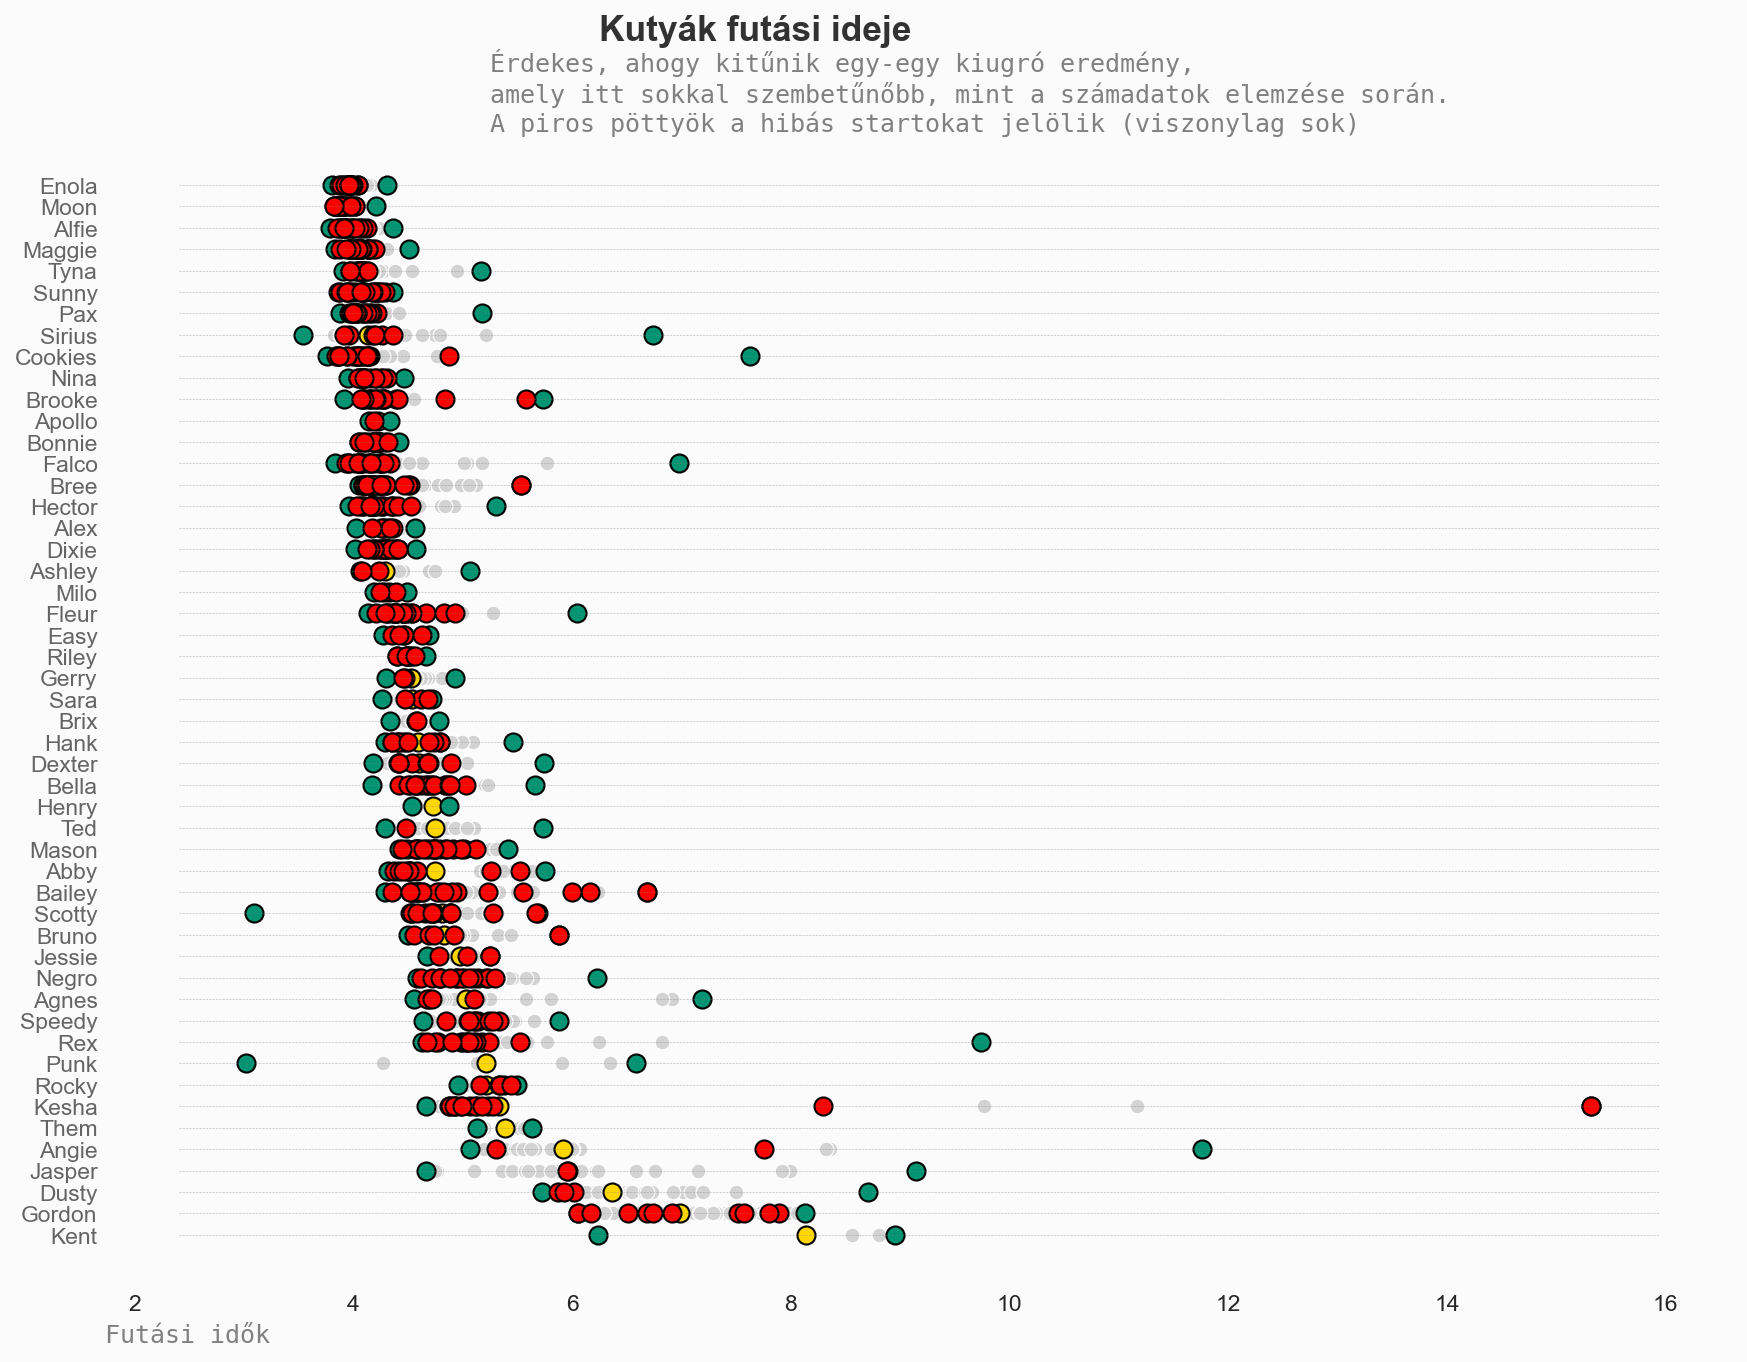

In [86]:
background = "#fbfbfb"
fig, ax = plt.subplots(1,1, figsize=(14, 10),dpi=150)
fig.patch.set_facecolor(background) 
ax.set_facecolor(background)

top_list_ = df_merged.groupby('name')['time'].mean().sort_values(ascending=True).reset_index().sort_values(by='time',ascending=False)


plot = 1
for dog in top_list_['name']:
    mean = df_merged[df_merged['name'] == dog].groupby('name')['time'].mean()
    min = df_merged[df_merged['name'] == dog].groupby('name')['time'].min()
    max = df_merged[df_merged['name'] == dog].groupby('name')['time'].max()
    # összes futás
    sns.scatterplot(data=df_merged[df_merged['name'] == dog], y=plot, x='time',color='lightgray',s=50,ax=ax)
    # átlag eredmény
    sns.scatterplot(data=df_merged[df_merged['name'] == dog], y=plot, x=mean,color='gold',ec='black',linewidth=1,s=75,ax=ax)
    # leggyorsabb futás
    sns.scatterplot(data=df_merged[df_merged['name'] == dog], y=plot, x=min ,color='#009473',ec='black',linewidth=1,s=75,ax=ax)
    # leglassabb futás
    sns.scatterplot(data=df_merged[df_merged['name'] == dog], y=plot, x=max ,color='#009473',ec='black',linewidth=1,s=75,ax=ax)
    # hibás start
    sns.scatterplot(data=df_merged[(df_merged['name'] == dog) & (df_merged['start_error'] == True)], y=plot, x='time' ,color='red',ec='black',linewidth=1,s=75,ax=ax)
    plot += 1


ax.set_yticks(top_list_.index+1)
ax.set_yticklabels(top_list_['name'][::-1], fontdict={'horizontalalignment': 'right'}, alpha=0.7)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel("Futási idők",fontfamily='monospace',loc='left',color='gray')

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(5.25, Yend-1.25,
'''
Érdekes, ahogy kitűnik egy-egy kiugró eredmény,
amely itt sokkal szembetűnőbb, mint a számadatok elemzése során.
A piros pöttyök a hibás startokat jelölik (viszonylag sok)
''', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')

for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
    
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.hlines(y=top_list_.index+1, xmin=Xstart, xmax=Xend, color='gray', alpha=0.5, linewidth=.3, linestyles='--')
ax.set_axisbelow(True)
ax.text(6.25, Yend+4.3, 'Kutyák futási ideje', fontsize=17, fontweight='bold', color='#323232')



plt.show();

Kiveszem belőlük a hibákat, így azok nélkül nézek rá, azaz minden esetet, ami hiábra és outlier-re utalt a korábbiak során

In [87]:
df_merged_wo_time_error = df_merged[(df_merged['time_error'] == False) & (df_merged['start_error'] == False) & (df_merged['outlier'] == 0) & (df_merged['start_outlier'] == 0)]

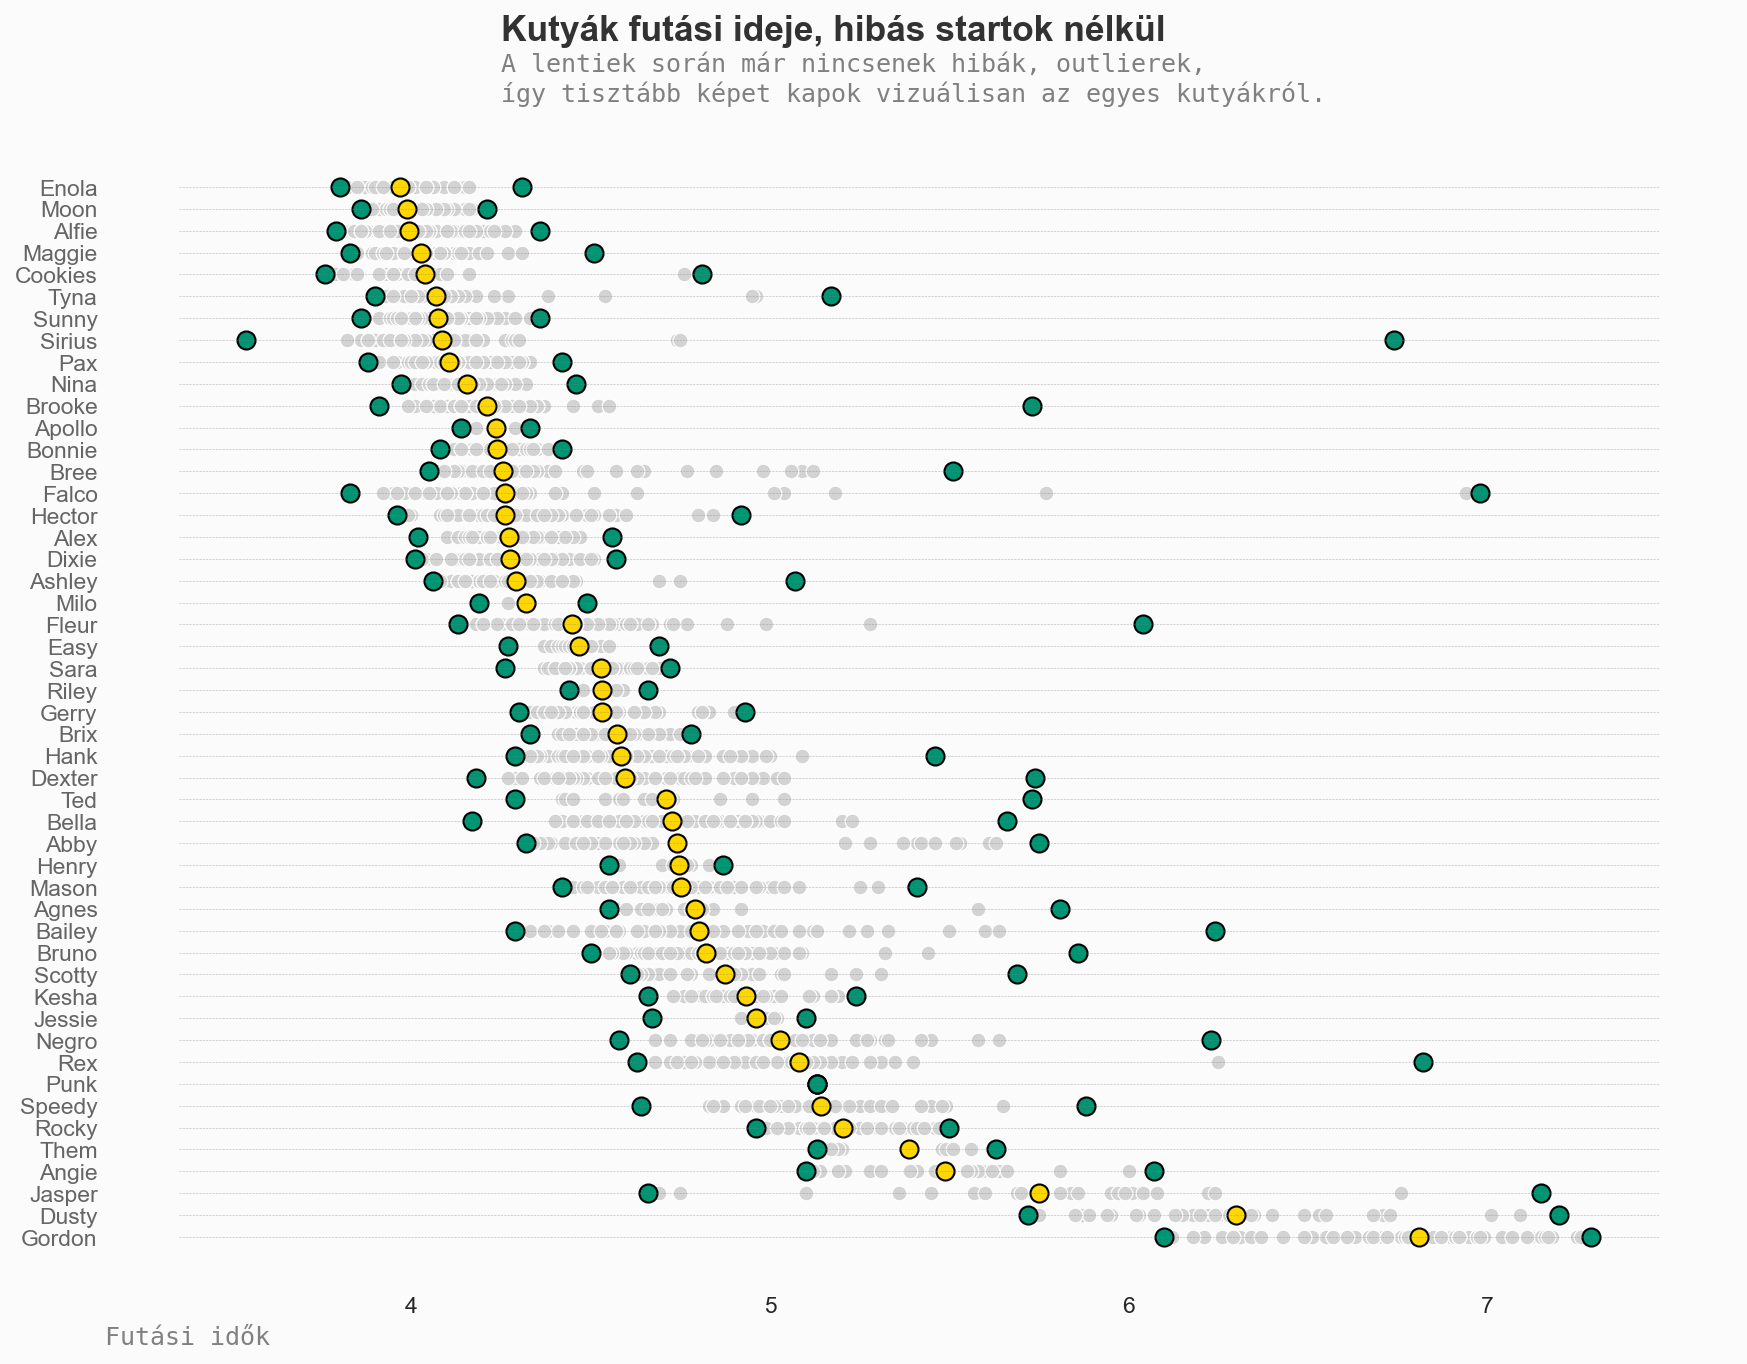

In [88]:
background = "#fbfbfb"
fig, ax = plt.subplots(1,1, figsize=(14, 10),dpi=150)
fig.patch.set_facecolor(background)
ax.set_facecolor(background)


top_list_ = df_merged_wo_time_error.groupby('name')['time'].mean().sort_values(ascending=True).reset_index().sort_values(by='time',ascending=False)


plot = 1
for dog in top_list_['name']:
    mean = df_merged_wo_time_error[df_merged_wo_time_error['name'] == dog].groupby('name')['time'].mean()
    min = df_merged_wo_time_error[df_merged_wo_time_error['name'] == dog].groupby('name')['time'].min()
    max = df_merged_wo_time_error[df_merged_wo_time_error['name'] == dog].groupby('name')['time'].max()
    # összes futás
    sns.scatterplot(data=df_merged_wo_time_error[df_merged_wo_time_error['name'] == dog], y=plot, x='time',color='lightgray',s=50,ax=ax)
    # átlag eredmény
    sns.scatterplot(data=df_merged_wo_time_error[df_merged_wo_time_error['name'] == dog], y=plot, x=mean,color='gold',ec='black',linewidth=1,s=75,ax=ax)
    # leggyorsabb futás
    sns.scatterplot(data=df_merged_wo_time_error[df_merged_wo_time_error['name'] == dog], y=plot, x=min ,color='#009473',ec='black',linewidth=1,s=75,ax=ax)
    # leglassabb futás
    sns.scatterplot(data=df_merged_wo_time_error[df_merged_wo_time_error['name'] == dog], y=plot, x=max ,color='#009473',ec='black',linewidth=1,s=75,ax=ax)
    plot += 1


ax.set_yticks(top_list_.index+1)
ax.set_yticklabels(top_list_['name'][::-1], fontdict={'horizontalalignment': 'right'}, alpha=0.7)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel("Futási idők",fontfamily='monospace',loc='left',color='gray')

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(4.25, Yend+0.25,
'''
A lentiek során már nincsenek hibák, outlierek,
így tisztább képet kapok vizuálisan az egyes kutyákról.
''', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')

for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
    
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.hlines(y=top_list_.index+1, xmin=Xstart, xmax=Xend, color='gray', alpha=0.5, linewidth=.3, linestyles='--')
ax.set_axisbelow(True)
ax.text(4.25, Yend+4.3, 'Kutyák futási ideje, hibás startok nélkül', fontsize=17, fontweight='bold', color='#323232')



plt.show();

Kutyák futási idejének átlaga dátumonként és városonként

In [89]:
df_merged_wo_time_error.groupby(['name','date', 'city']).agg(
    {
        'time' : 'mean',
        'when' : 'count'
    }
).sort_values('time').reset_index()

name       date              city      time  when
0     Sirius 2023-07-30  Tápiószentmárton  3.840000     4
1    Cookies 2023-10-14           Vodňany  3.861111     9
2      Alfie 2023-10-14           Vodňany  3.898696    23
3      Alfie 2023-07-30  Tápiószentmárton  3.912857     7
4      Enola 2023-05-20            Blšany  3.913103    29
5     Sirius 2023-07-01              Nové  3.930000     5
6      Alfie 2023-05-20            Blšany  3.930000    30
7      Enola 2023-07-30  Tápiószentmárton  3.932857     7
8      Enola 2023-07-01              Nové  3.944500    20
9    Cookies 2023-07-30  Tápiószentmárton  3.950000     3
10      Moon 2023-07-30  Tápiószentmárton  3.950000     1
11    Sirius 2023-10-14           Vodňany  3.959091    22
12      Moon 2023-04-22         Heroltice  3.961364    22
13    Maggie 2023-07-01              Nové  3.961600    25
14    Maggie 2023-07-30  Tápiószentmárton  3.961667     6
15     Enola 2023-04-22         Heroltice  3.963793    29
16     Enola 2023-05-06           Žamberk  3.964706    17
17     Alfie 2023-04-22         Heroltice  3.968182    22
18    Maggie 2023-10-14           Vodňany  3.969630    27
19      Moon 2023-05-06           Žamberk  3.970000    14
20      Tyna 2023-10-14           Vodňany  3.990000    16
21   Cookies 2023-09-03            Blšany  3.990000     8
22     Alfie 2023-05-06           Žamberk  3.990000    19
23      Tyna 2023-07-30  Tápiószentmárton  3.990000     6
24     Alfie 2023-09-16          Litomyšl  3.990000     8
25     Enola 2023-09-16          Litomyšl  3.991667    18
26     Sunny 2023-07-01              Nové  3.992105    19
27      Moon 2023-09-03            Blšany  3.993529    17
28     Sunny 2023-07-30  Tápiószentmárton  3.995000     6
29     Enola 2023-06-24         Prostějov  3.996538    26
30    Sirius 2023-09-03            Blšany  3.997500     4
31     Sunny 2023-09-03            Blšany  4.000769    13
32     Alfie 2023-07-15         Louňovice  4.001154    26
33      Moon 2023-07-01              Nové  4.002273    22
34      Moon 2023-06-24         Prostějov  4.010435    23
35      Tyna 2023-07-01              Nové  4.013125    16
36      Tyna 2023-05-20            Blšany  4.013500    20
37     Alfie 2023-07-01              Nové  4.018500    20
38   Cookies 2023-09-16          Litomyšl  4.018750     8
39     Enola 2023-09-03            Blšany  4.019167    24
40       Pax 2023-07-30  Tápiószentmárton  4.020000     5
41    Maggie 2023-06-24         Prostějov  4.021053    19
42    Maggie 2023-09-03            Blšany  4.022273    22
43       Pax 2023-07-15         Louňovice  4.031481    27
44      Nina 2023-07-01              Nové  4.037059    17
45    Maggie 2023-07-15         Louňovice  4.055909    22
46      Tyna 2023-09-03            Blšany  4.056000    15
47    Maggie 2023-04-22         Heroltice  4.057037    27
48    Maggie 2023-05-06           Žamberk  4.057143     7
49       Pax 2023-05-20            Blšany  4.058000    15
50     Sunny 2023-06-24         Prostějov  4.066471    17
51     Alfie 2023-09-03            Blšany  4.071667    24
52    Maggie 2023-05-20            Blšany  4.072917    24
53     Falco 2023-05-20            Blšany  4.076667    12
54      Tyna 2023-04-22         Heroltice  4.083846    26
55       Pax 2023-06-24         Prostějov  4.084615    13
56    Maggie 2023-09-16          Litomyšl  4.087368    19
57       Pax 2023-07-01              Nové  4.096818    22
58      Nina 2023-10-14           Vodňany  4.101500    20
59     Sunny 2023-05-20            Blšany  4.112353    17
60      Tyna 2023-07-15         Louňovice  4.119444    18
61    Sirius 2023-06-24         Prostějov  4.122000     5
62     Dixie 2023-09-03            Blšany  4.130588    17
63     Dixie 2023-07-30  Tápiószentmárton  4.135000     2
64    Ashley 2023-10-14           Vodňany  4.140000     4
65      Nina 2023-06-24         Prostějov  4.140000    19
66      Bree 2023-10-14           Vodňany  4.150000    17
67    Brooke 2023-10-14           Vodňany  4.154762    21
68    

## 4.1.3 Melyik kutya mennyi győzelmet illetve vereséget tud felmutatni, továbbá mennyi hibát vétettek?

In [90]:
# Hibás futások kiemelése
df_merged_w_error = df_merged.copy()
df_merged_w_error['error'] = df_merged['time_error'] | df_merged['start_error']

In [91]:
eredmeny = df_merged_w_error.groupby('name').agg(
    {
        'time' : [('Atlag', 'mean')],
        'when' : [('Futasok_szama','count')],
        'wlt' : [
            ('Win', lambda x: x[df_merged.loc[x.index, 'wlt'] == 2].count()),
            ('Lose', lambda x: x[df_merged.loc[x.index, 'wlt'] == 0].count())
        ],
        'error' : [('Hibas_futasok','sum')],
    }
).reset_index()
eredmeny.columns = ['_'.join(col).strip() for col in eredmeny.columns.values]
eredmeny['Win%'] = round(eredmeny['wlt_Win'] / eredmeny['when_Futasok_szama'] * 100, 0)
eredmeny['Error%'] = round(eredmeny['error_Hibas_futasok'] / eredmeny['when_Futasok_szama'] * 100, 0)


In [92]:
# Kialakítok 5 csoportot annak megfelelően, hogy mennyi futamot futottak.
# A tervem az, hogy csoporton belül is végezzek összehasonlítást

eredmeny['csoport'] = pd.qcut(eredmeny['when_Futasok_szama'], 5, labels=['Csoport 5','Csoport 4', 'Csoport 3', 'Csoport 2', 'Csoport 1'])
eredmeny.head()

name_  time_Atlag  when_Futasok_szama  wlt_Win  wlt_Lose  \
0   Abby    4.749375                  64       26        38   
1  Agnes    5.027419                  32        9        23   
2   Alex    4.272812                 129       68        61   
3  Alfie    3.992372                 217       96       120   
4  Angie    5.911875                  33       13        20   

   error_Hibas_futasok  Win%  Error%    csoport  
0                   10  41.0    16.0  Csoport 4  
1                    5  28.0    16.0  Csoport 5  
2                    7  53.0     5.0  Csoport 2  
3                   19  44.0     9.0  Csoport 1  
4                    3  39.0     9.0  Csoport 4

## 4.1.3.1 Helyszín és dátum alapján, melyik kutya mennyi győzelmet illetve vereséget tud felmutatni, továbbá mennyi hibát vétettek?

In [93]:
eredmeny = df_merged_w_error.groupby(['name','date', 'city']).agg(
    {
        'time' : [('Atlag', 'mean')],
        'when' : [('Futasok_szama','count')],
        'wlt' : [
            ('Win', lambda x: x[df_merged.loc[x.index, 'wlt'] == 2].count()),
            ('Lose', lambda x: x[df_merged.loc[x.index, 'wlt'] == 0].count())
        ],
        'error' : [('Hibas_futasok','sum')],
    }
).reset_index()
eredmeny.columns = ['_'.join(col).strip() for col in eredmeny.columns.values]
eredmeny['Win%'] = round(eredmeny['wlt_Win'] / eredmeny['when_Futasok_szama'] * 100, 0)
eredmeny['Error%'] = round(eredmeny['error_Hibas_futasok'] / eredmeny['when_Futasok_szama'] * 100, 0)
eredmeny['csoport'] = pd.qcut(eredmeny['when_Futasok_szama'], 5, labels=['Csoport 5','Csoport 4', 'Csoport 3', 'Csoport 2', 'Csoport 1'])

In [94]:
eredmeny.head()

name_      date_      city_  time_Atlag  when_Futasok_szama  wlt_Win  \
0   Abby 2023-06-24  Prostějov    4.455217                  23       10   
1   Abby 2023-07-01       Nové    4.914390                  41       16   
2  Agnes 2023-04-22  Heroltice    5.087222                  18        5   
3  Agnes 2023-05-06    Žamberk    4.944615                  14        4   
4   Alex 2023-04-22  Heroltice    4.303600                  25       13   

   wlt_Lose  error_Hibas_futasok  Win%  Error%    csoport  
0        13                    6  43.0    26.0  Csoport 2  
1        25                    4  39.0    10.0  Csoport 1  
2        13                    1  28.0     6.0  Csoport 3  
3        10                    4  29.0    29.0  Csoport 4  
4        12                    0  52.0     0.0  Csoport 1

## 4.1.4 Kíváncsiságból megnézem azt is, hogy mely kutyák "futási teljesítménye" a legmegbízhatóbb

Elsőként egy alap elemzés a futási idő szórása alapján. Azt nézem, hogy melyik kutya az, amelyik esetén a várható idő a legkisebb eltérést mutatja.

In [95]:
# az eredmény az idő alapján a szórás illetve a futott versenyek száma
df_merged_wo_time_error.groupby('name').agg(
    {    
        'time' : 'std',
        'city' : 'count'
    }
).sort_values('time').head()

time  city
name                  
Riley   0.066466    10
Bonnie  0.070261    83
Easy    0.070333    35
Moon    0.072215    99
Enola   0.076746   170

Gyakorlás miatt próbáltam a leginkább "elvárható" és a legkevésébé "elvárható" top 5 kutyát megmutatni

In [96]:
# colours
low_c = '#dd4124'
high_c = '#009473'
plt.rcParams["font.family"] = "monospace"

/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/2622596189.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(data[i]-(data[i]*0.01), i),
/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/2622596189.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(data[i]-(data[i]*0.01), i),
/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/2622596189.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

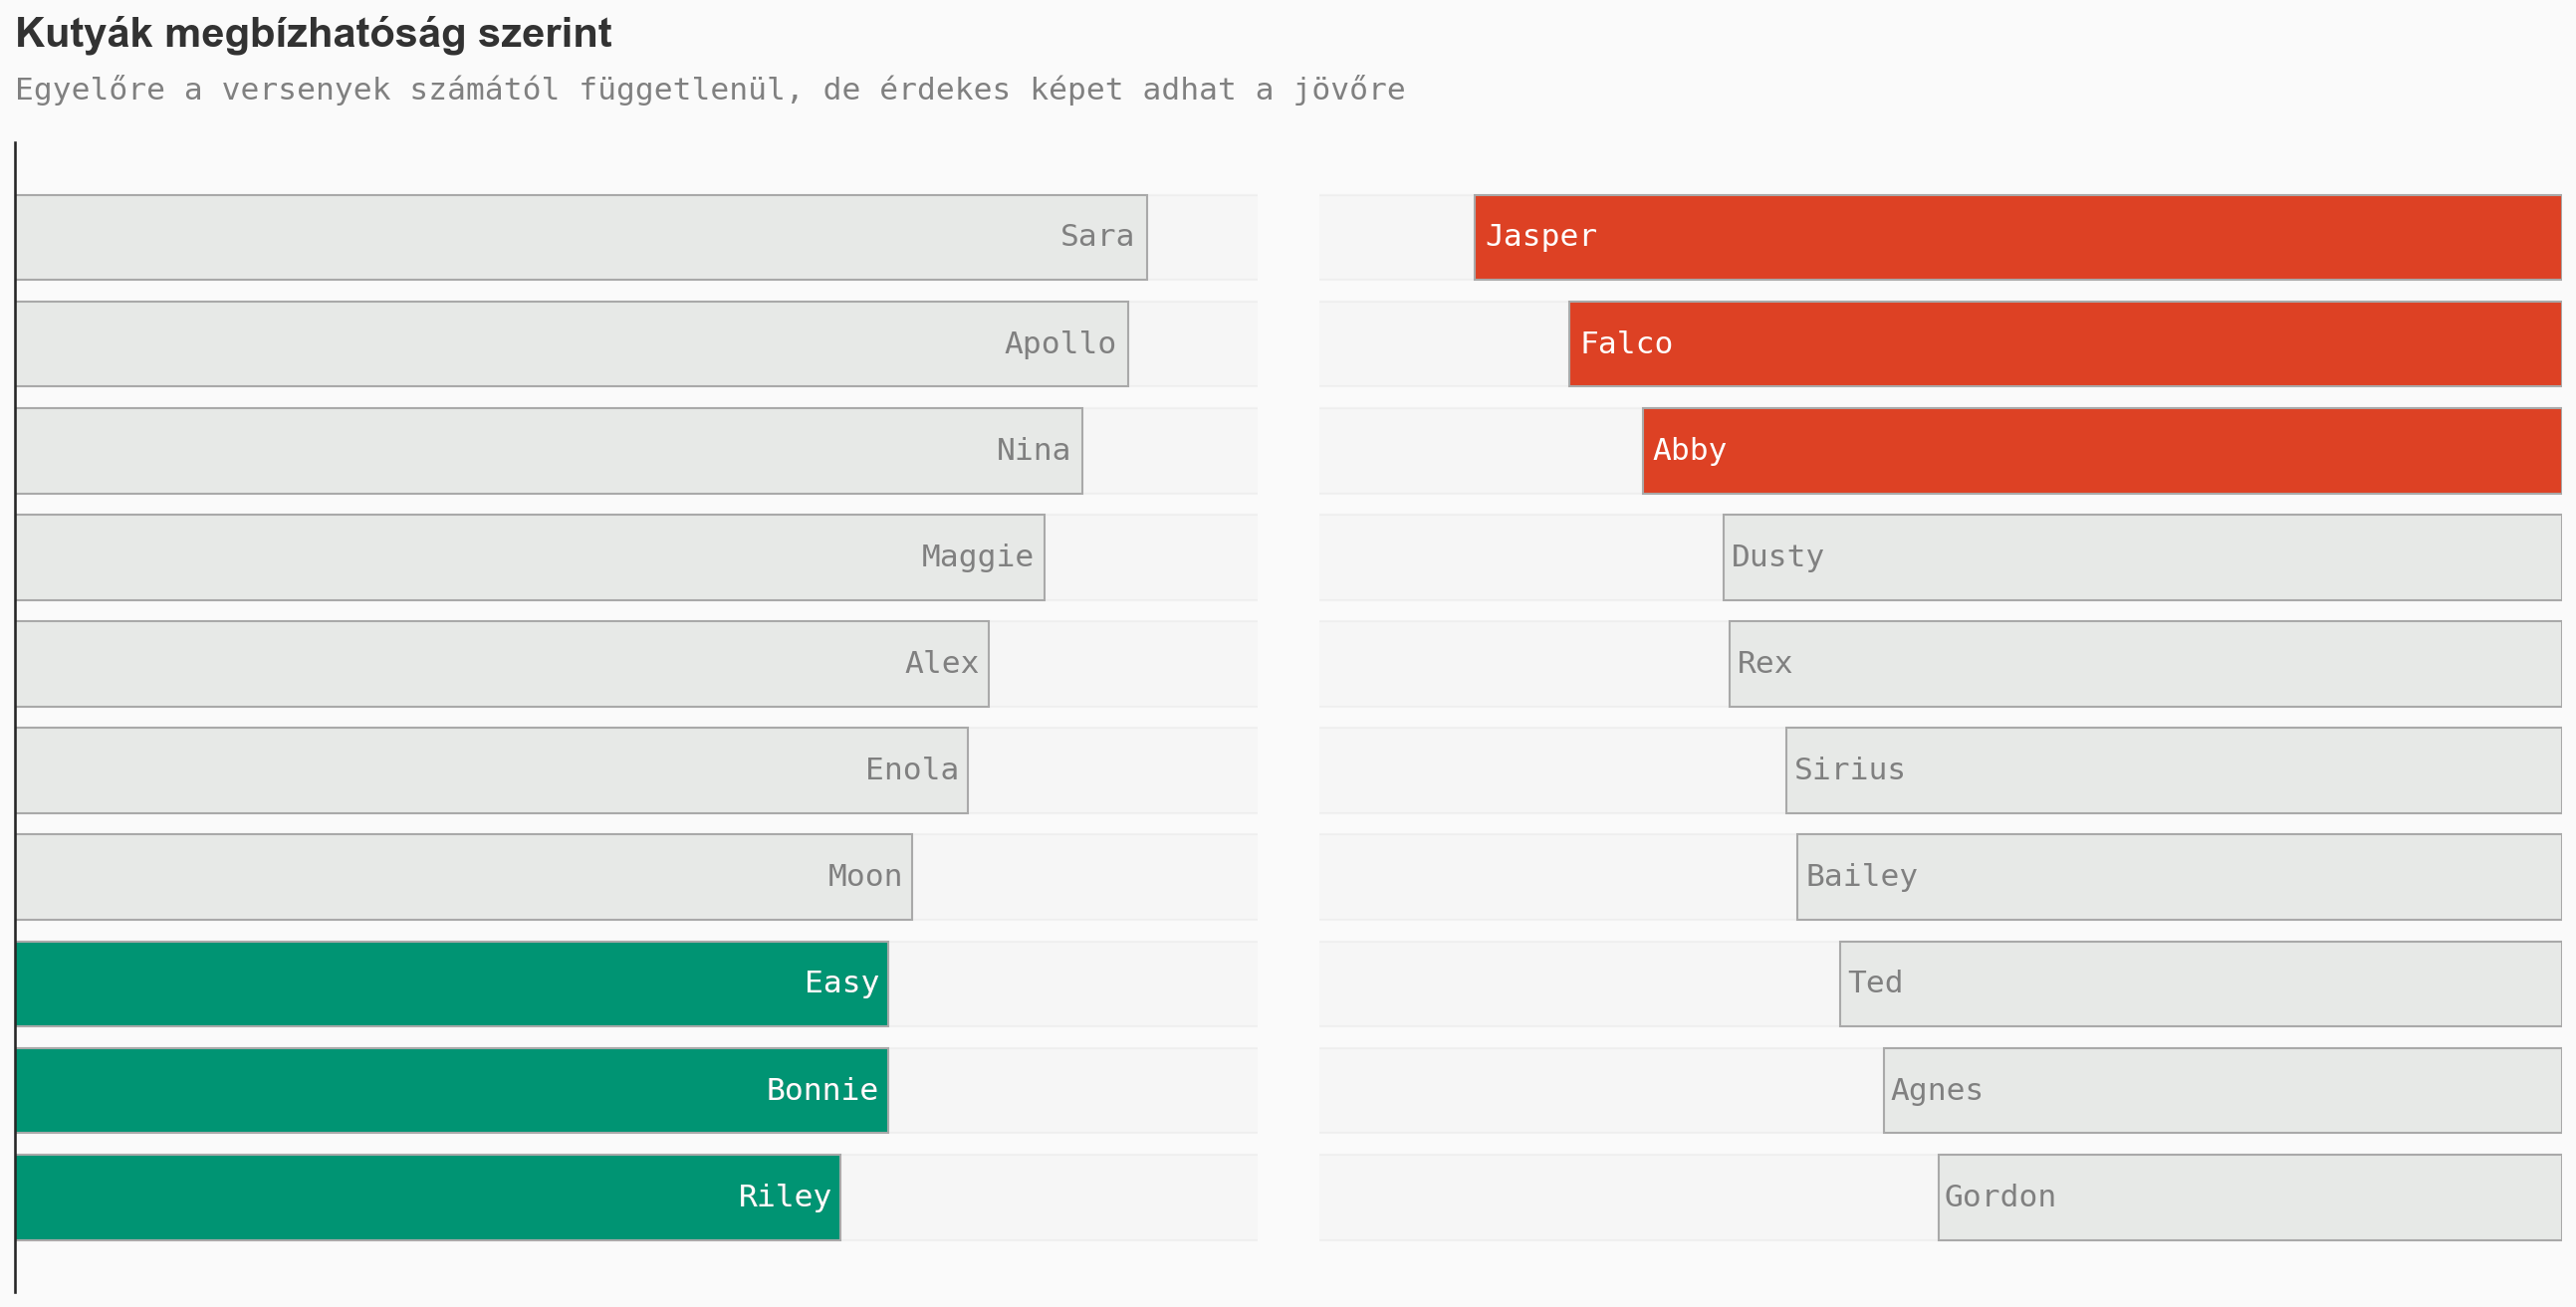

In [97]:
fig = plt.figure(figsize=(22,10),dpi=150)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 


# Plots 
# Std
data = df_merged_wo_time_error.groupby('name')['time'].std().sort_values(ascending=True)[:10]


color_map = ['#e7e9e7' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  high_c # háttér

# base
ax0.barh(data.index, 10, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax0.barh(data.index, data, 
       edgecolor='darkgray',color=color_map)


# Stabil
for i in range(0,10):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)
# diff color text
for i in range(0,3):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
    
# Kilengő

data = df_merged_wo_time_error.groupby('name')['time'].std().sort_values(ascending=False)[:10]

color_map = ['#e7e9e7' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  low_c # color highlight

#base
ax1.barh(data.index[::-1], 10, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax1.barh(data.index, data, 
       edgecolor='darkgray',color=color_map)


#annotations

for i in range(7,10):
    ax1.annotate(list(data.index)[::-1][i], 
                   xy=(data[::-1][i]-(data[::-1][i]*0.01), i), 
                   va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
# diff color text
for i in range(0,7):
    ax1.annotate(list(data.index)[::-1][i], 
                   xy=(data[::-1][i]-(data[::-1][i]*0.01), i), 
                   va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)

for s in ['top', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    
for s in ['top', 'bottom', 'right','left']:    
    ax1.spines[s].set_visible(False)
    
    
ax0.set_xlim(0,0.1)
ax1.set_xlim(0.6,0)
    
# ax labels off

ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])

ax0.text(0,10.8,'Kutyák megbízhatóság szerint',fontfamily='sans-serif',fontsize=20,fontweight='bold',color='#323232')
ax0.text(0,10.3,'Egyelőre a versenyek számától függetlenül, de érdekes képet adhat a jövőre'
         ,fontfamily='monospace',fontsize=15,fontweight='light',color='gray')

# rect
from matplotlib.patches import Rectangle
X, Y = 0, 10.5


ax1.add_patch(Rectangle((X, Y), 10, 3,alpha=0.2, edgecolor='gray',facecolor='gray'))

fig.text(0.53,0.72,
        
'''

''',color='black',fontfamily='monospace',fontsize=12)


plt.show()

In [98]:
# az eredmény az idő alapján a szórás illetve a futott versenyek száma
df_merged_wo_time_error.groupby('name').agg(
    {    
        'time' : 'std',
        'city' : 'count'
    }
).sort_values('time').head(10)

time  city
name                  
Riley   0.066466    10
Bonnie  0.070261    83
Easy    0.070333    35
Moon    0.072215    99
Enola   0.076746   170
Alex    0.078415   121
Maggie  0.082875   198
Nina    0.085964   120
Apollo  0.089629     4
Sara    0.091133    55

In [99]:
# az eredmény az idő alapján a szórás illetve a futott versenyek száma
df_merged_wo_time_error.groupby('name').agg(
    {    
        'time' : 'std',
        'city' : 'count'
    }
).sort_values('time').tail(11)

time  city
name                  
Gordon  0.300973    79
Agnes   0.327242    20
Ted     0.348650    15
Bailey  0.368956    56
Sirius  0.374183    67
Rex     0.401844    38
Dusty   0.404826    34
Abby    0.443606    50
Falco   0.479062    94
Jasper  0.525061    31
Punk         NaN     1

## 4.1.7 Van-e különbség eredményben, hogy nöstény vagy kan a kutya?

In [100]:
df_merged.groupby('nem')['time'].mean()

nem
Kan      4.690874
Szuka    4.302372
Name: time, dtype: float64

Úgy tűnik a szukák majdnem 10%-kal jobb eredményt érnek el, ez jelentős lehet

### 4.1.7.1 A hibázások számát hozzáadva mit mutat a kép?

In [101]:
df_nem = df_merged.copy()

In [102]:
df_nem['error'] = df_nem['time_error'] | df_nem['start_error']

In [103]:
df_nem.groupby('nem').agg(
    {
        'time' : 'mean',
        'time_error' : 'sum',
        'error' : 'sum'
    }
)

time  time_error  error
nem                               
Kan    4.690874          43    308
Szuka  4.302372          33    291

Azon kívül, hogy jobb eredményre képesek a szukák, még a hibázások száma is alacsonyabb, igaz csak kevéssel

### 4.1.7.2 A hibázások számát hozzáadva mit mutat a kép? Városok és dátumok alapján

In [104]:
df_nem.groupby(['nem', 'date','city']).agg(
    {
        'time' : 'mean',
        'time_error' : 'sum',
        'error' : 'sum'
    }
)

time  time_error  error
nem   date       city                                         
Kan   2023-04-22 Heroltice         4.778162          14     46
      2023-05-06 Žamberk           4.784126           1     47
      2023-05-20 Blšany            4.531818           1     17
      2023-06-24 Prostějov         4.818760           8     52
      2023-07-01 Nové              4.693213           1     31
      2023-07-15 Louňovice         4.681456           1     18
      2023-07-29 Tápiószentmárton  4.761584           1      7
      2023-07-30 Tápiószentmárton  4.259487           0      7
      2023-09-03 Blšany            4.357968           3     21
      2023-09-16 Litomyšl          4.750991           8     34
      2023-10-14 Vodňany           4.496415           5     28
Szuka 2023-04-22 Heroltice         4.334186           4     51
      2023-05-06 Žamberk           4.448963           6     52
      2023-05-20 Blšany            4.147265           7     41
      2023-06-24 Prostějov         4.400121           2     42
      2023-07-01 Nové              4.288013           1     34
      2023-07-15 Louňovice         4.301000           1     14
      2023-07-29 Tápiószentmárton  4.645000           0      4
      2023-07-30 Tápiószentmárton  4.010698           2      7
      2023-09-03 Blšany            4.219300           4     22
      2023-09-16 Litomyšl          4.345690           1     11
      2023-10-14 Vodňany           4.046555           5     13

## 4.1.8 Ha alacsonyabban volt a magasság, akkor a kutyák jobb eredményt értek el?

In [105]:
df_ugras = df_merged.copy()

In [106]:
df_ugras['ugrasi_dif'] = df_ugras['Hurdles'] - df_ugras['ugrasi_magassag']

In [107]:
df_ugras_viz = df_ugras.groupby(['name', 'ugrasi_dif']).agg(
    {
        'time' : 'mean',
        'city' : 'count'
    }
).reset_index()

In [108]:
df_ugras_viz

name  ugrasi_dif      time  city
0       Abby       -12.5  5.422222    18
1       Abby        -5.0  4.485000    12
2       Abby        -2.5  4.455217    23
3       Abby         0.0  4.551818    11
4      Agnes       -15.0  4.816429    14
5      Agnes        -5.0  4.944615    14
6      Agnes        -2.5  6.035000     4
7       Alex        -7.5  4.360000     4
8       Alex        -5.0  4.264714    70
9       Alex        -2.5  4.263939    34
10      Alex         0.0  4.297143    21
11     Alfie        -7.5  4.096667     3
12     Alfie        -5.0  3.979600    50
13     Alfie        -2.5  3.994383   164
14     Angie       -12.5  5.932222    10
15     Angie        -2.5  5.930526    19
16     Angie         0.0  5.777500     4
17    Apollo        -5.0  4.185000     2
18    Apollo        -2.5  4.253333     3
19    Ashley       -15.0  4.140000     5
20    Ashley        -5.0  4.308974    40
21    Ashley        -2.5  4.271111    18
22    Bailey       -15.0  4.997561    41
23    Bailey       -10.0  4.513462    27
24    Bailey        -7.5  4.687778    12
25    Bailey        -5.0  4.777273    11
26    Bailey        -2.5  4.800000    20
27     Bella         0.0  4.718854   159
28    Bonnie        -2.5  4.232353   104
29      Bree        -5.0  4.257075   147
30      Bree        -2.5  4.251818    56
31      Brix        -5.0  4.574500    41
32    Brooke        -5.0  4.237647    85
33    Brooke        -2.5  4.209167    73
34     Bruno        -5.0  4.822642    53
35     Bruno        -2.5  4.862000    15
36   Cookies        -5.0  4.180000     6
37   Cookies        -2.5  4.196364    12
38   Cookies         0.0  4.072143    43
39   Cookies         2.5  4.508000     5
40    Dexter       -10.0  4.501429    29
41    Dexter        -2.5  4.672857     7
42    Dexter         0.0  4.681765    34
43    Dexter         2.5  4.524000    10
44     Dixie        -2.5  4.300000     3
45     Dixie         0.0  4.276772   127
46     Dusty        -7.5  6.361515    35
47     Dusty         0.0  6.228571     7
48     Dusty         5.0  6.585000     4
49      Easy         0.0  4.466410    41
50     Enola        -7.5  3.941111     9
51     Enola        -2.5  3.968092   173
52     Enola         0.0  3.978000     5
53     Falco        -5.0  4.073529    19
54     Falco        -2.5  4.367143    45
55     Falco         0.0  4.189259    59
56     Falco         2.5  4.173333     3
57     Fleur       -10.0  4.347632    38
58     Fleur        -7.5  4.580000    13
59     Fleur        -5.0  4.469219    64
60     Fleur        -2.5  4.482917    24
61     Gerry       -10.0  4.573750     8
62     Gerry         0.0  4.524667    62
63    Gordon         0.0  6.983217   116
64      Hank       -12.5  4.547917    24
65      Hank        -7.5  4.446410    39
66      Hank        -5.0  4.448333    12
67      Hank        -2.5  4.675833    48
68      Hank         0.0  4.690244    42
69    Hector       -15.0  4.148667    16
70    Hector        -5.0  4.255632    87
71    Hector        -2.5  4.299512    43
72    Hector         0.0  4.301250    24
73     Henry         5.0  4.747273    11
74     Henry         7.5  4.540000     1
75    Jasper       -15.0  5.953939    36
76    Jasper        -2.5  6.020000     4
77    Jessie       -15.0  5.004286     7
78    Jessie        -5.0  4.896667     3
79    Jessie        -2.5  5.040000     1
80      Kent       -12.5  6.240000     6
81      Kent         0.0  8.773333     3
82     Kesha        -7.5  5.700000    17
83     Kesha         0.0  5.198776    50
84    Maggie        -5.0  4.003333    60
85    Maggie        -2.5  4.039136   163
86    Maggie         0.0  4.035000     2
87     Mason        -7.5  4.721667     6
88     Mason        -5.0  4.700370    27
89     Mason        -2.5  4.693659    41
90     Mason         0.0  4.818148    54
91      Milo        -5.0  4.316667     3
92      Milo        -2.5  4.332857     7
93      Moon        -7.5  3.935000     6
94      Moon        -2.5  3.973333   108
95      Moon         0.0  4.028000     5
96     Negro       -12.5  4.855

<Axes: xlabel='ugrasi_dif', ylabel='time'>

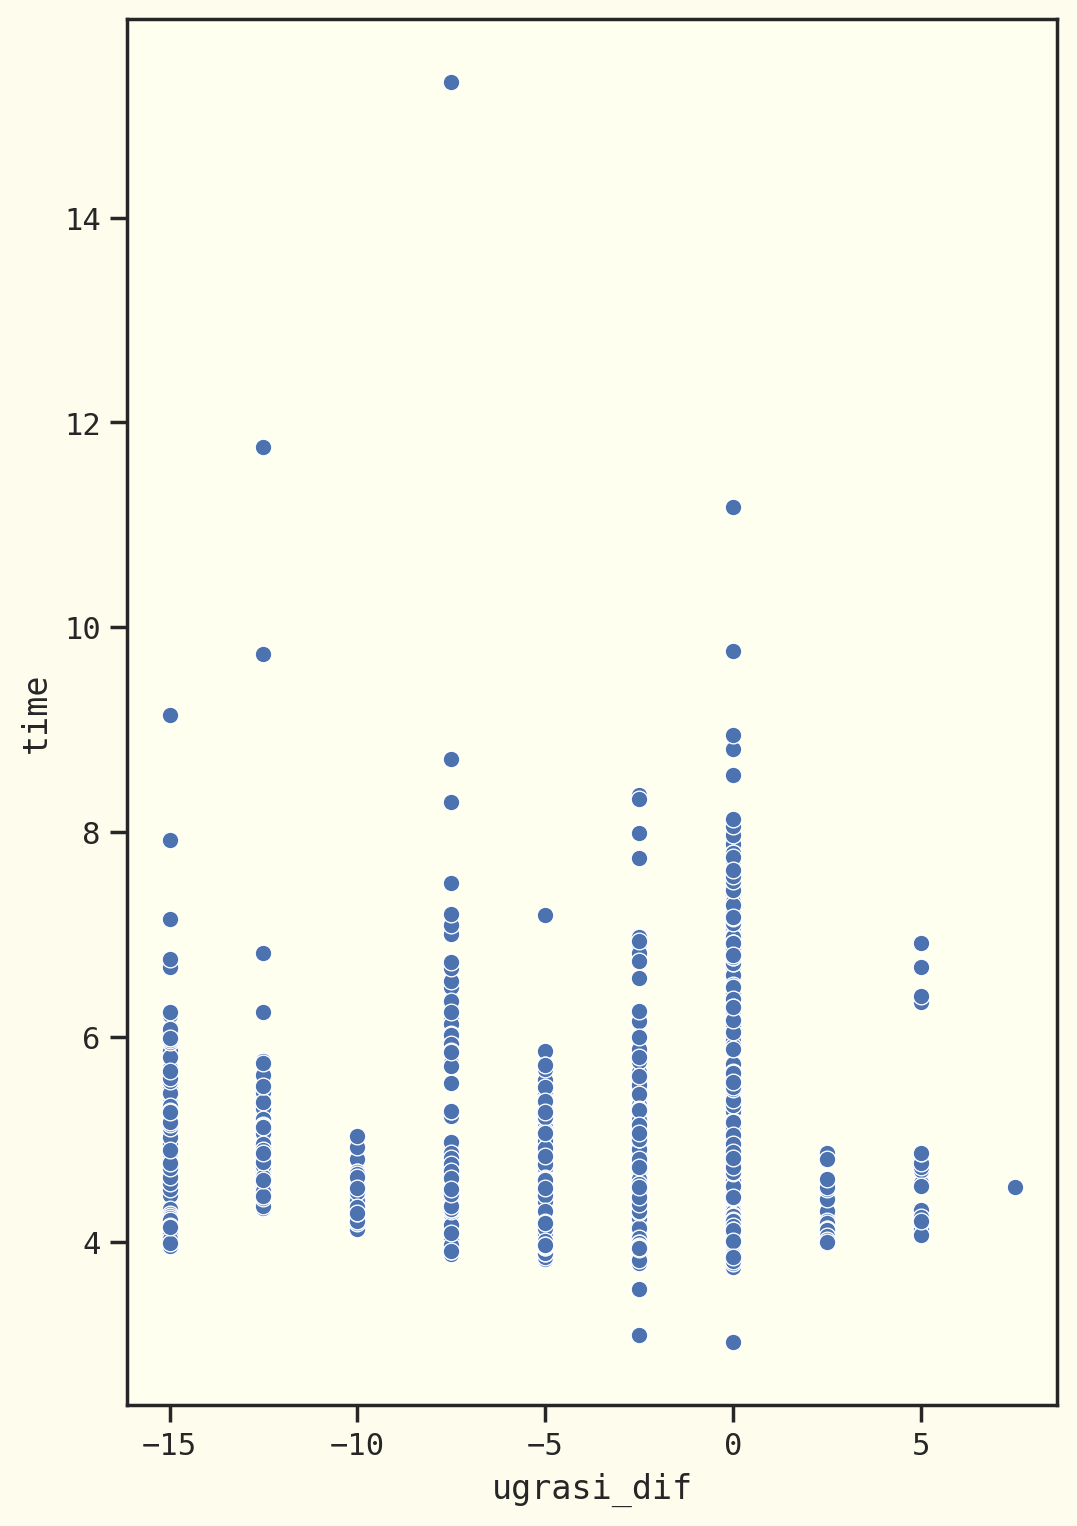

In [109]:
sns.scatterplot(data=df_ugras, x="ugrasi_dif", y="time")

Nem jelenthető ki egyértelműen az, hogy van összefüggés a kutya teljesítménye és az akadály magassága közt. Ez kutyánként eltér, így ezt érdemes külön megvizsgálni később, ha további csapatok kialakítására vagy átalakítására lenne lehetőség

## 4.1.9 Van-e hatása a napszaknak a futási eredményre, azaz délelőtt vagy délután?

In [110]:
df_merged.groupby('napszak')['time'].mean()

napszak
0    4.534302
1    4.469220
Name: time, dtype: float64

In [111]:
df_merged.groupby(['name', 'napszak']).agg(
    {
        'time' : 'mean',
        'city' : 'count',
        'start_error' : 'sum',
        'time_error' : 'sum'
    }
)

time  city  start_error  time_error
name    napszak                                         
Abby    0        4.675200    25            3           0
        1        4.796923    39            7           0
Agnes   0        4.763500    20            1           0
        1        5.507273    12            4           1
Alex    0        4.271961    51            1           0
        1        4.273377    78            5           1
Alfie   0        3.982073    82            5           0
        1        3.998722   135           13           2
Angie   0        5.591667    13            1           1
        1        6.104000    20            2           0
Apollo  0        4.226000     5            1           0
Ashley  0        4.256667    31            2           1
        1        4.310313    32            1           0
Bailey  0        4.798750    60           10           4
        1        4.788980    51           12           2
Bella   0        4.687333    60            5           0
        1        4.738351    99           13           2
Bonnie  0        4.205116    44           10           1
        1        4.252203    60            9           1
Bree    0        4.264706    85           11           0
        1        4.249060   118           15           1
Brix    0        4.550714    14            0           0
        1        4.587308    27            1           1
Brooke  0        4.233962    53            8           0
        1        4.219808   105            9           1
Bruno   0        4.858974    39            3           0
        1        4.794138    29            2           0
Cookies 0        4.170556    19            6           1
        1        4.124783    47           14           1
Dexter  0        4.603659    42            2           1
        1        4.590000    38            6           0
Dixie   0        4.273684    57           12           0
        1        4.280137    73            9           0
Dusty   0        6.490526    19            1           0
        1        6.262000    27            3           2
Easy    0        4.437059    18            3           1
        1        4.489091    23            1           1
Enola   0        3.963158    76            5           0
        1        3.969730   111           11           0
Falco   0        4.177586    62           13           4
        1        4.295000    64           11           6
Fleur   0        4.400000    56            8           0
        1        4.481566    83           14           0
Gerry   0        4.502222    38            3           2
        1        4.562188    32            0           0
Gordon  0        6.941667    73            4           1
        1        7.052791    43            6           0
Hank    0        4.599167    84            8           0
        1        4.579375    81            5           1
Hector  0        4.243623    70            4           1
        1        4.277245   100           20           2
Henry   1        4.730000    12            0           0
Jasper  0        5.888500    22            2           2
        1        6.046471    18            1           1
Jessie  0        5.022500     4            1           0
        1        4.952857     7            2           0
Kent    1        8.140000     9            2           5
Kesha   0        5.290000    31            8           0
        1        5.361429    36            8           1
Maggie  0        4.025714    91           11           0
        1        4.032105   134           14           1
Mason   0        4.730282    71           11           0
        1        4.772105    57            8           0
Milo    0        4.312857     7            3           0
        1        4.363333     3            0           0
Moon    0        3.946383    47            8           0
        1        3.991528    72           12           0
Negro   0        4.940465    43           10           0
        1        5.088537    41

In [112]:
df_merged.groupby(['name', 'date', 'city', 'napszak']).agg(
    {
        'time' : 'mean',
        'city' : 'count'
    }
)

time  city
name    date       city             napszak                
Abby    2023-06-24 Prostějov        0        4.427273    11
                                    1        4.480833    12
        2023-07-01 Nové             0        4.870000    14
                                    1        4.937407    27
Agnes   2023-04-22 Heroltice        0        4.763333    12
                                    1        5.735000     6
        2023-05-06 Žamberk          0        4.763750     8
                                    1        5.234000     6
Alex    2023-04-22 Heroltice        0        4.289286    14
                                    1        4.321818    11
        2023-05-06 Žamberk          0        4.315455    11
                                    1        4.277000    10
        2023-06-24 Prostějov        0        4.168333     6
                                    1        4.281667    24
        2023-07-01 Nové             0        4.313750     8
                                    1        4.291429     7
        2023-09-03 Blšany           0        4.254444     9
                                    1        4.256250     8
        2023-10-14 Vodňany          0        4.180000     3
                                    1        4.228824    18
Alfie   2023-04-22 Heroltice        0        3.956364    11
                                    1        3.970000    15
        2023-05-06 Žamberk          0        3.998750     8
                                    1        3.976667    12
        2023-05-20 Blšany           0        3.946923    13
                                    1        3.921053    19
        2023-06-24 Prostějov        0        4.103333     6
                                    1        4.205833    12
        2023-07-01 Nové             0        3.993333     3
                                    1        4.019524    21
        2023-07-15 Louňovice        0        3.976000    10
                                    1        4.015294    17
        2023-07-30 Tápiószentmárton 0        3.918000     5
                                    1        3.903333     3
        2023-09-03 Blšany           0        4.057143    14
                                    1        4.092000    10
        2023-09-16 Litomyšl         0        4.002500     4
                                    1        3.970000     6
        2023-10-14 Vodňany          0        3.868750     8
                                    1        3.915000    20
Angie   2023-04-22 Heroltice        0        5.215714     8
                                    1        6.665000     6
        2023-05-06 Žamberk          0        6.118000     5
                                    1        6.018889     9
        2023-07-29 Tápiószentmárton 1        5.584000     5
Apollo  2023-07-30 Tápiószentmárton 0        4.226000     5
Ashley  2023-06-24 Prostějov        0        4.363000    10
                                    1        4.320000    11
        2023-07-01 Nové             0        4.195000     7
                                    1        4.331250    16
        2023-09-03 Blšany           0        4.244444     9
                                    1        4.222000     5
        2023-10-14 Vodňany          0        4.140000     5
Bailey  2023-04-22 Heroltice        0        5.122500     8
                                    1        5.408750     8
        2023-05-20 Blšany           0        5.015000     8
                                    1        4.710000     6
        2023-06-24 Prostějov        0        4.758333    12
                                    1        4.848889     9
        2023-07-15 Louňovice        0        4.968333    12
                                    1        4.807143     7
        2023-07-30 Tápiószentmárton 0        4.482000     7
        2023-09-03 Blšany           0        4.407143     7
                                    1        4.521000    10
        2023-09-16 Litomyšl         0        4.613333     6
                             

Mint a magasság esetén, itt is kutyánként eltér ki az akinél van hatása a napszaknak az eredményre, kinek melyik napszak fekszik jobban, illetve az is egyén kérdése, hogy egyáltalán van-e eltérés

## 4.1.10 Típusok közt van különbség. Border Collie jobbat fut mindenkinél?

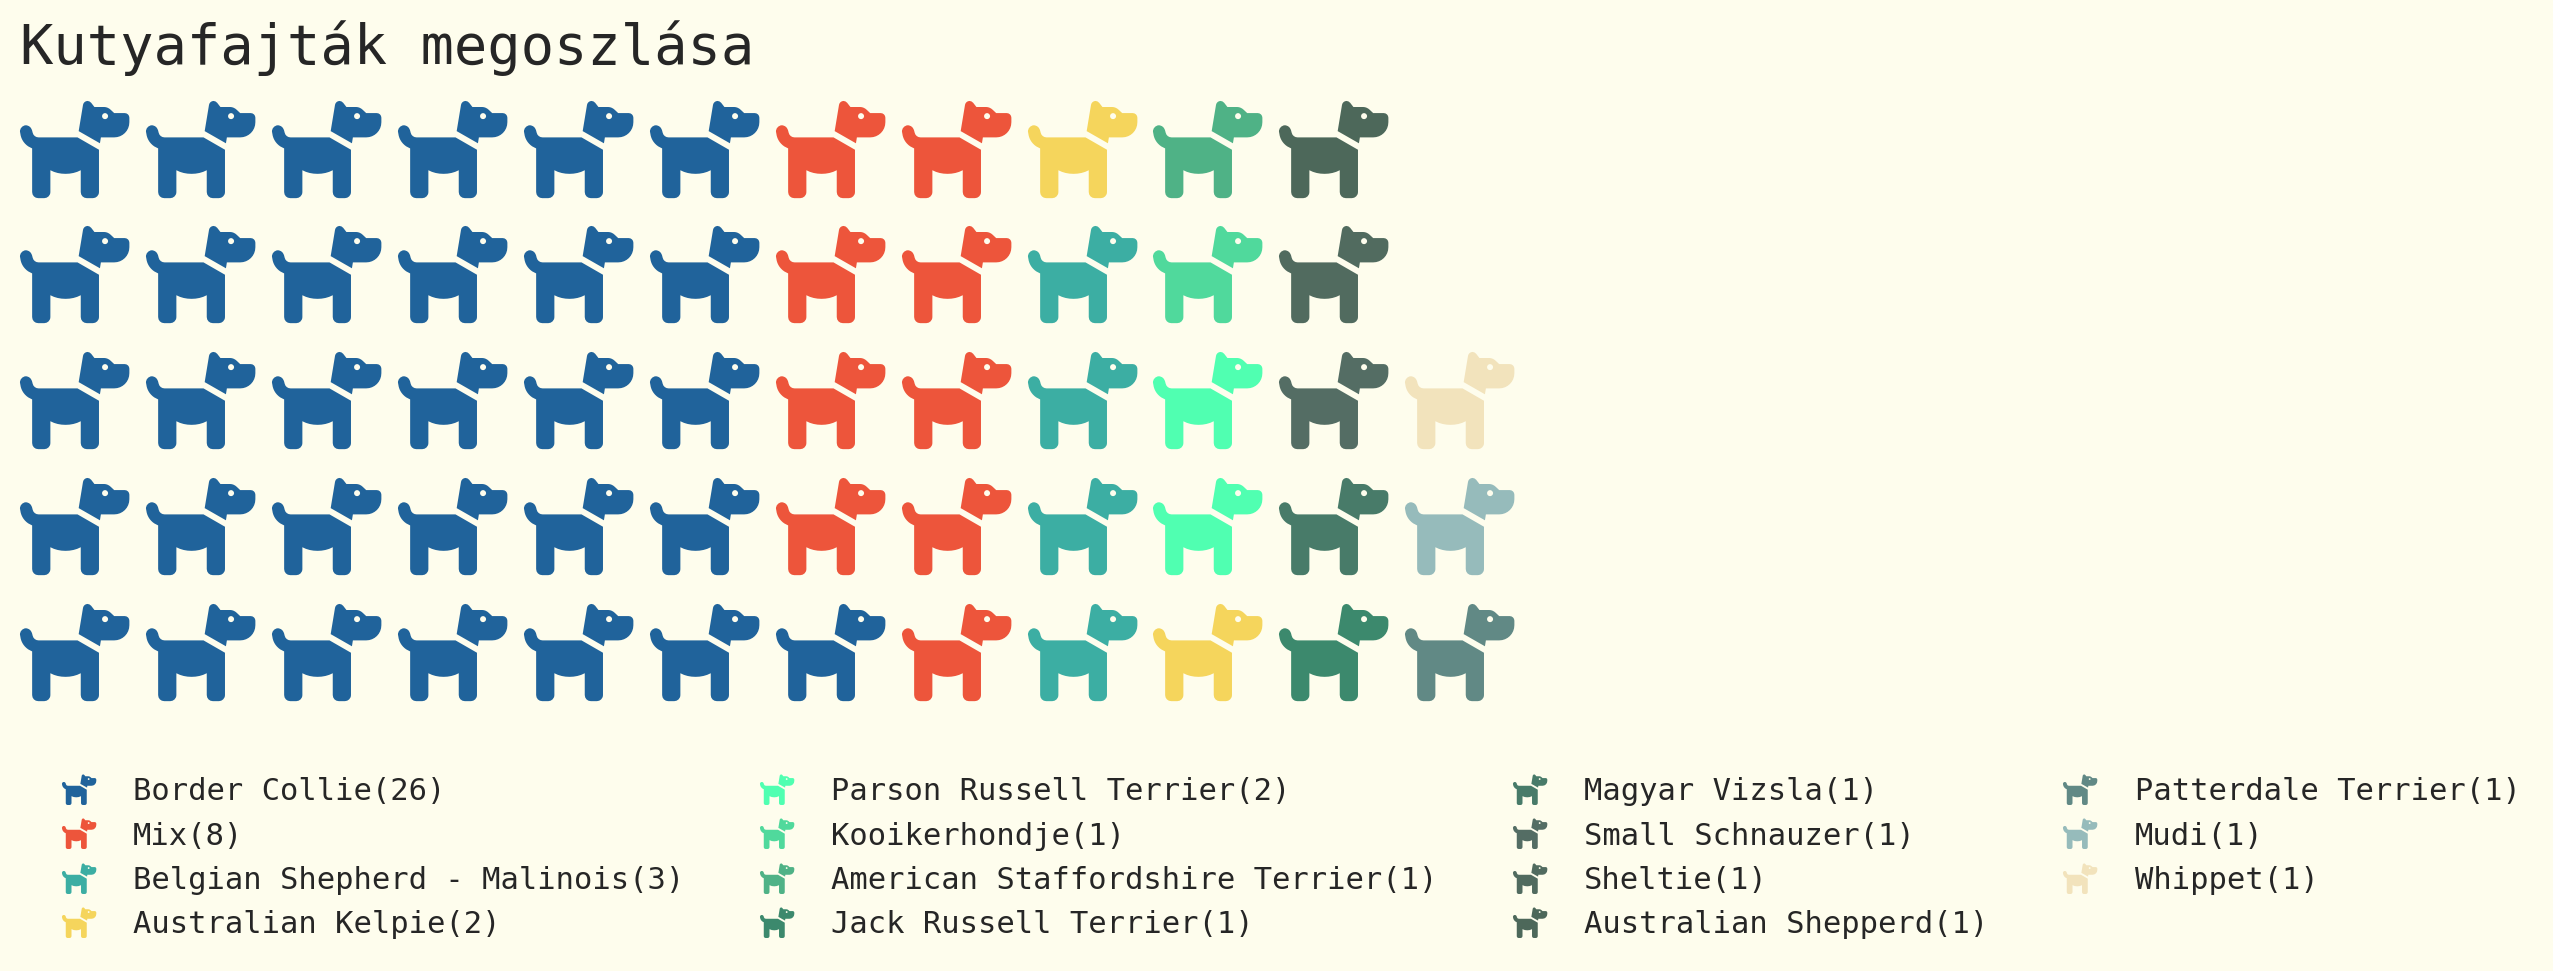

In [113]:
fajta = dogs['fajta'].value_counts()

fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=12,
    values=fajta,
    colors = ('#20639B', '#ED553B', '#3CAEA3', '#F5D55C', '#50FFB1',
              '#50D99C', '#4FB286', '#3C896D', '#487B69', '#546D64',
              '#516B5F', '#4D685A', '#618985', '#96BBBB', '#F2E3BC'),
    title={'label': 'Kutyafajták megoszlása', 'loc': 'left', 'size' : 20},
    labels=["{}({})".format(a, b) for a, b in zip(fajta.index, fajta) ],
    legend={'loc': 'upper left', 'bbox_to_anchor': (0, -0.1), 'ncol': 4, 'framealpha': 0},
    font_size=35, 
    icons = 'dog',
    figsize=(12, 10),  
    icon_legend=True
);

In [114]:
df_merged.groupby('fajta').agg(
    {
        'time' : 'mean',
        'name' : 'nunique',
        'when' : 'count'
    }
).sort_values('time')

time  name  when
fajta                                               
Australian Shepperd             3.992372     1   217
Sheltie                         4.107714     1   140
Whippet                         4.232353     1   104
Belgian Shepherd - Malinois     4.332000     3   371
Australian Kelpie               4.340000     2   136
Border Collie                   4.347728    26  2421
Patterdale Terrier              4.466410     1    41
Kooikerhondje                   4.597089     1    80
American Staffordshire Terrier  4.718854     1   159
Mudi                            4.808864     1    44
Mix                             4.868994     8   547
Small Schnauzer                 5.210000     1     6
Parson Russell Terrier          6.011250     2    58
Jack Russell Terrier            6.983217     1   116

Mivel erősen Border Collie "túlsúlyos" az eloszlás, így mélyebb elemzés esetleg úgy készíthető, hogy minden egyéb kutya az Other kategóriába esik, és úgy áttekinteni további teljesítményre hatással levő változókat.

In [115]:
df_fajta = df_merged.copy()

In [116]:
df_fajta['fajta_o'] = np.where(df_fajta['fajta'] == "Border Collie", df_fajta['fajta'], 'Other')

In [117]:
df_fajta.groupby('fajta_o').agg(
    {
        'time' : 'mean',
        'city' : 'count',
        'start_error' : 'sum',
        'time_error' : 'sum'
    }
)

time  city  start_error  time_error
fajta_o                                               
Border Collie  4.347728  2421          294          49
Other          4.676847  2019          262          27

Elsőre úgy látszik számomra, hogy majdnem 50%-kal hibáznak kevesebbet a nem Border Collie típusú kutyák a futás során, ami egyelőre nem vagyok biztos mennyire ellensúlyozhatja a közel 10%-osan rosszabb futási időt

## 4.1.11 Az életkor hatással van-e az eredményre?

In [118]:
eletkor_time = df_merged.groupby('KorVersenykor').agg(
    {
        'time' : 'mean',
        'name' : 'count'
    }
).sort_values('time').reset_index()

In [119]:
eletkor_time

KorVersenykor      time  name
0               2  4.229447   700
1               5  4.278596  1010
2               4  4.330032   317
3               3  4.425459   577
4               1  4.452556   269
5               6  4.513034   626
6              13  4.597089    80
7               9  4.600625   162
8               7  4.609487   130
9               8  5.280994   529
10             12  5.961081    40

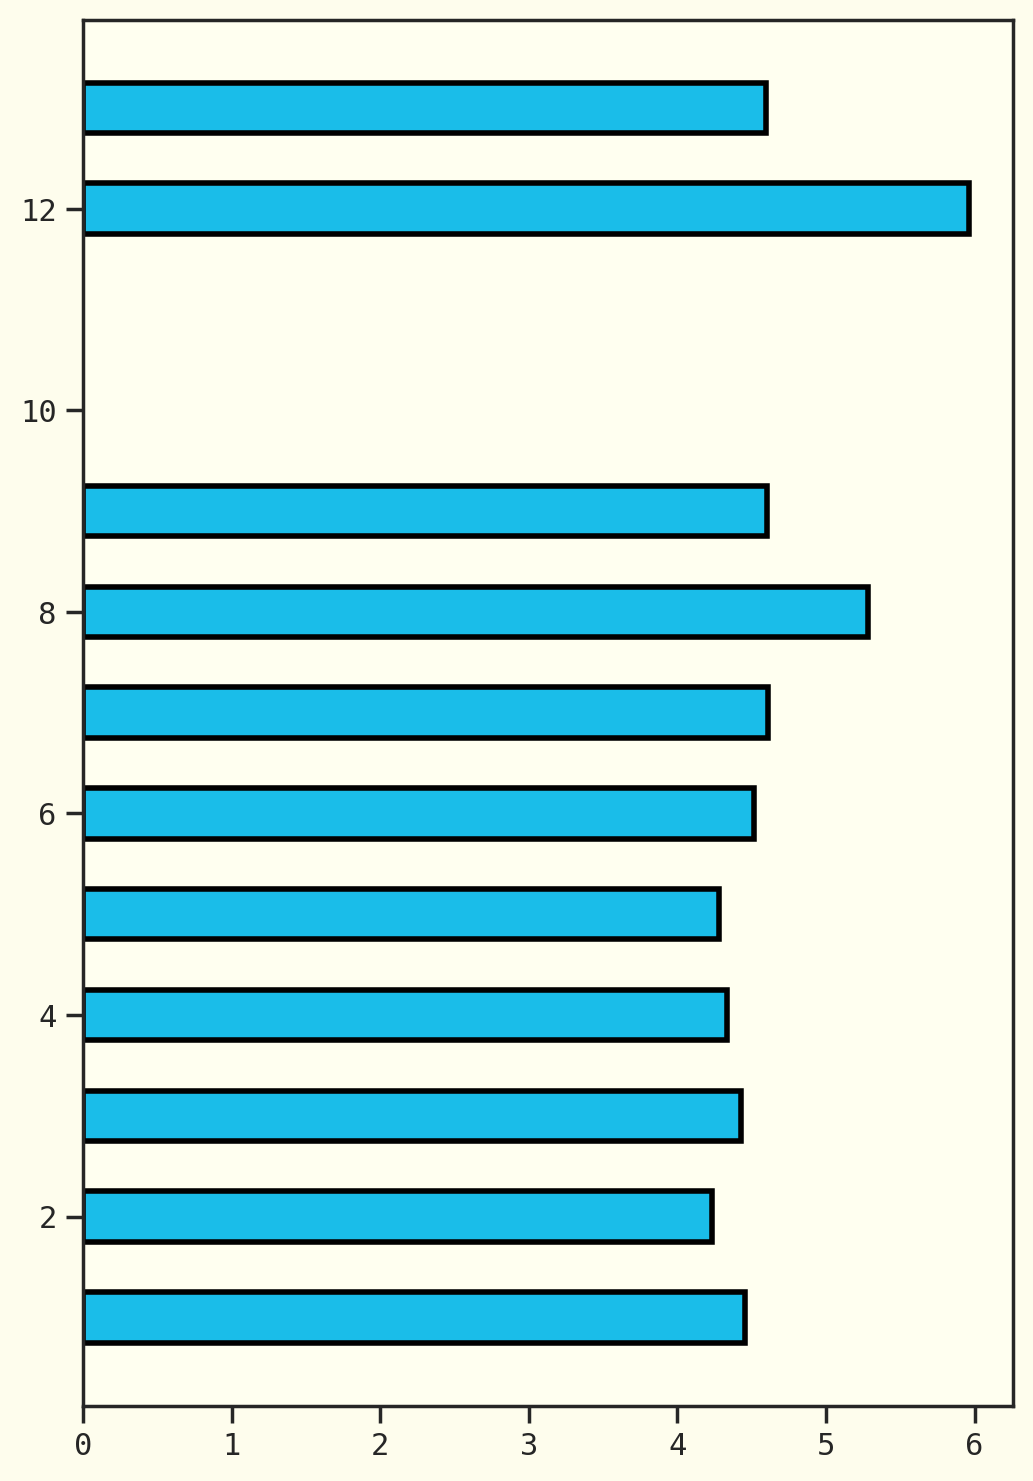

In [120]:
# Egy gyors grafikon a szemléltetés kedvéért, később finomítva lesz
plt.barh(eletkor_time['KorVersenykor'], eletkor_time['time'], 
       color='#1ABDE9',
       edgecolor='black',
       linewidth=2,
       height=0.5,);

In [121]:
# Dátum és város szerint bontva az életkor
df_merged.groupby(['date', 'city', 'KorVersenykor']).agg(
    {
        'time' : 'mean',
        'name' : 'count'
    }
)

time  name
date       city             KorVersenykor                
2023-04-22 Heroltice        1              4.499600    52
                            2              4.196316    79
                            3              4.460968    63
                            4              4.083333    31
                            5              4.361429   168
                            6              4.397917    72
                            7              4.800000    19
                            8              5.318228    80
                            9              4.844474    39
                            12             6.109167    14
                            13             4.821304    23
2023-05-06 Žamberk          1              4.453778    46
                            2              4.109556    45
                            3              4.576518   114
                            4              4.190833    12
                            5              4.285745    94
                            6              4.644909    57
                            7              4.498182    34
                            8              5.256344    94
                            9              5.000000    35
                            13             4.622000    15
2023-05-20 Blšany           2              4.159048    21
                            3              4.476087    73
                            4              4.020417    24
                            5              4.122111    90
                            6              4.193947    79
                            7              4.876667     3
                            8              4.514706    18
2023-06-24 Prostějov        1              4.379286    42
                            2              4.412424   100
                            3              4.310000    81
                            4              4.530816    49
                            5              4.511544   136
                            6              4.660874   103
                            7              4.642500    32
                            8              5.246807   120
                            9              4.259000    30
                            12             5.603846    14
                            13             4.471000    21
2023-07-01 Nové             1              4.368723    47
                            2              4.149600   101
                            3              4.358000    80
                            4              4.624500    60
                            5              4.177059   119
                            6              4.540423    71
                            7              5.004286     7
                            8              5.257581    63
                            9              4.303333    15
                            12             6.200000    12
                            13             4.453810    21
2023-07-15 Louňovice        1              4.621579    19
                            2              4.281250    40
                            3              4.604167    36
                            4              4.111000    20
                            5              4.129231    78
                            6              4.563030    66
                            7              4.622222    19
                            8              6.111429    22
2023-07-29 Tápiószentmárton 2              4.257174    46
                            4              4.531429    15
                            5              4.868636    22
                            6              4.730000    12
                            8              5.040577    52
                            9              5.584000     5
2023-07-30 Tápiószentmárton 2              3.976923    13
                            3              4.396923    13
                            4              3.990000     6
                            5              4.

Az életkor alapján az látszik számomra, hogy kb. 6 éves kor felett érezhető romlás az eredményben ha átlagosan nézzük, ám kutyánként itt is érdemes lehet további elemzést végezni, de ehhez jó lenne látni több év eredményét is

## 4.1.12 Az ivartalan kutyák jobban teljesítenek?

In [122]:
df_merged.groupby('ivar')['time'].mean()

ivar
ivaros       4.439420
ivartalan    4.514204
Name: time, dtype: float64

In [123]:
eredmeny = df_merged.groupby('ivar').agg(
    {
        'time' : 'mean',
        'city' : 'count',
        'start_error' : 'sum',
        'time_error' : 'sum'
    }
).reset_index()


In [124]:
eredmeny

ivar      time  city  start_error  time_error
0     ivaros  4.439420   966          159          18
1  ivartalan  4.514204  3474          397          58

In [125]:
eredmeny['hiba%'] = round((eredmeny['time_error'] / eredmeny['city']) * 100, 1)

In [126]:
eredmeny

ivar      time  city  start_error  time_error  hiba%
0     ivaros  4.439420   966          159          18    1.9
1  ivartalan  4.514204  3474          397          58    1.7

In [127]:
eredmeny = df_merged.groupby(['ivar', 'fajta']).agg(
    {
        'time' : 'mean',
        'city' : 'count',
        'start_error' : 'sum',
        'time_error' : 'sum'
    }
).reset_index()

eredmeny['hiba%'] = round((eredmeny['time_error'] / eredmeny['city']) * 100, 1)
eredmeny

ivar                           fajta      time  city  start_error  \
0      ivaros               Australian Kelpie  4.137656    66           20   
1      ivaros                   Border Collie  4.321709   514           77   
2      ivaros                             Mix  4.806638   238           28   
3      ivaros                            Mudi  4.808864    44           15   
4      ivaros                         Whippet  4.232353   104           19   
5   ivartalan  American Staffordshire Terrier  4.718854   159           18   
6   ivartalan               Australian Kelpie  4.530441    70            3   
7   ivartalan             Australian Shepperd  3.992372   217           18   
8   ivartalan     Belgian Shepherd - Malinois  4.332000   371           50   
9   ivartalan                   Border Collie  4.354836  1907          217   
10  ivartalan            Jack Russell Terrier  6.983217   116           10   
11  ivartalan                   Kooikerhondje  4.597089    80            8   
12  ivartalan                             Mix  4.915357   309           50   
13  ivartalan          Parson Russell Terrier  6.011250    58            4   
14  ivartalan              Patterdale Terrier  4.466410    41            4   
15  ivartalan                         Sheltie  4.107714   140           15   
16  ivartalan                 Small Schnauzer  5.210000     6            0   

    time_error  hiba%  
0            2    3.0  
1            5    1.0  
2            9    3.8  
3            0    0.0  
4            2    1.9  
5            2    1.3  
6            2    2.9  
7            2    0.9  
8            1    0.3  
9           44    2.3  
10           1    0.9  
11           1    1.2  
12           1    0.3  
13           2    3.4  
14           2    4.9  
15           0    0.0  
16           0    0.0

Nem tapasztalok egyik irányban sem olyan eltérést, amely alátámasztaná, hogy az ivaros vagy ivartalan kutyák jobb eredményt érnének el

## 4.1.13 Nöstény vagy kan kutya fut-e jobb eredményt, illetve mit látni hibázási szempontból?

In [128]:
df_merged.groupby('nem')['time'].mean()

nem
Kan      4.690874
Szuka    4.302372
Name: time, dtype: float64

Elsőre úgy tűnik, hogy a szuka kutyák majdnem 10%-kal jobb eredményt futnak

In [129]:
df_merged.groupby(['KorVersenykor', 'fajta', 'nem']).agg(
    {
        'time' : 'mean',
        'city' : 'count',
        'start_error' : 'sum',
        'time_error' : 'sum'
    }
).reset_index()

KorVersenykor                           fajta    nem      time  city  \
0               1                             Mix    Kan  4.589512   165   
1               1                         Whippet  Szuka  4.232353   104   
2               2               Australian Kelpie    Kan  4.137656    66   
3               2     Belgian Shepherd - Malinois  Szuka  4.255644   203   
4               2                   Border Collie    Kan  4.189606   259   
5               2                   Border Collie  Szuka  3.973697   119   
6               2                             Mix    Kan  8.140000     9   
7               2                            Mudi    Kan  4.808864    44   
8               3     Belgian Shepherd - Malinois  Szuka  4.079145   117   
9               3                   Border Collie    Kan  5.327879    67   
10              3                   Border Collie  Szuka  4.188431   265   
11              3                             Mix    Kan  4.748906   128   
12              4                   Border Collie    Kan  4.525200    51   
13              4                   Border Collie  Szuka  4.262422   225   
14              4              Patterdale Terrier    Kan  4.466410    41   
15              5             Australian Shepperd  Szuka  3.992372   217   
16              5     Belgian Shepherd - Malinois    Kan  5.214510    51   
17              5                   Border Collie    Kan  4.394702   507   
18              5                   Border Collie  Szuka  4.029509   225   
19              5                             Mix    Kan  5.387000    10   
20              6                   Border Collie  Szuka  4.308686   358   
21              6                             Mix    Kan  5.171803    64   
22              6          Parson Russell Terrier    Kan  4.730000    12   
23              6          Parson Russell Terrier  Szuka  6.360682    46   
24              6                         Sheltie    Kan  4.107714   140   
25              6                 Small Schnauzer  Szuka  5.210000     6   
26              7               Australian Kelpie    Kan  4.530441    70   
27              7                   Border Collie    Kan  4.747619    32   
28              7                   Border Collie  Szuka  4.978182    11   
29              7                             Mix  Szuka  4.516471    17   
30              8  American Staffordshire Terrier  Szuka  4.718854   159   
31              8                   Border Collie    Kan  4.226000     5   
32              8                   Border Collie  Szuka  4.532043    95   
33              8            Jack Russell Terrier    Kan  6.983217   116   
34              8                             Mix    Kan  5.068105   154   
35              9                   Border Collie    Kan  4.272812   129   
36              9                   Border Collie  Szuka  5.911875    33   
37             12                   Border Collie    Kan  5.961081    40   
38             13                   Kooikerhondje    Kan  4.597089    80   

    start_error  time_error  
0            13           1  
1            19           2  
2            20           2  
3            26           1  
4            25           5  
5            20           0  
6             2           5  
7            15           0  
8            19           0  
9            16           1  
10           38          10  
11           19           0  
12            4           1  
13           25           2  
14            4           2  
15           18           2  
16            5           0  
17           72           3  
18           25           1  
19            0           0  
20           43           8  
21           13           3  
22            0           0  
23            4           2  
24           15           0  
25            0           0  
26            3           2  
27            2          11  
28            3           0  
29            7           0  
30           18           2  
31 

Kicsit részletesebben megvizsgálva, és pár tulajdonságot kiemelve továbbra is az látható, hogy a szukák jobb eredményre képesek, ám érdekes módon, bár ez függhet a kutyától is, de 6 éves kór felett mintha lenne ebben egy fordulat, így felette már a kan-ok jobban teljesítenek azonos fajtán belül.

## 4.1.14 Van-e különbség az eredményben a pálya "színét" tekintve?

In [130]:
df_merged.groupby(['name', 'szin']).agg(
    {
        'time' : 'mean',
        'when' : 'count'
    }
).sort_values('time')

time  when
name    szin                
Enola   0     3.952424    99
Moon    1     3.970169    59
        0     3.977167    60
Enola   1     3.983523    88
Alfie   1     3.991345   120
        0     3.993646    97
Maggie  1     4.024017   118
        0     4.035514   107
Tyna    1     4.062824    85
Sunny   1     4.068197    61
Tyna    0     4.070541    76
Cookies 1     4.076667    32
Sirius  0     4.085000    48
Sunny   0     4.091071    56
Pax     0     4.098784    74
        1     4.117727    66
Nina    1     4.147848    79
        0     4.149333    60
Sirius  1     4.176275    53
Apollo  1     4.185000     2
Cookies 0     4.191471    34
Brooke  1     4.211932    89
Falco   1     4.217500    59
Bonnie  1     4.217556    45
Brooke  0     4.240725    69
Bonnie  0     4.244035    59
Bree    1     4.244220   110
Hector  1     4.249417   105
Falco   0     4.251563    67
Apollo  0     4.253333     3
Alex    0     4.261803    61
Dixie   1     4.267917    72
Bree    0     4.269032    93
Ashley  0     4.282195    42
Alex    1     4.282836    68
Hector  0     4.285781    65
Ashley  1     4.288571    21
Dixie   0     4.288966    58
Milo    1     4.328000    10
Fleur   0     4.445789    76
Easy    1     4.446429    15
Fleur   1     4.452222    63
Easy    0     4.477600    26
Riley   1     4.506667     6
Gerry   0     4.508684    39
Riley   0     4.521818    11
Sara    0     4.522286    36
Dexter  1     4.522812    33
Brix    1     4.540000    24
Sara    1     4.544783    24
Gerry   1     4.558000    31
Hank    0     4.587573   103
        1     4.592787    62
Brix    0     4.621176    17
Dexter  0     4.647660    47
Abby    0     4.651000    40
Jessie  0     4.670000     1
Bella   1     4.702468    79
Henry   0     4.705000     4
Ted     1     4.708182    13
Bella   0     4.734625    80
Mason   1     4.739833    60
Henry   1     4.742500     8
Mason   0     4.756912    68
Bailey  1     4.761600    52
Ted     0     4.791000    19
Scotty  0     4.803214    28
Bruno   0     4.813030    33
Scotty  1     4.818750    16
Bailey  0     4.823818    59
Bruno   1     4.848571    35
Agnes   1     4.860833    13
Abby    1     4.913333    24
Negro   0     4.973721    43
Jessie  1     5.009000    10
Negro   1     5.053659    41
Rex     0     5.061515    33
Speedy  0     5.076667    43
Punk    0     5.093333     3
Agnes   0     5.132632    19
Rocky   1     5.193939    33
Speedy  1     5.227037    27
Rocky   0     5.252222    18
Rex     1     5.301786    31
Kesha   0     5.317586    30
Punk    1     5.326667     3
Kesha   1     5.335946    37
Them    1     5.387000    10
Angie   1     5.831875    17
Jasper  1     5.930952    24
Angie   0     5.991875    16
Jasper  0     6.000625    16
Dusty   0     6.322667    15
        1     6.380345    31
Gordon  1     6.959385    66
        0     7.014200    50
Kent    0     8.140000     6
        1          NaN     3

Az eredmények alapján nem látok szignifikáns eltérést a pályák közt

## 4.1.15 Ellenkező nemre való ráváltás hatással van-e az eredményére a kutyának?

In [131]:
szamok = range(1, len(dogs.nem.unique())+1)
nem_szamokkal = dict(zip(dogs.nem.unique(), szamok))

In [132]:
nem_szamokkal

{'Kan': 1, 'Szuka': 2}

In [133]:
df_merged['nem_szam'] = df_merged['nem'].map(nem_szamokkal)

In [134]:
columns = ['when', 'name', 'time', 'ordinal_no', 'nem_szam']

In [135]:
df_valtas = df_merged[columns]

In [136]:
df_valtas['next_nem_szam'] = df_valtas.groupby('when')['nem_szam'].shift()

# Feltétel ellenőrzése: Ha a következő kutya nemének száma eltér
df_valtas['elozo_eltero_nem'] = (df_valtas['nem_szam'] != df_valtas['next_nem_szam']) & (df_valtas['next_nem_szam'].notnull())

# Eredmény kiíratása
print(df_valtas[['when', 'name', 'time', 'ordinal_no', 'nem_szam', 'elozo_eltero_nem']])


          when     name  time  ordinal_no  nem_szam  elozo_eltero_nem
0     10:11:57    Sunny  4.21           1         2             False
1     10:11:57    Dixie  4.24           2         1              True
2     10:11:57     Alex  4.22           3         1             False
3     10:11:57   Hector  4.13           4         1             False
4     10:11:57   Brooke  4.08           1         1             False
...        ...      ...   ...         ...       ...               ...
4435  10:23:49   Bailey  4.49           4         2              True
4436  10:24:43  Cookies  3.85           1         1             False
4437  10:24:43    Mason  4.82           2         1             False
4438  10:24:43    Fleur  4.44           3         1             False
4439  10:24:43   Bailey  4.54           4         2              True

[4440 rows x 6 columns]


/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/551515873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valtas['next_nem_szam'] = df_valtas.groupby('when')['nem_szam'].shift()
/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/551515873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valtas['elozo_eltero_nem'] = (df_valtas['nem_szam'] != df_valtas['next_nem_szam']) & (df_valtas['next_nem_szam'].notnull())


In [137]:
df_eltero = df_valtas.groupby('name').agg(
    {
        'time' : lambda x: x[df_valtas.loc[x.index, 'elozo_eltero_nem'] == True].mean(),
        'ordinal_no' : lambda x: x[df_valtas.loc[x.index, 'elozo_eltero_nem'] == True].count()
    }
)

In [138]:
df_origin = df_merged.groupby('name').agg(
    {
        'time' : 'mean',
        'ordinal_no' : 'count'
    }
)

In [139]:
df_valtas = df_origin.merge(df_eltero, on='name', how='left').reset_index()

In [140]:
df_valtas['time_diff'] = df_valtas['time_x'] - df_valtas['time_y']
df_valtas['time%'] = np.round((np.where(df_valtas['time_x'] > df_valtas['time_y'], df_valtas['time_x'] / df_valtas['time_y'],
                              df_valtas['time_y'] / df_valtas['time_x']) - 1) * 100, 2)

In [141]:
df_valtas.sort_values('time%', ascending=False)

name    time_x  ordinal_no_x    time_y  ordinal_no_y  time_diff  time%
29     Kent  8.140000             9  6.240000             3   1.900000  30.45
14  Cookies  4.137656            66  5.061667             6  -0.924010  22.33
1     Agnes  5.027419            32  4.797083            25   0.230336   4.80
4     Angie  5.911875            33  6.175455            22  -0.263580   4.46
44   Sirius  4.132990           101  3.982500            36   0.150490   3.78
6    Ashley  4.284355            63  4.140000             5   0.144355   3.49
47      Ted  4.747619            32  4.890000             9  -0.142381   3.00
41    Rocky  5.214510            51  5.077500             4   0.137010   2.70
43   Scotty  4.808864            44  4.683333             3   0.125530   2.68
21    Fleur  4.448705           139  4.559744            39  -0.111039   2.50
20    Falco  4.236293           126  4.333137            55  -0.096844   2.29
38     Punk  5.210000             6  5.093333             3   0.116667   2.29
24     Hank  4.589512           165  4.690000             4  -0.100488   2.19
7    Bailey  4.794190           111  4.707391            96   0.086799   1.84
15   Dexter  4.597089            80  4.680000             4  -0.082911   1.80
18     Easy  4.466410            41  4.400000             1   0.066410   1.51
31   Maggie  4.029509           225  3.979535            44   0.049974   1.26
45   Speedy  5.135507            70  5.080909            33   0.054598   1.07
35    Negro  5.012738            84  5.063158            19  -0.050420   1.01
27   Jasper  5.961081            40  6.020000             4  -0.058919   0.99
46    Sunny  4.079145           117  4.117500             4  -0.038355   0.94
33     Milo  4.328000            10  4.363333             3  -0.035333   0.82
22    Gerry  4.530441            70  4.493529            34   0.036912   0.82
9    Bonnie  4.232353           104  4.264839            32  -0.032486   0.77
49     Tyna  4.066415           161  4.035882            17   0.030533   0.76
42     Sara  4.531207            60  4.565000            16  -0.033793   0.75
3     Alfie  3.992372           217  3.966136            89   0.026236   0.66
37      Pax  4.107714           140  4.133981           108  -0.026267   0.64
30    Kesha  5.327879            67  5.362041            49  -0.034162   0.64
36     Nina  4.148489           139  4.124667            15   0.023823   0.58
12   Brooke  4.224586           158  4.200200            50   0.024386   0.58
23   Gordon  6.983217           116  7.019091            34  -0.035874   0.51
10     Bree  4.255644           203  4.235556           145   0.020088   0.47
2      Alex  4.272812           129  4.259375            49   0.013437   0.32
19    Enola  3.967059           187  3.978378            37  -0.011320   0.29
13    Bruno  4.831324            68  4.817586            29   0.013737   0.29
0      Abby  4.749375            64  4.736667            36   0.012708   0.27
16    Dixie  4.277308           130  4.266164            73   0.011143   0.26
17    Dusty  6.360682            46  6.371905            44  -0.011223   0.18
40    Riley  4.516471            17  4.520000             7  -0.003529   0.08
8     Bella  4.718854           159  4.715109            92   0.003745   0.08
25   Hector  4.263353           170  4.265821            67  -0.002468   0.06
32    Mason  4.748906           128  4.749737            38  -0.000831   0.02
26    Henry  4.730000            12  4.730000            12   0.000000   0.00
5    Apollo  4.226000             5  4.226000             5   0.000000   0.00
11     Brix  4.574500            41       NaN             0        NaN    NaN
28   Jessie  4.978182            11       NaN             0        NaN    NaN
34     Moon  3.973697           119       NaN             0        NaN    NaN
39      Rex  5.171803            64       NaN             0        NaN    NaN
48     Them  5.387000            10       NaN             0        NaN    NaN

/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/2715235289.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(valt_df.name, rotation=90)


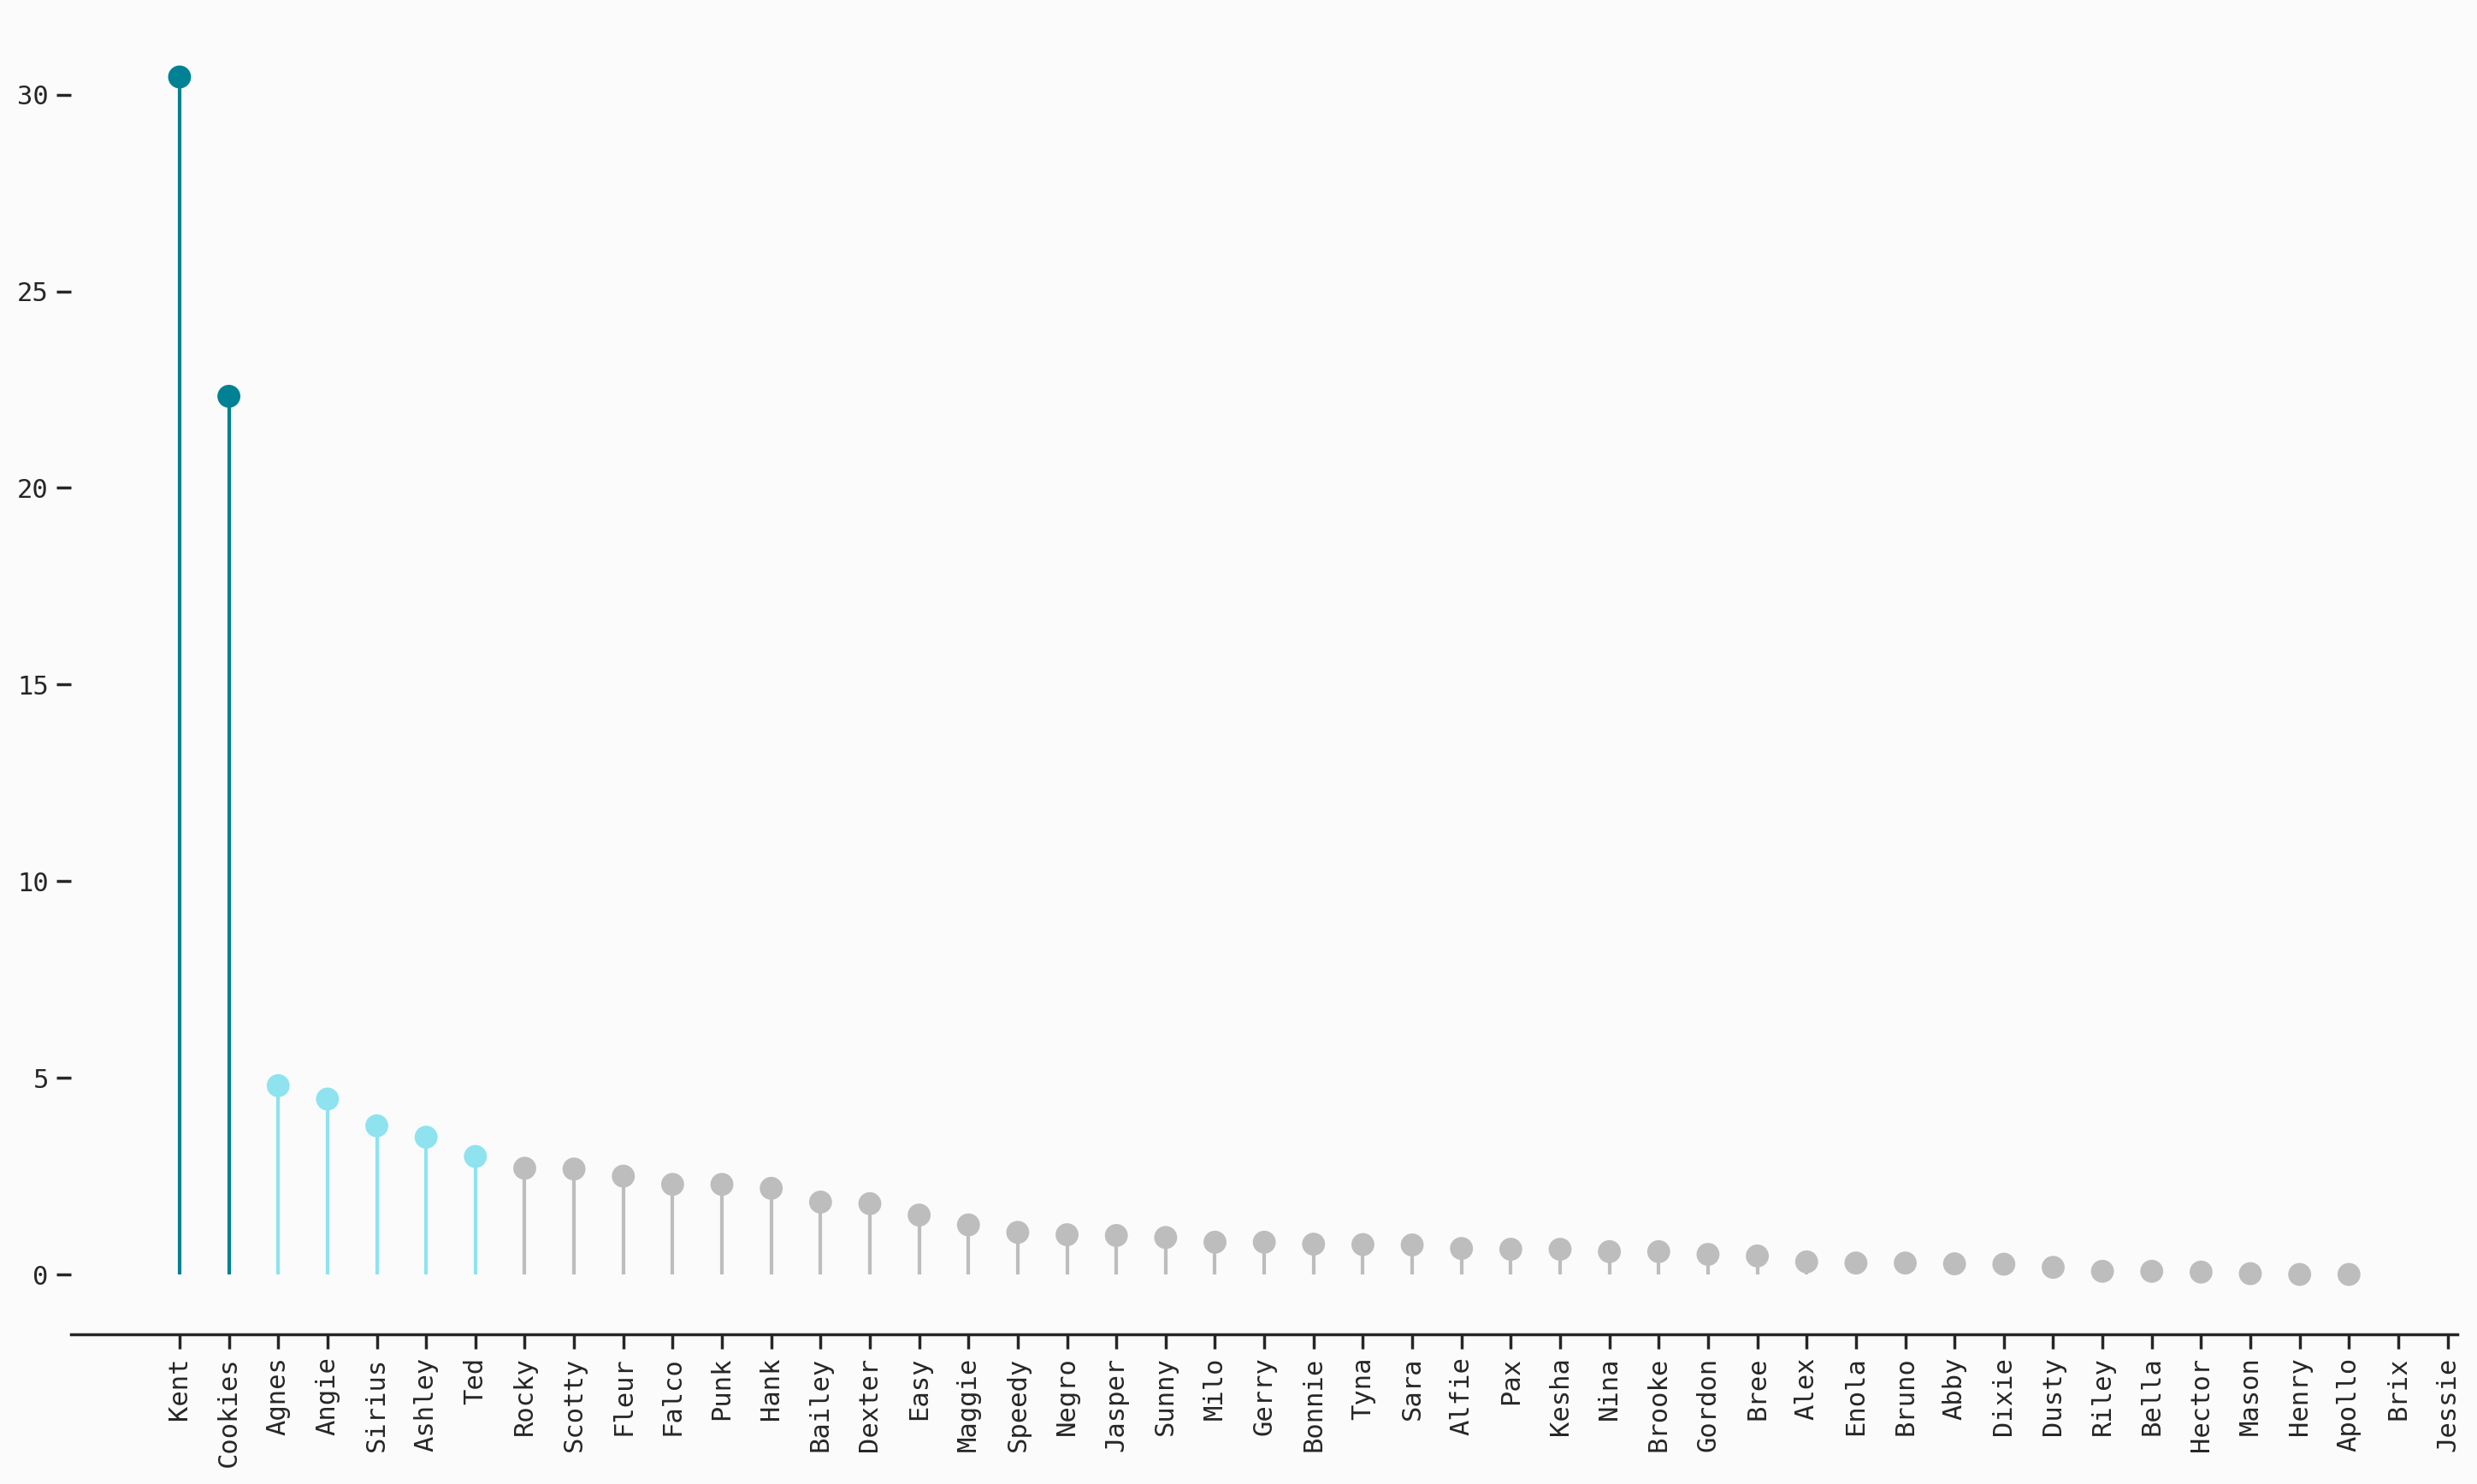

In [142]:
fig = plt.figure(figsize=(18,10)) # create figure
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color

color_map = ["#bdbdbd" for _ in range(50)]
color_map[0] = "#008294"
color_map[1] = "#008294"
color_map[2] = "#8EE3EF"
color_map[3] = "#8EE3EF"
color_map[4] = "#8EE3EF"
color_map[5] = "#8EE3EF"
color_map[6] = "#8EE3EF"

valt_df = df_valtas.sort_values('time%', ascending=False)
ax0.vlines(x=valt_df.name, ymin=0, ymax=valt_df["time%"], color=color_map)
ax0.scatter(x=valt_df.name, y=valt_df["time%"], s=75, color=color_map)
ax0.set_xticklabels(valt_df.name, rotation=90)

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

Két olyan kutya van, amely esetén amennyiben ellenkező neműre váltottak rá, akkor közel 30%-os eltérés volt az idejükben, Kent esetében pozitív, míg Cookies esetében negatív irányban. Mindkét esetben azonban alacsony volt a számossága ezeknek az eseteknek, így messzemenő következtetést levonni ezek alapján véleményem szerint nem lehet.
A többiek esetében maximum 5%-os eltérés észrevehető, van ahol pozitív és van ahol negatív irányban.

## 4.1.16 A kutyák kapcsolati hálója, azaz ki kivel fut esetleg jobb időt?

Azt igyekeztem megvizsgálni, hogy van-e olyan kapcsolat a kutyák közt a futások eredményei alapján, amely szerint akár új csoportok összeállítására lehetne javaslatot tenni.

In [143]:
dogs_network = df_merged.copy()

In [144]:
# Az új oszlop létrehozása, ahol az értékek alapértelmezetten NaN
dogs_network['next_name'] = np.nan

# Végigiterálunk a DataFrame indexein, kivéve az utolsót, mert annak nincs következő sora
for i in dogs_network.index[:-1]:
    if (dogs_network.loc[i, 'when'] == dogs_network.loc[i + 1, 'when']) and (dogs_network.loc[i, 'who'] == dogs_network.loc[i + 1, 'who']):
        dogs_network.loc[i, 'next_name'] = dogs_network.loc[i + 1, 'name']

/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/1089252721.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Dixie' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dogs_network.loc[i, 'next_name'] = dogs_network.loc[i + 1, 'name']


In [145]:
# Az új oszlop létrehozása, ahol az értékek alapértelmezetten NaN
dogs_network['next_time'] = np.nan

# Végigiterálunk a DataFrame indexein, kivéve az utolsót, mert annak nincs következő sora
for i in dogs_network.index[:-1]:
    if (dogs_network.loc[i, 'when'] == dogs_network.loc[i + 1, 'when']) and (dogs_network.loc[i, 'who'] == dogs_network.loc[i + 1, 'who']):
        dogs_network.loc[i, 'next_time'] = dogs_network.loc[i + 1, 'time']

In [146]:
dogs_network.head()

city        race_name       date      when  Division  \
0  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
1  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
2  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
3  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   
4  Heroltice  Hanácké škvarek 2023-04-22  10:11:57         1   

                    who  total_time  Hurdles    name  start  time  ordinal_no  \
0  Wildrunners Dreamers       17.01     25.0   Sunny  -0.24  4.21           1   
1  Wildrunners Dreamers       17.01     25.0   Dixie   0.30  4.24           2   
2  Wildrunners Dreamers       17.01     25.0    Alex   0.16  4.22           3   
3  Wildrunners Dreamers       17.01     25.0  Hector   0.00  4.13           4   
4  Wildrunners Maximini       19.43     25.0  Brooke  -0.11  4.08           1   

                                   dogs  szin  start_error  time_error  \
0  ['Sunny', 'Dixie', 'Alex', 'Hector']     0         True       False   
1  ['Sunny', 'Dixie', 'Alex', 'Hector']     0        False       False   
2  ['Sunny', 'Dixie', 'Alex', 'Hector']     0        False       False   
3  ['Sunny', 'Dixie', 'Alex', 'Hector']     0        False       False   
4  ['Brooke', 'Rocky', 'Bella', 'Bree']     1         True       False   

   start_outlier  outlier  napszak  year  month  day  hour  wlt felvezeto  \
0              1        0        0  2023      4   22    10    0  GB900808   
1              0        0        0  2023      4   22    10    0  LZ800202   
2              0        0        0  2023      4   22    10    0  ZE801127   
3              0        0        0  2023      4   22    10    0  UO880828   
4              1        0        0  2023      4   22    10    0  MJ930217   

                         fajta    nem       ivar szuletesi_datum  \
0  Belgian Shepherd - Malinois  Szuka  ivartalan      2020-09-10   
1                Border Collie    Kan  ivartalan      2018-12-22   
2                Border Collie    Kan  ivartalan      2014-04-22   
3                Border Collie    Kan     ivaros      2018-08-02   
4                Border Collie    Kan     ivaros      2021-10-20   

        chip_szam  ulna_hossz  ugrasi_magassag  KorVersenykor  nem_szam  \
0  93900009650506       18.00             30.0              3         2   
1  93900002523549       14.36             25.0              5         1   
2  93900003598960       17.95             30.0              9         1   
3  93900003589833       18.00             30.0              5         1   
4  93900005854271       17.08             30.0              2         1   

  next_name  next_time  
0     Dixie       4.24  
1      Alex       4.22  
2    Hector       4.13  
3       NaN        NaN  
4     Rocky       5.15

In [147]:
dogs_network['2dogs_time_mean'] = (dogs_network['time'] + dogs_network['next_time']) / 2
dogs_network['2dogs_time_sum'] = dogs_network['time'] + dogs_network['next_time']

In [148]:
dogs_g = dogs_network.groupby(['name', 'next_name'])['when'].count().reset_index()

In [149]:
# Ez még folyamatban, a nyilat próbálom felhelyezni

# bgcolor="#222222",
got_net = Network(height="950px", width="100%", bgcolor="white", font_color="black", notebook=True, cdn_resources='in_line', directed=True)

# set the physics layout of the network
got_net.barnes_hut()

sources = dogs_g['name']
targets = dogs_g['next_name']
weights = dogs_g['when']

edge_data = zip(sources, targets, weights)

for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]

                got_net.add_node(src, src, title=src, color='black')
                got_net.add_node(dst, dst, title=dst, color='green')
                got_net.add_edge(src, dst, value=w)

neighbor_map = got_net.get_adj_list()

# add neighbor data to node hover data
for node in got_net.nodes:
        node["title"] += " Neighbors: " + ", ".join(neighbor_map[node["id"]])
        node["value"] = len(neighbor_map[node["id"]])
        if node['value'] > 10:
            #node['color'] = 'red'
            node["font"]={"size": 100}
got_net.show_buttons(filter_=['physics'])

got_net.show("dogs.html")

## Fekete, ha mindig ő fut előbb, piros, ha is-is

dogs.html


In [150]:
dogs_t = dogs_network.groupby(['name', 'next_name']).agg(
    {
        '2dogs_time_mean' : 'mean',
        'when' : 'count',
        '2dogs_time_sum' : 'mean'
    }
).reset_index().sort_values('2dogs_time_mean')

In [151]:
dogs_t['rank'] = dogs_t['2dogs_time_mean'].rank()

In [152]:
dogs_t['2dogs_time_mean'].quantile([0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 0.9])

0.20    4.176000
0.30    4.299333
0.40    4.372667
0.50    4.465000
0.60    4.618008
0.75    4.905938
0.90    5.703125
Name: 2dogs_time_mean, dtype: float64

In [153]:
dogs_t['class'] = np.where(dogs_t['2dogs_time_mean']<4.05, 500,
                   np.where(dogs_t['2dogs_time_mean']<4.176, 350,
              np.where(dogs_t['2dogs_time_mean']<4.50, 30,
            np.where(dogs_t['2dogs_time_mean']<4.7, 20,        
              np.where(dogs_t['2dogs_time_mean']<5, 10, 0.5)))))

In [154]:
dogs_t

name next_name  2dogs_time_mean  when  2dogs_time_sum   rank  class
238   Sirius      Tyna         3.925000     3        7.850000    1.0  500.0
99     Enola     Alfie         3.927083    36        7.854167    2.0  500.0
235   Sirius     Alfie         3.931739    24        7.863478    3.0  500.0
77   Cookies    Maggie         3.933462    14        7.866923    4.0  500.0
177   Maggie    Sirius         3.969688    33        7.939375    5.0  500.0
250     Tyna      Moon         3.981111     9        7.962222    6.0  500.0
102    Enola      Moon         3.984455   110        7.968909    7.0  500.0
76   Cookies     Enola         3.994000    21        7.988000    8.0  500.0
192     Moon    Maggie         3.996279    43        7.992558    9.0  500.0
101    Enola    Maggie         4.001842    38        8.003684   10.0  500.0
20     Alfie      Tyna         4.009118    36        8.018235   11.0  500.0
18     Alfie    Maggie         4.010568    44        8.021136   12.0  500.0
173   Maggie     Alfie         4.012436    40        8.024872   13.0  500.0
36    Bonnie    Brooke         4.025000     1        8.050000   14.5  500.0
104    Falco     Dixie         4.025000     1        8.050000   14.5  500.0
247     Tyna     Alfie         4.035000     3        8.070000   16.0  500.0
189     Moon     Alfie         4.037432    37        8.074865   17.0  500.0
193     Moon       Pax         4.047500    24        8.095000   18.0  500.0
244    Sunny      Tyna         4.050000     1        8.100000   19.0  350.0
209      Pax     Alfie         4.055000    28        8.110000   20.0  350.0
178   Maggie      Tyna         4.058962   107        8.117925   21.0  350.0
113    Falco       Pax         4.061667     3        8.123333   22.0  350.0
91     Dixie       Pax         4.065000     1        8.130000   23.0  350.0
16     Alfie    Hector         4.078750    20        8.157500   24.0  350.0
105    Falco     Enola         4.089583    12        8.179167   25.0  350.0
13     Alfie      Alex         4.098333     6        8.196667   26.0  350.0
210      Pax      Bree         4.101389    18        8.202778   27.0  350.0
249     Tyna     Dixie         4.103333    15        8.206667   28.0  350.0
90     Dixie    Maggie         4.105000    25        8.210000   29.0  350.0
240    Sunny    Apollo         4.113000     5        8.226000   30.0  350.0
24    Apollo       Pax         4.120000     5        8.240000   31.0  350.0
243    Sunny       Pax         4.120357    56        8.240714   32.0  350.0
7       Alex     Dixie         4.121667     3        8.243333   33.0  350.0
40    Bonnie    Maggie         4.123750    20        8.247500   34.0  350.0
176   Maggie    Hector         4.128750     8        8.257500   35.0  350.0
79   Cookies      Nina         4.130000     6        8.260000   36.0  350.0
241    Sunny      Bree         4.137500     2        8.275000   37.0  350.0
86     Dixie     Alfie         4.140476    21        8.280952   38.0  350.0
11      Alex    Sirius         4.141667     3        8.283333   39.0  350.0
92     Dixie    Sirius         4.149615    14        8.299231   40.0  350.0
59    Brooke      Alex         4.150000     3        8.300000   41.0  350.0
4       Alex     Alfie         4.152188    16        8.304375   42.0  350.0
239    Sunny      Alex         4.152500    18        8.305000   43.0  350.0
51      Bree    Maggie         4.154565    23        8.309130   44.0  350.0
202     Nina    Brooke         4.162841    44        8.325682   45.0  350.0
12      Alex      Tyna         4.162857    14        8.325714   46.0  350.0
242    Sunny     Dixie         4.164000    35        8.328000   47.0  350.0
211      Pax     Dixie         4.170244    41        8.340488   48.0  350.0
201     Nina    Bonnie         4.170319    48        8.340638   49.0  350.0
108    Falco    Hector         4.175000     4        8.350000   50.0  350.0
6       Alex    Brooke         4.176667     3        8.353333   51.0   30.0
174   Maggie    Ashley         4.180476    21        8.3

In [155]:
# bgcolor="#222222",
got_net = Network(height="950px", width="100%", bgcolor="white", font_color="black", notebook=True, cdn_resources='in_line')

# set the physics layout of the network
got_net.barnes_hut()

sources = dogs_t['name']
targets = dogs_t['next_name']
weights = dogs_t['class']

edge_data = zip(sources, targets, weights)

for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]

                got_net.add_node(src, src, title=src, color='black')
                got_net.add_node(dst, dst, title=dst, color='black')
                got_net.add_edge(src, dst, value=w)

neighbor_map = got_net.get_adj_list()

# add neighbor data to node hover data
for node in got_net.nodes:
    node["title"] += " Neighbors: " + ", ".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])
    node["font"]={"size": 50}
    if node['value'] > 10:
        node['color'] = 'red'
        node["font"]={"size": 150}

got_net.show("dogs.html")

dogs.html


A piros vonal azt jelenti, ha az adott kutya több mint 10 kutyával futott együtt, ők kerültek kiemelésre

In [156]:
# bgcolor="#222222",
got_net = Network(height="950px", width="100%", bgcolor="white", font_color="black", notebook=True, cdn_resources='in_line', select_menu=True)

# set the physics layout of the network
got_net.barnes_hut()

sources = dogs_t['name']
targets = dogs_t['next_name']
weights = dogs_t['class']
count = dogs_t['when']

edge_data = zip(sources, targets, weights)

for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]

                got_net.add_node(src, src, title=src)
                got_net.add_node(dst, dst, title=dst)
                got_net.add_edge(src, dst, value=w)

neighbor_map = got_net.get_adj_list()

# add neighbor data to node hover data

for node in got_net.nodes:

    node["title"] += " Neighbors: " + ", ".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])
    if node['value'] > 10:
        node["font"]={"size": 60}
        node['color'] = 'red'

    for e in range(0,len(got_net.edges)):
        if (node['id'] in got_net.edges[e]['from']) | (node['id'] in got_net.edges[e]['to']):
            #print(got_net.edges[e])
            if 350 <= got_net.edges[e]['value']:
                node["font"]={"size": 100}
                node["color"]="blue"

got_net.show("dogs.html")


dogs.html


A fenti hálózatból az látszik, hogy vannak olyan kutyák, amelyek együtt jobb eredményre voltak képesek (kékkel jelölve), de mégsem ők voltak azok, akik a legtöbb szomszéddal rendelkeznek (piros).
Van számos eset, mikor elvileg a legtöbb kapcsolattal rendelkező kutyák nem feltétlen a legjobb időket hozzák együtt (piros pontok, vékony vonalakkal együtt).
Ebben az esetben a sötét kék vonal azt jelzi, hogy a kapcsolat alapján együtt a legjobb időket képesek futni.

Pl. Mason sok kutyával futott együtt, de mégsem értek el együtt jó eredményeket

In [157]:
dogs_t[dogs_t['name'] == 'Mason']

name next_name  2dogs_time_mean  when  2dogs_time_sum   rank  class
183  Mason     Fleur         4.612143     7        9.224286  149.0   20.0
179  Mason      Abby         4.642500    22        9.285000  155.0   20.0
181  Mason    Bailey         4.702333    15        9.404667  168.0   10.0
182  Mason     Bella         4.707273    11        9.414545  169.0   10.0
184  Mason      Hank         4.759545    33        9.519091  175.0   10.0
187  Mason       Ted         4.985000     2        9.970000  195.0   10.0
185  Mason     Kesha         5.117778    10       10.235556  204.0    0.5
186  Mason     Negro         5.123000     5       10.246000  205.0    0.5
180  Mason     Angie         5.785000     3       11.570000  228.0    0.5

In [158]:
dogs_t[dogs_t['next_name'] == 'Mason']

name next_name  2dogs_time_mean  when  2dogs_time_sum   rank  class
19     Alfie     Mason         4.405714    14        8.811429  112.0   30.0
78   Cookies     Mason         4.411429     7        8.822857  114.0   30.0
110    Falco     Mason         4.417273    24        8.834545  116.0   30.0
10      Alex     Mason         4.523571     7        9.047143  136.0   20.0
150     Hank     Mason         4.620600    25        9.241200  151.0   20.0
56      Brix     Mason         4.650000    11        9.300000  158.0   20.0
121    Fleur     Mason         4.701429     7        9.402857  167.0   10.0
198    Negro     Mason         4.965357    14        9.930714  193.0   10.0

A grafikon megmutatja azt, hogy vannak kutyák, amelyek jó eredményre képesek, de kiemeli azokat a páros futásokat, amelyek esetén ez a jó eredmény továbbra is fennmarad, de az is látszi, ha két kutya nem tud együtt jót futni.
Pl. Moon és Cookies is jó eredményre képes külön, de együtt ez nem feltétlen igaz (kevesebb futás mellett)

In [159]:
dogs_t[dogs_t['name'] == 'Moon']

name next_name  2dogs_time_mean  when  2dogs_time_sum   rank  class
192  Moon    Maggie         3.996279    43        7.992558    9.0  500.0
189  Moon     Alfie         4.037432    37        8.074865   17.0  500.0
193  Moon       Pax         4.047500    24        8.095000   18.0  500.0
191  Moon     Kesha         4.391667     3        8.783333  105.0   30.0
190  Moon   Cookies         4.433333     3        8.866667  119.0   30.0

In [160]:
dogs_t[dogs_t['name'] == 'Cookies']

name next_name  2dogs_time_mean  when  2dogs_time_sum   rank  class
77  Cookies    Maggie         3.933462    14        7.866923    4.0  500.0
76  Cookies     Enola         3.994000    21        7.988000    8.0  500.0
79  Cookies      Nina         4.130000     6        8.260000   36.0  350.0
75  Cookies    Bonnie         4.200000     3        8.400000   54.0   30.0
78  Cookies     Mason         4.411429     7        8.822857  114.0   30.0

Itt visszahozom az összehasonlítás kedvéért az egyes kutyák futási átlagát és futásának számát

In [161]:
df_merged.groupby('name').agg(
    {
        'time' : 'mean',
        'city' : 'count'
    }
).sort_values('time')

time  city
name                   
Enola    3.967059   187
Moon     3.973697   119
Alfie    3.992372   217
Maggie   4.029509   225
Tyna     4.066415   161
Sunny    4.079145   117
Pax      4.107714   140
Sirius   4.132990   101
Cookies  4.137656    66
Nina     4.148489   139
Brooke   4.224586   158
Apollo   4.226000     5
Bonnie   4.232353   104
Falco    4.236293   126
Bree     4.255644   203
Hector   4.263353   170
Alex     4.272812   129
Dixie    4.277308   130
Ashley   4.284355    63
Milo     4.328000    10
Fleur    4.448705   139
Easy     4.466410    41
Riley    4.516471    17
Gerry    4.530441    70
Sara     4.531207    60
Brix     4.574500    41
Hank     4.589512   165
Dexter   4.597089    80
Bella    4.718854   159
Henry    4.730000    12
Ted      4.747619    32
Mason    4.748906   128
Abby     4.749375    64
Bailey   4.794190   111
Scotty   4.808864    44
Bruno    4.831324    68
Jessie   4.978182    11
Negro    5.012738    84
Agnes    5.027419    32
Speedy   5.135507    70
Rex      5.171803    64
Punk     5.210000     6
Rocky    5.214510    51
Kesha    5.327879    67
Them     5.387000    10
Angie    5.911875    33
Jasper   5.961081    40
Dusty    6.360682    46
Gordon   6.983217   116
Kent     8.140000     9

## 5.1 Jelenlegi csapatok elemzése (nyert, vesztett, döntetlen)

Csapatok átlaga futási eredmény szempontjából

In [162]:
df_merged.groupby(['who']).agg(
    {
        'time' : 'mean',
        'city' : 'count',
        'wlt' : [
            ('Win', lambda x: x[df_merged.loc[x.index, 'wlt'] == 2].count()),
            ('Lose', lambda x: x[df_merged.loc[x.index, 'wlt'] == 0].count())
        ]
    }
).reset_index().sort_values(('time', 'mean'))

who      time  city  wlt     
                              mean count  Win Lose
1   Wildrunners Hopefuls  4.040000   748  296  448
0   Wildrunners Dreamers  4.137438   696  292  404
3  Wildrunners Nightfall  4.353406   606  324  282
2   Wildrunners Maximini  4.376016   898  355  543
6     Wildrunners Zephyr  4.761867   856  344  508
4    Wildrunners Wonders  5.331294   176   44  132
5        Wildrunners Xxl  5.437434   460  148  312

A csapatokat és azokat alkotó kutyák eredményeinek átlaga

In [163]:
eredmeny = df_merged.groupby(['who', 'name']).agg(
    {
        'time' : [('Atlag', 'mean')],
        'when' : [('Futasok_szama','count')],
        'wlt' : [
            ('Win', lambda x: x[df_merged.loc[x.index, 'wlt'] == 2].count()),
            ('Lose', lambda x: x[df_merged.loc[x.index, 'wlt'] == 0].count())
        ]
    }
).reset_index()

eredmeny.columns = ['_'.join(col).strip() for col in eredmeny.columns.values]
eredmeny['Win%'] = round(eredmeny['wlt_Win'] / eredmeny['when_Futasok_szama'] * 100, 0)
#eredmeny['csoport'] = pd.qcut(eredmeny['when_Futasok_szama'], 5, labels=['Csoport 5','Csoport 4', 'Csoport 3', 'Csoport 2', 'Csoport 1'])

In [164]:
eredmeny

who_    name_  time_Atlag  when_Futasok_szama  wlt_Win  \
0     Wildrunners Dreamers     Alex    4.288413                  63       25   
1     Wildrunners Dreamers    Alfie    3.932500                  54       27   
2     Wildrunners Dreamers   Apollo    4.226000                   5        0   
3     Wildrunners Dreamers   Brooke    4.178261                  23       10   
4     Wildrunners Dreamers    Bruno    4.860000                   9        2   
5     Wildrunners Dreamers  Cookies    3.882857                  14        4   
6     Wildrunners Dreamers    Dixie    4.255111                  90       43   
7     Wildrunners Dreamers   Hector    4.266667                  84       32   
8     Wildrunners Dreamers   Maggie    3.965769                  53       29   
9     Wildrunners Dreamers     Nina    4.214615                  26       11   
10    Wildrunners Dreamers      Pax    4.130238                  42        6   
11    Wildrunners Dreamers   Sirius    4.080357                  85       32   
12    Wildrunners Dreamers    Sunny    4.072604                  96       39   
13    Wildrunners Dreamers     Tyna    4.012353                  52       32   
14    Wildrunners Hopefuls    Alfie    4.013603                 136       52   
15    Wildrunners Hopefuls  Cookies    4.241250                  33        9   
16    Wildrunners Hopefuls    Enola    3.967059                 187       74   
17    Wildrunners Hopefuls    Falco    4.205000                  18        6   
18    Wildrunners Hopefuls   Hector    4.192500                   8        2   
19    Wildrunners Hopefuls    Kesha    4.890000                   9        6   
20    Wildrunners Hopefuls   Maggie    4.053520                 125       49   
21    Wildrunners Hopefuls     Moon    3.973697                 119       52   
22    Wildrunners Hopefuls      Pax    4.093750                  24        9   
23    Wildrunners Hopefuls     Tyna    4.087614                  89       37   
24    Wildrunners Maximini     Alex    4.221500                  21       15   
25    Wildrunners Maximini   Ashley    4.297018                  58       24   
26    Wildrunners Maximini   Bailey    4.544286                  24        5   
27    Wildrunners Maximini    Bella    4.704623                 108       38   
28    Wildrunners Maximini   Bonnie    4.220417                  24       11   
29    Wildrunners Maximini     Bree    4.254358                 180       76   
30    Wildrunners Maximini   Brooke    4.229189                 112       46   
31    Wildrunners Maximini    Bruno    4.808966                  29        9   
32    Wildrunners Maximini  Cookies    4.081429                   7        1   
33    Wildrunners Maximini   Dexter    4.453810                  21       10   
34    Wildrunners Maximini     Easy    4.487200                  25        9   
35    Wildrunners Maximini    Fleur    4.370345                  29       10   
36    Wildrunners Maximini    Gerry    4.478750                  17        6   
37    Wildrunners Maximini     Hank    4.465652                  23        9   
38    Wildrunners Maximini   Jessie    4.932500                   4        1   
39    Wildrunners Maximini   Maggie    4.036170                  47       21   
40    Wildrunners Maximini    Mason    4.741429                   7        1   
41    Wildrunners Maximini     Nina    4.101429                  21       14   
42    Wildrunners Maximini      Pax    4.057143                  21        9   
43    Wildrunners Maximini    Riley    4.516471                  17        6   
44    Wildrunners Maximini    Rocky    5.169500                  20        4   
45    Wildrunners Maximini     Sara    4.526176                  36       11   
46    Wildrunners Maximini   Speedy    5.006667                   6        1   
47    Wildrunners Maximini    Sunny    4.109048                  21        9   
48    Wildrunners Maximini     Tyna    4.111000                  20        9   
49   Wildrunners Night

In [165]:
df_merged.groupby(['who', 'date', 'city', 'Division']).agg(
    {
        'time' : 'mean',
        'city' : 'count',
        'wlt' : [
            ('Win', lambda x: x[df_merged.loc[x.index, 'wlt'] == 2].count()),
            ('Lose', lambda x: x[df_merged.loc[x.index, 'wlt'] == 0].count())
        ]
    }
)

time  city  \
                                                                mean count   
who                   date       city             Division                   
Wildrunners Dreamers  2023-04-22 Heroltice        1         4.188707   116   
                      2023-05-06 Žamberk          2         4.232083    96   
                      2023-06-24 Prostějov        1         4.184507    72   
                      2023-07-01 Nové             2         4.047300   100   
                      2023-07-30 Tápiószentmárton 4         4.039583    24   
                      2023-09-03 Blšany           1         4.124583    24   
                                                  3         4.098333    48   
                      2023-09-16 Litomyšl         2         4.293942   104   
                      2023-10-14 Vodňany          2         3.942037   112   
Wildrunners Hopefuls  2023-04-22 Heroltice        1         4.008293   124   
                      2023-05-06 Žamberk          1         4.015875    80   
                      2023-05-20 Blšany           1         3.998516   128   
                      2023-06-24 Prostějov        1         4.206981   108   
                      2023-07-01 Nové             1         4.014583    96   
                      2023-07-30 Tápiószentmárton 3         3.940000    32   
                      2023-09-03 Blšany           1         4.020577   104   
                      2023-09-16 Litomyšl         1         4.054667    76   
Wildrunners Maximini  2023-04-22 Heroltice        1         4.688478    92   
                      2023-05-06 Žamberk          5         4.490253    80   
                      2023-05-20 Blšany           2         4.261368    96   
                      2023-06-24 Prostějov        1         4.261563    96   
                      2023-07-01 Nové             3         4.342857   120   
                      2023-07-15 Louňovice        1         4.251895    96   
                      2023-07-30 Tápiószentmárton 8         4.444231    28   
                      2023-09-03 Blšany           2         4.414135   107   
                      2023-09-16 Litomyšl         3         4.456628    87   
                      2023-10-14 Vodňany          4         4.239574    96   
Wildrunners Nightfall 2023-04-22 Heroltice        1         4.429400   104   
                      2023-05-06 Žamberk          4         4.312718   106   
                      2023-06-24 Prostějov        2         4.391417   120   
                      2023-07-01 Nové             4         4.235794   108   
                      2023-07-29 Tápiószentmárton 9         4.478804    92   
                      2023-09-03 Blšany           2         4.212692    28   
                                                  4         4.285417    48   
Wildrunners Wonders   2023-06-24 Prostějov        3         5.682021    96   
                      2023-10-14 Vodňany          8         4.897500    80   
Wildrunners Xxl       2023-04-22 Heroltice        2         5.796842    80   
                      2023-05-06 Žamberk          8         5.576702    96   
                      2023-06-24 Prostějov        3         4.961597   120   
                      2023-07-01 Nové             6         5.950375    80   
                      2023-07-15 Louňovice        4         5.138434    84   
Wildrunners Zephyr    2023-04-22 Heroltice        2         4.735913   124   
                      2023-05-06 Žamberk          8         5.028161    88   
                      2023-05-20 Blšany           4         4.638312    84   
                      2023-06-24 Prostějov        2         4.621786   116   
                      2023-07-01 Nové             5         4.599239    92   
                      2023-07-15 Louňovice        2         4.261583   120   
                      2023-07-29 Tápiószentmárton 13        5.103729    60   
                      2023-09-03 Blšany           2         4.449524    44   
        

Csapatok szempontjából az elmondható, hogy összességében idő alapján javuló tendencia tapasztalható, még az lehet esetleg érdekes, hogy melyik futamon milyen időjárási körülmények voltak, illetve azok kültéren vagy beltéren kerültek-e megrendezésre.

Ki fárad el jobban, a felveztő vagy a kutya a verseny során?

In [166]:
eredmeny = df_merged.groupby(['name', 'napszak']).agg(
    {
        'start_error' : 'sum',
        'time_error' : 'sum',
        'city' : 'count'
    }
)
eredmeny['Error%'] = round(eredmeny['start_error'] / eredmeny['city'] * 100, 0)

In [167]:
eredmeny

start_error  time_error  city  Error%
name    napszak                                       
Abby    0                  3           0    25    12.0
        1                  7           0    39    18.0
Agnes   0                  1           0    20     5.0
        1                  4           1    12    33.0
Alex    0                  1           0    51     2.0
        1                  5           1    78     6.0
Alfie   0                  5           0    82     6.0
        1                 13           2   135    10.0
Angie   0                  1           1    13     8.0
        1                  2           0    20    10.0
Apollo  0                  1           0     5    20.0
Ashley  0                  2           1    31     6.0
        1                  1           0    32     3.0
Bailey  0                 10           4    60    17.0
        1                 12           2    51    24.0
Bella   0                  5           0    60     8.0
        1                 13           2    99    13.0
Bonnie  0                 10           1    44    23.0
        1                  9           1    60    15.0
Bree    0                 11           0    85    13.0
        1                 15           1   118    13.0
Brix    0                  0           0    14     0.0
        1                  1           1    27     4.0
Brooke  0                  8           0    53    15.0
        1                  9           1   105     9.0
Bruno   0                  3           0    39     8.0
        1                  2           0    29     7.0
Cookies 0                  6           1    19    32.0
        1                 14           1    47    30.0
Dexter  0                  2           1    42     5.0
        1                  6           0    38    16.0
Dixie   0                 12           0    57    21.0
        1                  9           0    73    12.0
Dusty   0                  1           0    19     5.0
        1                  3           2    27    11.0
Easy    0                  3           1    18    17.0
        1                  1           1    23     4.0
Enola   0                  5           0    76     7.0
        1                 11           0   111    10.0
Falco   0                 13           4    62    21.0
        1                 11           6    64    17.0
Fleur   0                  8           0    56    14.0
        1                 14           0    83    17.0
Gerry   0                  3           2    38     8.0
        1                  0           0    32     0.0
Gordon  0                  4           1    73     5.0
        1                  6           0    43    14.0
Hank    0                  8           0    84    10.0
        1                  5           1    81     6.0
Hector  0                  4           1    70     6.0
        1                 20           2   100    20.0
Henry   1                  0           0    12     0.0
Jasper  0                  2           2    22     9.0
        1                  1           1    18     6.0
Jessie  0                  1           0     4    25.0
        1                  2           0     7    29.0
Kent    1                  2           5     9    22.0
Kesha   0                  8           0    31    26.0
        1                  8           1    36    22.0
Maggie  0                 11           0    91    12.0
        1                 14           1   134    10.0
Mason   0                 11           0    71    15.0
        1                  8           0    57    14.0
Milo    0                  3           0     7    43.0
        1                  0           0     3     0.0
Moon    0                  8           0    47    17.0
        1                 12           0    72    17.0
Negro   0                 10           0    43    23.0
        1                  5           0    41    12.0
Nina    0                  4           0    50     8.0
        1                 10           0    89    11.0
Pa

A felvezetők és kutyák összehasonlításában számomra az ami beszédes, hogy mely felveztők esetén több a hiba, ahol így javulásra van lehetőség a csapat össz teljesítménye szempontjából

Időben és várost tekitve, hol mennyi a hibázás? Később ezt még kiegészíteni a futások számával, esetleg % szerint rendezve pluszban

In [168]:
eredmeny = df_merged.groupby(['date', 'city']).agg(
    {
        'start_error' : 'sum',
        'time_error' : 'sum',
        'city' : 'count'
    }
)
eredmeny['stat_Error%'] = round(eredmeny['start_error'] / eredmeny['city'] * 100, 0)
eredmeny['time_Error%'] = round(eredmeny['time_error'] / eredmeny['city'] * 100, 0)
eredmeny

start_error  time_error  city  stat_Error%  \
date       city                                                           
2023-04-22 Heroltice                  86          18   640         13.0   
2023-05-06 Žamberk                    95           7   546         17.0   
2023-05-20 Blšany                     53           8   308         17.0   
2023-06-24 Prostějov                  89          10   728         12.0   
2023-07-01 Nové                       64           2   596         11.0   
2023-07-15 Louňovice                  31           2   300         10.0   
2023-07-29 Tápiószentmárton           10           1   152          7.0   
2023-07-30 Tápiószentmárton           13           2    84         15.0   
2023-09-03 Blšany                     40           7   451          9.0   
2023-09-16 Litomyšl                   39           9   347         11.0   
2023-10-14 Vodňany                    36          10   288         12.0   

                             time_Error%  
date       city                           
2023-04-22 Heroltice                 3.0  
2023-05-06 Žamberk                   1.0  
2023-05-20 Blšany                    3.0  
2023-06-24 Prostějov                 1.0  
2023-07-01 Nové                      0.0  
2023-07-15 Louňovice                 1.0  
2023-07-29 Tápiószentmárton          1.0  
2023-07-30 Tápiószentmárton          2.0  
2023-09-03 Blšany                    2.0  
2023-09-16 Litomyšl                  3.0  
2023-10-14 Vodňany                   3.0

Ezen a területen, azaz a hibázások tekintetében összességében még nem látszik javulás, én mindenképp ide is összpontosítanék, mint fejlődési terület

hőmérséklet, a szélerősség, a páratartalom és a csapadékmennyiség

In [212]:
df_city_hour = df_merged[['city', 'date', 'hour']]

In [213]:
df_city_hour.city.unique()

array(['Heroltice', 'Žamberk', 'Blšany', 'Prostějov', 'Nové', 'Louňovice',
       'Litomyšl', 'Vodňany', 'Tápiószentmárton'], dtype=object)

In [208]:
city_map = ['Heroltice', 'Zamberk', 'Blsany', 'Prostejov', 'Nové', 'Lounovice',
       'Litomysl', 'Vodnany', 'Tápiószentmárton']

In [209]:
city_fixed = {'Heroltice': 'Heroltice', 'Žamberk': 'Zamberk', 'Blšany': 'Blsany', 'Prostějov': 'Prostejov', 'Nové': 'Nové',
             'Louňovice' : 'Lounovice', 'Litomyšl' : 'Litomysl', 'Vodňany' : 'Vodnany', 'Tápiószentmárton' : 'Tápiószentmárton'}

In [214]:
egyedi_kombinaciok = df_city_hour.drop_duplicates(subset=['city', 'date', 'hour']).reset_index(drop=True)
egyedi_kombinaciok['city'] = egyedi_kombinaciok['city'].map(city_fixed)

In [225]:
egyedi_kombinaciok

city       date  hour
0          Heroltice 2023-04-22    10
1          Heroltice 2023-04-22    11
2          Heroltice 2023-04-22    12
3          Heroltice 2023-04-22    15
4          Heroltice 2023-04-22    16
5          Heroltice 2023-04-22    17
6          Heroltice 2023-04-22     9
7          Heroltice 2023-04-22    13
8            Zamberk 2023-05-06     9
9            Zamberk 2023-05-06    10
10           Zamberk 2023-05-06    11
11           Zamberk 2023-05-06    12
12           Zamberk 2023-05-06    13
13           Zamberk 2023-05-06    14
14           Zamberk 2023-05-06    15
15           Zamberk 2023-05-06    16
16           Zamberk 2023-05-06    17
17           Zamberk 2023-05-06     8
18            Blsany 2023-05-20     9
19            Blsany 2023-05-20    10
20            Blsany 2023-05-20    11
21            Blsany 2023-05-20    12
22            Blsany 2023-05-20    13
23            Blsany 2023-05-20    14
24            Blsany 2023-05-20    15
25            Blsany 2023-05-20    16
26            Blsany 2023-05-20    17
27            Blsany 2023-05-20     8
28         Prostejov 2023-06-24    10
29         Prostejov 2023-06-24    11
30         Prostejov 2023-06-24    12
31         Prostejov 2023-06-24    14
32         Prostejov 2023-06-24    15
33         Prostejov 2023-06-24     9
34         Prostejov 2023-06-24    13
35              Nové 2023-07-01    10
36              Nové 2023-07-01    11
37              Nové 2023-07-01    12
38              Nové 2023-07-01    13
39              Nové 2023-07-01    14
40              Nové 2023-07-01    15
41              Nové 2023-07-01    16
42              Nové 2023-07-01    17
43              Nové 2023-07-01    18
44              Nové 2023-07-01     9
45         Lounovice 2023-07-15     9
46         Lounovice 2023-07-15    10
47         Lounovice 2023-07-15    11
48         Lounovice 2023-07-15    12
49         Lounovice 2023-07-15    16
50         Lounovice 2023-07-15    17
51         Lounovice 2023-07-15    18
52         Lounovice 2023-07-15     8
53         Lounovice 2023-07-15    13
54         Lounovice 2023-07-15    14
55         Lounovice 2023-07-15    15
56            Blsany 2023-09-03     9
57            Blsany 2023-09-03    10
58            Blsany 2023-09-03    11
59            Blsany 2023-09-03    12
60            Blsany 2023-09-03    14
61            Blsany 2023-09-03    15
62            Blsany 2023-09-03    16
63            Blsany 2023-09-03     8
64            Blsany 2023-09-03    13
65          Litomysl 2023-09-16     9
66          Litomysl 2023-09-16    10
67          Litomysl 2023-09-16    11
68          Litomysl 2023-09-16    12
69          Litomysl 2023-09-16    13
70          Litomysl 2023-09-16    14
71          Litomysl 2023-09-16    15
72          Litomysl 2023-09-16    16
73          Litomysl 2023-09-16    17
74          Litomysl 2023-09-16     8
75           Vodnany 2023-10-14     8
76           Vodnany 2023-10-14    10
77           Vodnany 2023-10-14    11
78           Vodnany 2023-10-14    12
79           Vodnany 2023-10-14    13
80           Vodnany 2023-10-14    14
81           Vodnany 2023-10-14    15
82           Vodnany 2023-10-14     9
83           Vodnany 2023-10-14    16
84           Vodnany 2023-10-14    17
85  Tápiószentmárton 2023-07-29    12
86  Tápiószentmárton 2023-07-29    14
87  Tápiószentmárton 2023-07-29    15
88  Tápiószentmárton 2023-07-29    16
89  Tápiószentmárton 2023-07-29    18
90  Tápiószentmárton 2023-07-30     8
91  Tápiószentmárton 2023-07-30     9
92  Tápiószentmárton 2023-07-30    10
93  Tápiószentmárton 2023-07-30    12

In [247]:
pd.set_option('mode.chained_assignment', None)
for i, sor in egyedi_kombinaciok.iterrows():
    location = sor['city']
    date = sor['date']
    hour = sor['hour']
    request_url = f'{url}?key={api_key}&q={location}&dt={date}'
    response = requests.get(request_url)

    temp = response.json()['forecast']['forecastday'][0]['hour'][hour]['temp_c']
    wind = response.json()['forecast']['forecastday'][0]['hour'][hour]['wind_kph']
    hum = response.json()['forecast']['forecastday'][0]['hour'][hour]['humidity']
    precip = response.json()['forecast']['forecastday'][0]['hour'][hour]['precip_mm']
    print(precip)

    egyedi_kombinaciok.loc[i, 'temp'] = temp
    egyedi_kombinaciok.loc[i, 'wind'] = wind
    egyedi_kombinaciok.loc[i, 'hum'] = hum
    egyedi_kombinaciok.loc[i, 'precip'] = precip


0.0


/var/folders/fv/4dmdkgx15yl9sgl1y3czdyh00000gn/T/ipykernel_44812/1082456633.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  egyedi_kombinaciok.loc[i, 'temp'] = temp


0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4
0.6
0.1
0.0
0.0
0.0
0.1
0.7
1.2
2.6
0.0
0.0
0.0
0.0
0.1
0.3
0.0
0.0
0.3
0.0
0.0
0.0
0.0
0.1
0.0
0.1
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.3
0.1
0.1
0.0
0.0
0.0
0.1
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.08
0.07
0.0
0.07
1.44
0.0
0.0
0.0
0.0
0.0
0.0
0.4
0.4
1.5


In [254]:
egyedi_kombinaciok['temp'] = round(egyedi_kombinaciok['temp'],0)
egyedi_kombinaciok['wind'] = round(egyedi_kombinaciok['wind'],0)

In [255]:
egyedi_kombinaciok

city       date  hour  temp  wind   hum  precip
0          Heroltice 2023-04-22    10  12.0  20.0  59.0    0.00
1          Heroltice 2023-04-22    11  14.0  20.0  56.0    0.00
2          Heroltice 2023-04-22    12  15.0  16.0  53.0    0.00
3          Heroltice 2023-04-22    15  16.0  20.0  52.0    0.00
4          Heroltice 2023-04-22    16  15.0  20.0  53.0    0.00
5          Heroltice 2023-04-22    17  15.0  18.0  61.0    0.00
6          Heroltice 2023-04-22     9  12.0  15.0  63.0    0.00
7          Heroltice 2023-04-22    13  15.0  20.0  52.0    0.00
8            Zamberk 2023-05-06     9  12.0   9.0  73.0    1.40
9            Zamberk 2023-05-06    10  12.0   8.0  77.0    0.60
10           Zamberk 2023-05-06    11  11.0  10.0  84.0    0.10
11           Zamberk 2023-05-06    12  13.0  10.0  86.0    0.00
12           Zamberk 2023-05-06    13  13.0  14.0  91.0    0.00
13           Zamberk 2023-05-06    14  13.0  14.0  93.0    0.00
14           Zamberk 2023-05-06    15  14.0  14.0  93.0    0.10
15           Zamberk 2023-05-06    16  14.0   9.0  92.0    0.70
16           Zamberk 2023-05-06    17  13.0  11.0  92.0    1.20
17           Zamberk 2023-05-06     8  11.0   9.0  74.0    2.60
18            Blsany 2023-05-20     9  15.0  16.0  72.0    0.00
19            Blsany 2023-05-20    10  16.0  18.0  70.0    0.00
20            Blsany 2023-05-20    11  18.0  22.0  67.0    0.00
21            Blsany 2023-05-20    12  18.0  18.0  67.0    0.00
22            Blsany 2023-05-20    13  19.0  24.0  70.0    0.10
23            Blsany 2023-05-20    14  19.0  23.0  74.0    0.30
24            Blsany 2023-05-20    15  19.0  25.0  75.0    0.00
25            Blsany 2023-05-20    16  19.0  24.0  78.0    0.00
26            Blsany 2023-05-20    17  19.0  23.0  81.0    0.30
27            Blsany 2023-05-20     8  13.0  14.0  74.0    0.00
28         Prostejov 2023-06-24    10  15.0  16.0  88.0    0.00
29         Prostejov 2023-06-24    11  16.0  14.0  84.0    0.00
30         Prostejov 2023-06-24    12  15.0  12.0  82.0    0.00
31         Prostejov 2023-06-24    14  17.0  13.0  81.0    0.10
32         Prostejov 2023-06-24    15  19.0  14.0  68.0    0.00
33         Prostejov 2023-06-24     9  15.0  20.0  88.0    0.10
34         Prostejov 2023-06-24    13  17.0  12.0  82.0    0.10
35              Nové 2023-07-01    10  23.0   2.0  63.0    0.00
36              Nové 2023-07-01    11  23.0   2.0  63.0    0.00
37              Nové 2023-07-01    12  25.0   4.0  60.0    0.00
38              Nové 2023-07-01    13  25.0   8.0  60.0    0.00
39              Nové 2023-07-01    14  25.0   9.0  68.0    0.00
40              Nové 2023-07-01    15  26.0  10.0  77.0    0.00
41              Nové 2023-07-01    16  26.0  13.0  71.0    0.00
42              Nové 2023-07-01    17  26.0  14.0  68.0    0.00
43              Nové 2023-07-01    18  25.0  10.0  71.0    0.00
44              Nové 2023-07-01     9  23.0   3.0  63.0    0.10
45         Lounovice 2023-07-15     9  25.0  10.0  37.0    0.00
46         Lounovice 2023-07-15    10  28.0  10.0  32.0    0.00
47         Lounovice 2023-07-15    11  30.0  12.0  27.0    0.00
48         Lounovice 2023-07-15    12  31.0  13.0  24.0    0.00
49         Lounovice 2023-07-15    16  35.0  13.0  24.0    0.00
50         Lounovice 2023-07-15    17  35.0  16.0  31.0    0.00
51         Lounovice 2023-07-15    18  33.0  16.0  37.0    0.00
52         Lounovice 2023-07-15     8  24.0   8.0  45.0    0.00
53         Lounovice 2023-07-15    13  32.0  13.0  24.0    0.00
54         Lounovice 2023-07-15    14  33.0  13.0  24.0    0.00
55         Lounovice 2023-07-15    15  34.0  12.0  23.0    0.00
56            Blsany 2023-09-03     9  18.0   7.0  78.0    0.10
57            Blsany 2023-09-03    10  19.0  12.0  74.0    0.30
58            Blsany 2023-09-03    11  20.0  11.0  68.0    0.10
59            Blsany 2023-09-03    12  20.0  12.0  60.0    0.10
60            Blsany 2023-09-03    14  20.0  16.0  53.0    0.00
61            Blsany 2023-09-03    15  20.0  16.

In [256]:
df_weather = df_merged.merge(egyedi_kombinaciok, on=['city', 'date', 'hour'], how='left')

In [258]:
df_weather.groupby(['name', 'city', 'temp'])['time'].mean()

name     city              temp
Abby     Nové              23.0    4.870000
                           25.0    5.026667
                           26.0    4.825833
Agnes    Heroltice         12.0    4.763333
                           15.0    5.135000
                           16.0    6.035000
Alex     Heroltice         12.0    4.307143
                           14.0    4.271429
                           15.0    4.321818
         Nové              23.0    4.313750
                           25.0    4.300000
                           26.0    4.285000
Alfie    Heroltice         12.0    3.967500
                           14.0    3.950000
                           15.0    3.970000
         Nové              23.0    3.993333
                           25.0    4.012941
                           26.0    4.047500
         Tápiószentmárton  22.0    3.896667
                           23.0    3.903333
                           24.0    3.950000
Angie    Heroltice         12.0    5.215714


In [259]:
df_weather.groupby(['name', 'city', 'wind'])['time'].mean()

name     city              wind
Abby     Nové              2.0     4.815000
                           3.0     4.911250
                           8.0     5.135833
                           9.0     4.590000
                           10.0    4.973750
                           14.0    4.530000
Agnes    Heroltice         15.0    4.672500
                           16.0    5.135000
                           20.0    5.217500
Alex     Heroltice         15.0    4.352500
                           16.0    4.348000
                           18.0    4.260000
                           20.0    4.281538
         Nové              2.0     4.267500
                           3.0     4.360000
                           9.0     4.300000
                           10.0    4.285000
Alfie    Heroltice         15.0    3.967500
                           16.0    3.952000
                           18.0    3.983333
                           20.0    3.963571
         Nové              2.0     3.993333


In [260]:
df_weather.groupby(['name', 'city', 'hum'])['time'].mean()

name     city              hum 
Abby     Nové              60.0    5.135833
                           63.0    4.870000
                           68.0    4.555714
                           77.0    4.973750
Agnes    Heroltice         52.0    6.035000
                           53.0    5.135000
                           59.0    4.808750
                           63.0    4.672500
Alex     Heroltice         52.0    4.340000
                           53.0    4.348000
                           56.0    4.271429
                           59.0    4.246667
                           61.0    4.260000
                           63.0    4.352500
         Nové              63.0    4.313750
                           68.0    4.300000
                           77.0    4.285000
Alfie    Heroltice         52.0    3.990000
                           53.0    3.958889
                           56.0    3.950000
                           61.0    3.983333
                           63.0    3.967500


A fenti adatok alapján az látható, hogy bizonyos kutyák esetén látható különbség a teljesítményben a különböző időjárási eltérések esetén, ám vélhetően egy fontos információ még hiányzik a fentiekhez, mégpedig az, hogy az adott verseny kültéren vagy beltéren került megrendezésre, mert ezen információ alapján már több értelme lenne elemezni a fenti időjárás specifikus adatokat.